In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Ducknet thuần

In [4]:
%%writefile ducknet.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class DuckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DuckBlock, self).__init__()
        
        # Wide separable convolution
        self.wide_conv = SeparableConv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        
        # Mid separable convolution  
        self.mid_conv = SeparableConv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        # Wide convolution
        out = self.wide_conv(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # Mid convolution
        out = self.mid_conv(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        return out

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = SeparableConv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = SeparableConv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual  # Skip connection
        out = self.relu(out)
        return out

class DuckNet(nn.Module):
    def __init__(self, input_channels=3, num_classes=1):
        super(DuckNet, self).__init__()
        
        # Encoder path
        # First level (F=64)
        self.duck1 = DuckBlock(input_channels, 64, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second level (F=128) 
        self.duck2 = DuckBlock(64, 128, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third level (F=256)
        self.duck3 = DuckBlock(128, 256, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fourth level (F=512)
        self.duck4 = DuckBlock(256, 512, stride=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottleneck with residual blocks
        self.bottleneck_duck = DuckBlock(512, 1024, stride=1)
        self.residual1 = ResidualBlock(1024)
        self.residual2 = ResidualBlock(1024)
        
        # Decoder path
        # Up1 (1024 -> 512)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.duck_up1 = DuckBlock(1024 + 512, 512, stride=1)
        
        # Up2 (512 -> 256)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.duck_up2 = DuckBlock(512 + 256, 256, stride=1)
        
        # Up3 (256 -> 128)
        self.up3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.duck_up3 = DuckBlock(256 + 128, 128, stride=1)
        
        # Up4 (128 -> 64)
        self.up4 = nn.Upsample(scale_factor=2, mode='nearest')
        self.duck_up4 = DuckBlock(128 + 64, 64, stride=1)
        
        # Final output layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Encoder
        # Level 1
        e1 = self.duck1(x)  # 256x256x64
        p1 = self.pool1(e1)  # 128x128x64
        
        # Level 2
        e2 = self.duck2(p1)  # 128x128x128
        p2 = self.pool2(e2)  # 64x64x128
        
        # Level 3
        e3 = self.duck3(p2)  # 64x64x256
        p3 = self.pool3(e3)  # 32x32x256
        
        # Level 4
        e4 = self.duck4(p3)  # 32x32x512
        p4 = self.pool4(e4)  # 16x16x512
        
        # Bottleneck
        b = self.bottleneck_duck(p4)  # 16x16x1024
        b = self.residual1(b)  # Apply residual block
        b = self.residual2(b)  # Apply residual block
        
        # Decoder
        # Up1
        u1 = self.up1(b)  # 32x32x1024
        u1 = torch.cat([u1, e4], dim=1)  # 32x32x(1024+512)
        d1 = self.duck_up1(u1)  # 32x32x512
        
        # Up2
        u2 = self.up2(d1)  # 64x64x512
        u2 = torch.cat([u2, e3], dim=1)  # 64x64x(512+256)
        d2 = self.duck_up2(u2)  # 64x64x256
        
        # Up3
        u3 = self.up3(d2)  # 128x128x256
        u3 = torch.cat([u3, e2], dim=1)  # 128x128x(256+128)
        d3 = self.duck_up3(u3)  # 128x128x128
        
        # Up4
        u4 = self.up4(d3)  # 256x256x128
        u4 = torch.cat([u4, e1], dim=1)  # 256x256x(128+64)
        d4 = self.duck_up4(u4)  # 256x256x64
        
        # Final output
        output = self.final_conv(d4)  # 256x256x1
        output = self.sigmoid(output)
        
        return output

# Create model instance
def create_ducknet(input_channels=3, num_classes=1):
    model = DuckNet(input_channels=input_channels, num_classes=num_classes)
    return model

# Example usage
if __name__ == "__main__":
    # Create model
    model = create_ducknet(input_channels=3, num_classes=1)
    
    # Print model summary
    print("DuckNet Model Architecture:")
    print(model)
    
    # Test with dummy input
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Create dummy input (batch_size=1, channels=3, height=256, width=256)
    dummy_input = torch.randn(1, 3, 352, 352).to(device)
    
    # Forward pass
    with torch.no_grad():
        output = model(dummy_input)
        print(f"\nInput shape: {dummy_input.shape}")
        print(f"Output shape: {output.shape}")
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Print architecture details
    print("\nArchitecture Details:")
    print("- Uses Duck blocks (separable convolutions)")
    print("- Includes residual connections in bottleneck")
    print("- Skip connections between encoder and decoder")
    print("- Nearest neighbor upsampling")

Writing ducknet.py


# Ducknet với attention trong tất cả các lớp

In [8]:
%%writefile ducknet_attention.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class ChannelAttention(nn.Module):
    """Channel Attention Module"""
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    """Spatial Attention Module"""
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x_cat))

class CBAM(nn.Module):
    """Convolutional Block Attention Module"""
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)
    
    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

class SelfAttention(nn.Module):
    """Self-Attention Module for feature maps"""
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.in_channels = in_channels
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        batch_size, channels, height, width = x.size()
        
        # Generate query, key, value
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)
        
        # Calculate attention
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        
        # Apply attention to value
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)
        
        # Apply gamma and residual connection
        out = self.gamma * out + x
        return out

class AttentionGate(nn.Module):
    """Attention Gate for skip connections"""
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class DuckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_attention=True):
        super(DuckBlock, self).__init__()
        
        # Wide separable convolution
        self.wide_conv = SeparableConv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        
        # Mid separable convolution  
        self.mid_conv = SeparableConv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)
        
        # Add attention mechanism
        self.use_attention = use_attention
        if use_attention:
            self.cbam = CBAM(out_channels)
        
    def forward(self, x):
        # Wide convolution
        out = self.wide_conv(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # Mid convolution
        out = self.mid_conv(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        # Apply attention if enabled
        if self.use_attention:
            out = self.cbam(out)
        
        return out

class ResidualBlock(nn.Module):
    def __init__(self, channels, use_attention=True):
        super(ResidualBlock, self).__init__()
        self.conv1 = SeparableConv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = SeparableConv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        
        # Add attention mechanism
        self.use_attention = use_attention
        if use_attention:
            self.cbam = CBAM(channels)
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual  # Skip connection
        out = self.relu(out)
        
        # Apply attention if enabled
        if self.use_attention:
            out = self.cbam(out)
        
        return out

class AttentionDuckNet(nn.Module):
    def __init__(self, input_channels=3, num_classes=1, use_attention=True):
        super(AttentionDuckNet, self).__init__()
        
        self.use_attention = use_attention
        
        # Encoder path
        # First level (F=64)
        self.duck1 = DuckBlock(input_channels, 64, stride=1, use_attention=use_attention)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second level (F=128) 
        self.duck2 = DuckBlock(64, 128, stride=1, use_attention=use_attention)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third level (F=256)
        self.duck3 = DuckBlock(128, 256, stride=1, use_attention=use_attention)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fourth level (F=512)
        self.duck4 = DuckBlock(256, 512, stride=1, use_attention=use_attention)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottleneck with residual blocks and self-attention
        self.bottleneck_duck = DuckBlock(512, 1024, stride=1, use_attention=use_attention)
        self.residual1 = ResidualBlock(1024, use_attention=use_attention)
        self.residual2 = ResidualBlock(1024, use_attention=use_attention)
        
        # Self-attention in bottleneck
        if use_attention:
            self.self_attention = SelfAttention(1024)
        
        # Attention gates for skip connections
        if use_attention:
            self.att_gate4 = AttentionGate(F_g=1024, F_l=512, F_int=256)
            self.att_gate3 = AttentionGate(F_g=512, F_l=256, F_int=128)
            self.att_gate2 = AttentionGate(F_g=256, F_l=128, F_int=64)
            self.att_gate1 = AttentionGate(F_g=128, F_l=64, F_int=32)
        
        # Decoder path
        # Up1 (1024 -> 512)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.duck_up1 = DuckBlock(1024 + 512, 512, stride=1, use_attention=use_attention)
        
        # Up2 (512 -> 256)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.duck_up2 = DuckBlock(512 + 256, 256, stride=1, use_attention=use_attention)
        
        # Up3 (256 -> 128)
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.duck_up3 = DuckBlock(256 + 128, 128, stride=1, use_attention=use_attention)
        
        # Up4 (128 -> 64)
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.duck_up4 = DuckBlock(128 + 64, 64, stride=1, use_attention=use_attention)
        
        # Final output layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Encoder
        # Level 1
        e1 = self.duck1(x)  # 256x256x64
        p1 = self.pool1(e1)  # 128x128x64
        
        # Level 2
        e2 = self.duck2(p1)  # 128x128x128
        p2 = self.pool2(e2)  # 64x64x128
        
        # Level 3
        e3 = self.duck3(p2)  # 64x64x256
        p3 = self.pool3(e3)  # 32x32x256
        
        # Level 4
        e4 = self.duck4(p3)  # 32x32x512
        p4 = self.pool4(e4)  # 16x16x512
        
        # Bottleneck
        b = self.bottleneck_duck(p4)  # 16x16x1024
        b = self.residual1(b)  # Apply residual block
        b = self.residual2(b)  # Apply residual block
        
        # Apply self-attention in bottleneck
        if self.use_attention:
            b = self.self_attention(b)
        
        # Decoder with attention gates
        # Up1
        u1 = self.up1(b)  # 32x32x1024
        if self.use_attention:
            e4_att = self.att_gate4(g=u1, x=e4)
            u1 = torch.cat([u1, e4_att], dim=1)  # 32x32x(1024+512)
        else:
            u1 = torch.cat([u1, e4], dim=1)  # 32x32x(1024+512)
        d1 = self.duck_up1(u1)  # 32x32x512
        
        # Up2
        u2 = self.up2(d1)  # 64x64x512
        if self.use_attention:
            e3_att = self.att_gate3(g=u2, x=e3)
            u2 = torch.cat([u2, e3_att], dim=1)  # 64x64x(512+256)
        else:
            u2 = torch.cat([u2, e3], dim=1)  # 64x64x(512+256)
        d2 = self.duck_up2(u2)  # 64x64x256
        
        # Up3
        u3 = self.up3(d2)  # 128x128x256
        if self.use_attention:
            e2_att = self.att_gate2(g=u3, x=e2)
            u3 = torch.cat([u3, e2_att], dim=1)  # 128x128x(256+128)
        else:
            u3 = torch.cat([u3, e2], dim=1)  # 128x128x(256+128)
        d3 = self.duck_up3(u3)  # 128x128x128
        
        # Up4
        u4 = self.up4(d3)  # 256x256x128
        if self.use_attention:
            e1_att = self.att_gate1(g=u4, x=e1)
            u4 = torch.cat([u4, e1_att], dim=1)  # 256x256x(128+64)
        else:
            u4 = torch.cat([u4, e1], dim=1)  # 256x256x(128+64)
        d4 = self.duck_up4(u4)  # 256x256x64
        
        # Final output
        output = self.final_conv(d4)  # 256x256x1
        output = self.sigmoid(output)
        
        return output

# Create model instance
def create_attention_ducknet(input_channels=3, num_classes=1, use_attention=True):
    """
    Create AttentionDuckNet model
    
    Args:
        input_channels (int): Number of input channels
        num_classes (int): Number of output classes
        use_attention (bool): Whether to use attention mechanisms
    
    Returns:
        AttentionDuckNet model
    """
    model = AttentionDuckNet(input_channels=input_channels, num_classes=num_classes, use_attention=use_attention)
    return model

# Example usage
if __name__ == "__main__":
    # Create model with attention
    model = create_attention_ducknet(input_channels=3, num_classes=1, use_attention=True)
    
    # Print model summary
    print("AttentionDuckNet Model Architecture:")
    print(model)
    
    # Test with dummy input
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Create dummy input (batch_size=1, channels=3, height=256, width=256)
    dummy_input = torch.randn(1, 3, 352, 352).to(device)
    
    # Forward pass
    with torch.no_grad():
        output = model(dummy_input)
        print(f"\nInput shape: {dummy_input.shape}")
        print(f"Output shape: {output.shape}")
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Compare with original DuckNet
    print("\n" + "="*50)
    print("Comparison with Original DuckNet:")
    
    # Original model (without attention)
    original_model = create_attention_ducknet(input_channels=3, num_classes=1, use_attention=False)
    original_params = sum(p.numel() for p in original_model.parameters())
    
    print(f"Original DuckNet parameters: {original_params:,}")
    print(f"AttentionDuckNet parameters: {total_params:,}")
    print(f"Parameter increase: {((total_params - original_params) / original_params * 100):.1f}%")
    
    # Print attention features
    print("\nAttention Features Added:")
    print("1. CBAM (Channel + Spatial Attention) in Duck blocks")
    print("2. Self-Attention in bottleneck")
    print("3. Attention Gates for skip connections")
    print("4. Improved upsampling with bilinear interpolation")
    print("5. Residual blocks with attention")

Overwriting ducknet_attention.py


# Ducknet với attention trong từng block

In [2]:
%%writefile ducknet_attention_block.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class ChannelAttention(nn.Module):
    """Channel Attention Module"""
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    """Spatial Attention Module"""
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x_cat))

class CBAM(nn.Module):
    """Convolutional Block Attention Module"""
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)
    
    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x



class DuckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_attention=True):
        super(DuckBlock, self).__init__()
        
        # Wide separable convolution
        self.wide_conv = SeparableConv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        
        # Mid separable convolution  
        self.mid_conv = SeparableConv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)
        
        # Add attention mechanism
        self.use_attention = use_attention
        if use_attention:
            self.cbam = CBAM(out_channels)
        
    def forward(self, x):
        # Wide convolution
        out = self.wide_conv(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # Mid convolution
        out = self.mid_conv(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        # Apply attention if enabled
        if self.use_attention:
            out = self.cbam(out)
        
        return out

class ResidualBlock(nn.Module):
    def __init__(self, channels, use_attention=True):
        super(ResidualBlock, self).__init__()
        self.conv1 = SeparableConv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = SeparableConv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        
        # Add attention mechanism
        self.use_attention = use_attention
        if use_attention:
            self.cbam = CBAM(channels)
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual  # Skip connection
        out = self.relu(out)
        
        # Apply attention if enabled
        if self.use_attention:
            out = self.cbam(out)
        
        return out

class AttentionDuckNet(nn.Module):
    def __init__(self, input_channels=3, num_classes=1, use_attention=True):
        super(AttentionDuckNet, self).__init__()
        
        self.use_attention = use_attention
        
        # Encoder path
        # First level (F=64)
        self.duck1 = DuckBlock(input_channels, 64, stride=1, use_attention=use_attention)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second level (F=128) 
        self.duck2 = DuckBlock(64, 128, stride=1, use_attention=use_attention)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third level (F=256)
        self.duck3 = DuckBlock(128, 256, stride=1, use_attention=use_attention)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fourth level (F=512)
        self.duck4 = DuckBlock(256, 512, stride=1, use_attention=use_attention)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottleneck with residual blocks and self-attention
        self.bottleneck_duck = DuckBlock(512, 1024, stride=1)
        self.residual1 = ResidualBlock(1024, use_attention=use_attention)
        self.residual2 = ResidualBlock(1024, use_attention=use_attention)
        
        
        # Decoder path
        # Up1 (1024 -> 512)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.duck_up1 = DuckBlock(1024 + 512, 512, stride=1, use_attention=use_attention)
        
        # Up2 (512 -> 256)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.duck_up2 = DuckBlock(512 + 256, 256, stride=1, use_attention=use_attention)
        
        # Up3 (256 -> 128)
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.duck_up3 = DuckBlock(256 + 128, 128, stride=1, use_attention=use_attention)
        
        # Up4 (128 -> 64)
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.duck_up4 = DuckBlock(128 + 64, 64, stride=1, use_attention=use_attention)
        
        # Final output layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Encoder
        # Level 1
        e1 = self.duck1(x)  # 256x256x64
        p1 = self.pool1(e1)  # 128x128x64
        
        # Level 2
        e2 = self.duck2(p1)  # 128x128x128
        p2 = self.pool2(e2)  # 64x64x128
        
        # Level 3
        e3 = self.duck3(p2)  # 64x64x256
        p3 = self.pool3(e3)  # 32x32x256
        
        # Level 4
        e4 = self.duck4(p3)  # 32x32x512
        p4 = self.pool4(e4)  # 16x16x512
        
        # Bottleneck
        b = self.bottleneck_duck(p4)  # 16x16x1024
        b = self.residual1(b)  # Apply residual block
        b = self.residual2(b)  # Apply residual block
        
        
        # Decoder with attention gates
        # Up1
        u1 = self.up1(b)  # 32x32x1024
        u1 = torch.cat([u1, e4], dim=1)
        d1 = self.duck_up1(u1)  # 32x32x512
        
        # Up2
        u2 = self.up2(d1)  # 64x64x512
        u2 = torch.cat([u2, e3], dim=1) # 64x64x(512+256)
        d2 = self.duck_up2(u2)  # 64x64x256
        
        # Up3
        u3 = self.up3(d2)  # 128x128x256
        u3 = torch.cat([u3, e2], dim=1)  # 128x128x(256+128)
        d3 = self.duck_up3(u3)  # 128x128x128
        
        # Up4
        u4 = self.up4(d3)  # 256x256x128
        u4 = torch.cat([u4, e1], dim=1)  # 256x256x(128+64)
        d4 = self.duck_up4(u4)  # 256x256x64
        
        # Final output
        output = self.final_conv(d4)  # 256x256x1
        output = self.sigmoid(output)
        
        return output

# Create model instance
def create_attention_ducknet(input_channels=3, num_classes=1, use_attention=True):
    """
    Create AttentionDuckNet model
    
    Args:
        input_channels (int): Number of input channels
        num_classes (int): Number of output classes
        use_attention (bool): Whether to use attention mechanisms
    
    Returns:
        AttentionDuckNet model
    """
    model = AttentionDuckNet(input_channels=input_channels, num_classes=num_classes, use_attention=use_attention)
    return model

# Example usage
if __name__ == "__main__":
    # Create model with attention
    model = create_attention_ducknet(input_channels=3, num_classes=1, use_attention=True)
    
    # Print model summary
    print("AttentionDuckNet Model Architecture:")
    print(model)
    
    # Test with dummy input
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Create dummy input (batch_size=1, channels=3, height=256, width=256)
    dummy_input = torch.randn(1, 3, 352, 352).to(device)
    
    # Forward pass
    with torch.no_grad():
        output = model(dummy_input)
        print(f"\nInput shape: {dummy_input.shape}")
        print(f"Output shape: {output.shape}")
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Compare with original DuckNet
    print("\n" + "="*50)
    print("Comparison with Original DuckNet:")
    
    # Original model (without attention)
    original_model = create_attention_ducknet(input_channels=3, num_classes=1, use_attention=False)
    original_params = sum(p.numel() for p in original_model.parameters())
    
    print(f"Original DuckNet parameters: {original_params:,}")
    print(f"AttentionDuckNet parameters: {total_params:,}")
    print(f"Parameter increase: {((total_params - original_params) / original_params * 100):.1f}%")
    
    # Print attention features
    print("\nAttention Features Added:")
    print("1. CBAM (Channel + Spatial Attention) in Duck blocks")
    print("2. Improved upsampling with bilinear interpolation")
    print("3. Residual blocks with attention")

Writing ducknet_attention_block.py


# Ducknet với attention trong từng bottleneck

In [2]:
%%writefile ducknet_attention_bottleneck.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class SelfAttention(nn.Module):
    """Self-Attention Module for feature maps"""
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.in_channels = in_channels
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        batch_size, channels, height, width = x.size()
        
        # Generate query, key, value
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)
        
        # Calculate attention
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        
        # Apply attention to value
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)
        
        # Apply gamma and residual connection
        out = self.gamma * out + x
        return out


class DuckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_attention=True):
        super(DuckBlock, self).__init__()
        
        # Wide separable convolution
        self.wide_conv = SeparableConv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        
        # Mid separable convolution  
        self.mid_conv = SeparableConv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)

        
    def forward(self, x):
        # Wide convolution
        out = self.wide_conv(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # Mid convolution
        out = self.mid_conv(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        return out

class ResidualBlock(nn.Module):
    def __init__(self, channels, use_attention=True):
        super(ResidualBlock, self).__init__()
        self.conv1 = SeparableConv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = SeparableConv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)

        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual  # Skip connection
        out = self.relu(out)
        
        return out

class AttentionDuckNet(nn.Module):
    def __init__(self, input_channels=3, num_classes=1, use_attention=True):
        super(AttentionDuckNet, self).__init__()
        
        self.use_attention = use_attention
        
        # Encoder path
        # First level (F=64)
        self.duck1 = DuckBlock(input_channels, 64, stride=1, use_attention=use_attention)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second level (F=128) 
        self.duck2 = DuckBlock(64, 128, stride=1, use_attention=use_attention)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third level (F=256)
        self.duck3 = DuckBlock(128, 256, stride=1, use_attention=use_attention)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fourth level (F=512)
        self.duck4 = DuckBlock(256, 512, stride=1, use_attention=use_attention)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottleneck with residual blocks and self-attention
        self.bottleneck_duck = DuckBlock(512, 1024, stride=1, use_attention=use_attention)
        self.residual1 = ResidualBlock(1024, use_attention=use_attention)
        self.residual2 = ResidualBlock(1024, use_attention=use_attention)
        
        # Self-attention in bottleneck
        if use_attention:
            self.self_attention = SelfAttention(1024)
        
        
        # Decoder path
        # Up1 (1024 -> 512)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.duck_up1 = DuckBlock(1024 + 512, 512, stride=1, use_attention=use_attention)
        
        # Up2 (512 -> 256)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.duck_up2 = DuckBlock(512 + 256, 256, stride=1, use_attention=use_attention)
        
        # Up3 (256 -> 128)
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.duck_up3 = DuckBlock(256 + 128, 128, stride=1, use_attention=use_attention)
        
        # Up4 (128 -> 64)
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.duck_up4 = DuckBlock(128 + 64, 64, stride=1, use_attention=use_attention)
        
        # Final output layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Encoder
        # Level 1
        e1 = self.duck1(x)  # 256x256x64
        p1 = self.pool1(e1)  # 128x128x64
        
        # Level 2
        e2 = self.duck2(p1)  # 128x128x128
        p2 = self.pool2(e2)  # 64x64x128
        
        # Level 3
        e3 = self.duck3(p2)  # 64x64x256
        p3 = self.pool3(e3)  # 32x32x256
        
        # Level 4
        e4 = self.duck4(p3)  # 32x32x512
        p4 = self.pool4(e4)  # 16x16x512
        
        # Bottleneck
        b = self.bottleneck_duck(p4)  # 16x16x1024
        b = self.residual1(b)  # Apply residual block
        b = self.residual2(b)  # Apply residual block
        
        # Apply self-attention in bottleneck
        if self.use_attention:
            b = self.self_attention(b)
        
        # Decoder with attention gates
        # Up1
        u1 = self.up1(b)  # 32x32x1024
        u1 = torch.cat([u1, e4], dim=1)
        d1 = self.duck_up1(u1)  # 32x32x512
        
        # Up2
        u2 = self.up2(d1)  # 64x64x512
        u2 = torch.cat([u2, e3], dim=1) # 64x64x(512+256)
        d2 = self.duck_up2(u2)  # 64x64x256
        
        # Up3
        u3 = self.up3(d2)  # 128x128x256
        u3 = torch.cat([u3, e2], dim=1)  # 128x128x(256+128)
        d3 = self.duck_up3(u3)  # 128x128x128
        
        # Up4
        u4 = self.up4(d3)  # 256x256x128
        u4 = torch.cat([u4, e1], dim=1)  # 256x256x(128+64)
        d4 = self.duck_up4(u4)  # 256x256x64
        
        # Final output
        output = self.final_conv(d4)  # 256x256x1
        output = self.sigmoid(output)
        
        return output

# Create model instance
def create_attention_ducknet(input_channels=3, num_classes=1, use_attention=True):
    """
    Create AttentionDuckNet model
    
    Args:
        input_channels (int): Number of input channels
        num_classes (int): Number of output classes
        use_attention (bool): Whether to use attention mechanisms
    
    Returns:
        AttentionDuckNet model
    """
    model = AttentionDuckNet(input_channels=input_channels, num_classes=num_classes, use_attention=use_attention)
    return model

# Example usage
if __name__ == "__main__":
    # Create model with attention
    model = create_attention_ducknet(input_channels=3, num_classes=1, use_attention=True)
    
    # Print model summary
    print("AttentionDuckNet Model Architecture:")
    print(model)
    
    # Test with dummy input
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Create dummy input (batch_size=1, channels=3, height=256, width=256)
    dummy_input = torch.randn(1, 3, 352, 352).to(device)
    
    # Forward pass
    with torch.no_grad():
        output = model(dummy_input)
        print(f"\nInput shape: {dummy_input.shape}")
        print(f"Output shape: {output.shape}")
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Compare with original DuckNet
    print("\n" + "="*50)
    print("Comparison with Original DuckNet:")
    
    # Original model (without attention)
    original_model = create_attention_ducknet(input_channels=3, num_classes=1, use_attention=False)
    original_params = sum(p.numel() for p in original_model.parameters())
    
    print(f"Original DuckNet parameters: {original_params:,}")
    print(f"AttentionDuckNet parameters: {total_params:,}")
    print(f"Parameter increase: {((total_params - original_params) / original_params * 100):.1f}%")
    
    # Print attention features
    print("\nAttention Features Kept:")
    print("✔ Self-Attention in bottleneck only")
    print("✘ No CBAM in Duck blocks")
    print("✘ No Attention Gates in skip connections")


Writing ducknet_attention_bottleneck.py


# DuckNet với attention trong từng skip connection

In [4]:
%%writefile ducknet_attention_gate.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class AttentionGate(nn.Module):
    """Attention Gate for skip connections"""
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class DuckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_attention=True):
        super(DuckBlock, self).__init__()
        
        # Wide separable convolution
        self.wide_conv = SeparableConv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        
        # Mid separable convolution  
        self.mid_conv = SeparableConv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)
        
        
    def forward(self, x):
        # Wide convolution
        out = self.wide_conv(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # Mid convolution
        out = self.mid_conv(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        return out

class ResidualBlock(nn.Module):
    def __init__(self, channels, use_attention=True):
        super(ResidualBlock, self).__init__()
        self.conv1 = SeparableConv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = SeparableConv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)

        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual  # Skip connection
        out = self.relu(out)
        
        return out

class AttentionDuckNet(nn.Module):
    def __init__(self, input_channels=3, num_classes=1, use_attention=True):
        super(AttentionDuckNet, self).__init__()
        
        self.use_attention = use_attention
        
        # Encoder path
        # First level (F=64)
        self.duck1 = DuckBlock(input_channels, 64, stride=1, use_attention=use_attention)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second level (F=128) 
        self.duck2 = DuckBlock(64, 128, stride=1, use_attention=use_attention)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third level (F=256)
        self.duck3 = DuckBlock(128, 256, stride=1, use_attention=use_attention)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fourth level (F=512)
        self.duck4 = DuckBlock(256, 512, stride=1, use_attention=use_attention)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottleneck with residual blocks and self-attention
        self.bottleneck_duck = DuckBlock(512, 1024, stride=1, use_attention=use_attention)
        self.residual1 = ResidualBlock(1024, use_attention=use_attention)
        self.residual2 = ResidualBlock(1024, use_attention=use_attention)
        
        
        # Attention gates for skip connections
        if use_attention:
            self.att_gate4 = AttentionGate(F_g=1024, F_l=512, F_int=256)
            self.att_gate3 = AttentionGate(F_g=512, F_l=256, F_int=128)
            self.att_gate2 = AttentionGate(F_g=256, F_l=128, F_int=64)
            self.att_gate1 = AttentionGate(F_g=128, F_l=64, F_int=32)
        
        # Decoder path
        # Up1 (1024 -> 512)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.duck_up1 = DuckBlock(1024 + 512, 512, stride=1, use_attention=use_attention)
        
        # Up2 (512 -> 256)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.duck_up2 = DuckBlock(512 + 256, 256, stride=1, use_attention=use_attention)
        
        # Up3 (256 -> 128)
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.duck_up3 = DuckBlock(256 + 128, 128, stride=1, use_attention=use_attention)
        
        # Up4 (128 -> 64)
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.duck_up4 = DuckBlock(128 + 64, 64, stride=1, use_attention=use_attention)
        
        # Final output layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Encoder
        # Level 1
        e1 = self.duck1(x)  # 256x256x64
        p1 = self.pool1(e1)  # 128x128x64
        
        # Level 2
        e2 = self.duck2(p1)  # 128x128x128
        p2 = self.pool2(e2)  # 64x64x128
        
        # Level 3
        e3 = self.duck3(p2)  # 64x64x256
        p3 = self.pool3(e3)  # 32x32x256
        
        # Level 4
        e4 = self.duck4(p3)  # 32x32x512
        p4 = self.pool4(e4)  # 16x16x512
        
        # Bottleneck
        b = self.bottleneck_duck(p4)  # 16x16x1024
        b = self.residual1(b)  # Apply residual block
        b = self.residual2(b)  # Apply residual block
        
        
        # Decoder with attention gates
        # Up1
        u1 = self.up1(b)  # 32x32x1024
        if self.use_attention:
            e4_att = self.att_gate4(g=u1, x=e4)
            u1 = torch.cat([u1, e4_att], dim=1)  # 32x32x(1024+512)
        else:
            u1 = torch.cat([u1, e4], dim=1)  # 32x32x(1024+512)
        d1 = self.duck_up1(u1)  # 32x32x512
        
        # Up2
        u2 = self.up2(d1)  # 64x64x512
        if self.use_attention:
            e3_att = self.att_gate3(g=u2, x=e3)
            u2 = torch.cat([u2, e3_att], dim=1)  # 64x64x(512+256)
        else:
            u2 = torch.cat([u2, e3], dim=1)  # 64x64x(512+256)
        d2 = self.duck_up2(u2)  # 64x64x256
        
        # Up3
        u3 = self.up3(d2)  # 128x128x256
        if self.use_attention:
            e2_att = self.att_gate2(g=u3, x=e2)
            u3 = torch.cat([u3, e2_att], dim=1)  # 128x128x(256+128)
        else:
            u3 = torch.cat([u3, e2], dim=1)  # 128x128x(256+128)
        d3 = self.duck_up3(u3)  # 128x128x128
        
        # Up4
        u4 = self.up4(d3)  # 256x256x128
        if self.use_attention:
            e1_att = self.att_gate1(g=u4, x=e1)
            u4 = torch.cat([u4, e1_att], dim=1)  # 256x256x(128+64)
        else:
            u4 = torch.cat([u4, e1], dim=1)  # 256x256x(128+64)
        d4 = self.duck_up4(u4)  # 256x256x64
        
        # Final output
        output = self.final_conv(d4)  # 256x256x1
        output = self.sigmoid(output)
        
        return output

# Create model instance
def create_attention_ducknet(input_channels=3, num_classes=1, use_attention=True):
    """
    Create AttentionDuckNet model
    
    Args:
        input_channels (int): Number of input channels
        num_classes (int): Number of output classes
        use_attention (bool): Whether to use attention mechanisms
    
    Returns:
        AttentionDuckNet model
    """
    model = AttentionDuckNet(input_channels=input_channels, num_classes=num_classes, use_attention=use_attention)
    return model

# Example usage
if __name__ == "__main__":
    # Create model with attention
    model = create_attention_ducknet(input_channels=3, num_classes=1, use_attention=True)
    
    # Print model summary
    print("AttentionDuckNet Model Architecture:")
    print(model)
    
    # Test with dummy input
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Create dummy input (batch_size=1, channels=3, height=256, width=256)
    dummy_input = torch.randn(1, 3, 352, 352).to(device)
    
    # Forward pass
    with torch.no_grad():
        output = model(dummy_input)
        print(f"\nInput shape: {dummy_input.shape}")
        print(f"Output shape: {output.shape}")
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Compare with original DuckNet
    print("\n" + "="*50)
    print("Comparison with Original DuckNet:")
    
    # Original model (without attention)
    original_model = create_attention_ducknet(input_channels=3, num_classes=1, use_attention=False)
    original_params = sum(p.numel() for p in original_model.parameters())
    
    print(f"Original DuckNet parameters: {original_params:,}")
    print(f"AttentionDuckNet parameters: {total_params:,}")
    print(f"Parameter increase: {((total_params - original_params) / original_params * 100):.1f}%")
    
    # Print attention features
    print("\nAttention Features Added:")
    print("1. Attention Gates for skip connections")

Writing ducknet_attention_gate.py


# Training Ducknet thuần

Preparing data...
Found 1000 image-mask pairs
Creating data loaders...
Creating model...
Total parameters: 7,798,172
Trainable parameters: 7,798,172
Using device: cuda
Starting training...
Early stopping patience: 10 epochs
Early stopping min delta: 0.001


Epoch 1/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 17.56it/s, Loss=0.7463, Dice=0.4582, IoU=0.3185]


Epoch 1/50:
  Train - Loss: 0.7478, Dice: 0.4416, IoU: 0.3152, Acc: 0.7002
  Val   - Loss: 0.7196, Dice: 0.4847, IoU: 0.3497, Acc: 0.7809
  Precision: Train=0.3491, Val=0.4020
  Recall   : Train=0.8762, Val=0.8474
  Time: 40.13s
----------------------------------------------------------------------
  New best model saved! Dice: 0.4847


Epoch 2/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.61it/s, Loss=0.7046, Dice=0.4951, IoU=0.3446]


Epoch 2/50:
  Train - Loss: 0.6747, Dice: 0.5335, IoU: 0.4029, Acc: 0.8258
  Val   - Loss: 0.6865, Dice: 0.5043, IoU: 0.3712, Acc: 0.7921
  Precision: Train=0.4740, Val=0.4352
  Recall   : Train=0.8187, Val=0.8536
  Time: 38.97s
----------------------------------------------------------------------
  New best model saved! Dice: 0.5043


Epoch 3/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.12it/s, Loss=0.6137, Dice=0.5954, IoU=0.4683]


Epoch 3/50:
  Train - Loss: 0.6073, Dice: 0.5882, IoU: 0.4627, Acc: 0.8747
  Val   - Loss: 0.6205, Dice: 0.5401, IoU: 0.4272, Acc: 0.8847
  Precision: Train=0.5681, Val=0.6903
  Recall   : Train=0.7799, Val=0.6289
  Time: 38.88s
----------------------------------------------------------------------
  New best model saved! Dice: 0.5401


Epoch 4/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.41it/s, Loss=0.4986, Dice=0.7658, IoU=0.6437]


Epoch 4/50:
  Train - Loss: 0.5430, Dice: 0.6336, IoU: 0.5108, Acc: 0.9000
  Val   - Loss: 0.5618, Dice: 0.5901, IoU: 0.4800, Acc: 0.8987
  Precision: Train=0.6541, Val=0.7350
  Recall   : Train=0.7548, Val=0.6545
  Time: 39.27s
----------------------------------------------------------------------
  New best model saved! Dice: 0.5901


Epoch 5/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.29it/s, Loss=0.4040, Dice=0.8528, IoU=0.7458]


Epoch 5/50:
  Train - Loss: 0.4888, Dice: 0.6448, IoU: 0.5287, Acc: 0.9093
  Val   - Loss: 0.4847, Dice: 0.6665, IoU: 0.5514, Acc: 0.9136
  Precision: Train=0.6986, Val=0.7384
  Recall   : Train=0.7382, Val=0.7265
  Time: 38.98s
----------------------------------------------------------------------
  New best model saved! Dice: 0.6665


Epoch 6/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.30it/s, Loss=0.4867, Dice=0.6228, IoU=0.5090]


Epoch 6/50:
  Train - Loss: 0.4120, Dice: 0.6968, IoU: 0.5865, Acc: 0.9274
  Val   - Loss: 0.4972, Dice: 0.6397, IoU: 0.5145, Acc: 0.8958
  Precision: Train=0.7707, Val=0.6491
  Recall   : Train=0.7468, Val=0.7723
  Time: 38.93s
----------------------------------------------------------------------
EarlyStopping counter: 1 out of 10


Epoch 7/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.20it/s, Loss=0.2168, Dice=0.9033, IoU=0.8268]


Epoch 7/50:
  Train - Loss: 0.3587, Dice: 0.7321, IoU: 0.6266, Acc: 0.9361
  Val   - Loss: 0.4477, Dice: 0.6302, IoU: 0.5333, Acc: 0.9152
  Precision: Train=0.8163, Val=0.8468
  Recall   : Train=0.7571, Val=0.6117
  Time: 38.87s
----------------------------------------------------------------------
EarlyStopping counter: 2 out of 10


Epoch 8/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 17.95it/s, Loss=0.2022, Dice=0.8238, IoU=0.7315]


Epoch 8/50:
  Train - Loss: 0.3207, Dice: 0.7543, IoU: 0.6540, Acc: 0.9412
  Val   - Loss: 0.4034, Dice: 0.6291, IoU: 0.5358, Acc: 0.9199
  Precision: Train=0.8510, Val=0.8976
  Recall   : Train=0.7615, Val=0.5912
  Time: 39.26s
----------------------------------------------------------------------
EarlyStopping counter: 3 out of 10


Epoch 9/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.29it/s, Loss=0.2842, Dice=0.8067, IoU=0.6976]


Epoch 9/50:
  Train - Loss: 0.2768, Dice: 0.7785, IoU: 0.6881, Acc: 0.9488
  Val   - Loss: 0.3878, Dice: 0.6626, IoU: 0.5621, Acc: 0.9217
  Precision: Train=0.8739, Val=0.8431
  Recall   : Train=0.7761, Val=0.6516
  Time: 39.02s
----------------------------------------------------------------------
EarlyStopping counter: 4 out of 10


Epoch 10/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.28it/s, Loss=0.1830, Dice=0.8812, IoU=0.7930]


Epoch 10/50:
  Train - Loss: 0.2541, Dice: 0.7907, IoU: 0.7028, Acc: 0.9511
  Val   - Loss: 0.3697, Dice: 0.6847, IoU: 0.5886, Acc: 0.9243
  Precision: Train=0.9001, Val=0.8205
  Recall   : Train=0.7760, Val=0.6991
  Time: 39.01s
----------------------------------------------------------------------
  New best model saved! Dice: 0.6847


Epoch 11/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.02it/s, Loss=0.1373, Dice=0.9256, IoU=0.8637]


Epoch 11/50:
  Train - Loss: 0.2349, Dice: 0.8108, IoU: 0.7273, Acc: 0.9555
  Val   - Loss: 0.3559, Dice: 0.6842, IoU: 0.5903, Acc: 0.9257
  Precision: Train=0.9003, Val=0.8734
  Recall   : Train=0.7984, Val=0.6563
  Time: 39.32s
----------------------------------------------------------------------
EarlyStopping counter: 1 out of 10


Epoch 12/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.24it/s, Loss=0.2785, Dice=0.8142, IoU=0.7151]


Epoch 12/50:
  Train - Loss: 0.2001, Dice: 0.8321, IoU: 0.7545, Acc: 0.9625
  Val   - Loss: 0.3749, Dice: 0.6643, IoU: 0.5594, Acc: 0.9216
  Precision: Train=0.9257, Val=0.8558
  Recall   : Train=0.8108, Val=0.6493
  Time: 39.31s
----------------------------------------------------------------------
EarlyStopping counter: 2 out of 10


Epoch 13/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.25it/s, Loss=0.2920, Dice=0.8000, IoU=0.6936]


Epoch 13/50:
  Train - Loss: 0.1919, Dice: 0.8391, IoU: 0.7617, Acc: 0.9630
  Val   - Loss: 0.3550, Dice: 0.7119, IoU: 0.6046, Acc: 0.9247
  Precision: Train=0.9326, Val=0.7948
  Recall   : Train=0.8133, Val=0.7512
  Time: 39.32s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7119


Epoch 14/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.34it/s, Loss=0.1652, Dice=0.9199, IoU=0.8543]


Epoch 14/50:
  Train - Loss: 0.1774, Dice: 0.8551, IoU: 0.7822, Acc: 0.9656
  Val   - Loss: 0.3495, Dice: 0.6765, IoU: 0.5811, Acc: 0.9265
  Precision: Train=0.9347, Val=0.8532
  Recall   : Train=0.8291, Val=0.6687
  Time: 39.19s
----------------------------------------------------------------------
EarlyStopping counter: 1 out of 10


Epoch 15/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.17it/s, Loss=0.2356, Dice=0.8466, IoU=0.7483]


Epoch 15/50:
  Train - Loss: 0.1677, Dice: 0.8605, IoU: 0.7909, Acc: 0.9677
  Val   - Loss: 0.3458, Dice: 0.7014, IoU: 0.6043, Acc: 0.9272
  Precision: Train=0.9444, Val=0.8531
  Recall   : Train=0.8327, Val=0.7057
  Time: 39.21s
----------------------------------------------------------------------
EarlyStopping counter: 2 out of 10


Epoch 16/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.43it/s, Loss=0.1837, Dice=0.8760, IoU=0.7877]


Epoch 16/50:
  Train - Loss: 0.1616, Dice: 0.8653, IoU: 0.7986, Acc: 0.9684
  Val   - Loss: 0.3707, Dice: 0.6548, IoU: 0.5644, Acc: 0.9207
  Precision: Train=0.9441, Val=0.9004
  Recall   : Train=0.8396, Val=0.6241
  Time: 39.10s
----------------------------------------------------------------------
EarlyStopping counter: 3 out of 10


Epoch 17/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.24it/s, Loss=0.1512, Dice=0.9131, IoU=0.8415]


Epoch 17/50:
  Train - Loss: 0.1627, Dice: 0.8680, IoU: 0.8006, Acc: 0.9675
  Val   - Loss: 0.3238, Dice: 0.7167, IoU: 0.6200, Acc: 0.9296
  Precision: Train=0.9399, Val=0.8800
  Recall   : Train=0.8416, Val=0.6945
  Time: 39.03s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7167


Epoch 18/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.32it/s, Loss=0.2078, Dice=0.6579, IoU=0.5640]


Epoch 18/50:
  Train - Loss: 0.1438, Dice: 0.8750, IoU: 0.8120, Acc: 0.9711
  Val   - Loss: 0.3961, Dice: 0.6016, IoU: 0.5134, Acc: 0.9164
  Precision: Train=0.9522, Val=0.9122
  Recall   : Train=0.8441, Val=0.5517
  Time: 39.34s
----------------------------------------------------------------------
EarlyStopping counter: 1 out of 10


Epoch 19/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.32it/s, Loss=0.1398, Dice=0.9113, IoU=0.8390]


Epoch 19/50:
  Train - Loss: 0.1308, Dice: 0.8853, IoU: 0.8273, Acc: 0.9745
  Val   - Loss: 0.3197, Dice: 0.7264, IoU: 0.6318, Acc: 0.9319
  Precision: Train=0.9617, Val=0.8667
  Recall   : Train=0.8564, Val=0.7124
  Time: 39.25s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7264


Epoch 20/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.15it/s, Loss=0.1972, Dice=0.8683, IoU=0.7736]


Epoch 20/50:
  Train - Loss: 0.1197, Dice: 0.8990, IoU: 0.8441, Acc: 0.9766
  Val   - Loss: 0.3400, Dice: 0.6795, IoU: 0.5887, Acc: 0.9260
  Precision: Train=0.9667, Val=0.8912
  Recall   : Train=0.8677, Val=0.6476
  Time: 39.18s
----------------------------------------------------------------------
EarlyStopping counter: 1 out of 10


Epoch 21/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.31it/s, Loss=0.1703, Dice=0.9021, IoU=0.8244]


Epoch 21/50:
  Train - Loss: 0.1113, Dice: 0.9082, IoU: 0.8574, Acc: 0.9783
  Val   - Loss: 0.3154, Dice: 0.7177, IoU: 0.6271, Acc: 0.9316
  Precision: Train=0.9704, Val=0.9034
  Recall   : Train=0.8783, Val=0.6846
  Time: 39.20s
----------------------------------------------------------------------
EarlyStopping counter: 2 out of 10


Epoch 22/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.15it/s, Loss=0.1495, Dice=0.9097, IoU=0.8373]


Epoch 22/50:
  Train - Loss: 0.1004, Dice: 0.9150, IoU: 0.8692, Acc: 0.9809
  Val   - Loss: 0.3361, Dice: 0.7017, IoU: 0.6061, Acc: 0.9279
  Precision: Train=0.9770, Val=0.8811
  Recall   : Train=0.8864, Val=0.6764
  Time: 39.35s
----------------------------------------------------------------------
EarlyStopping counter: 3 out of 10


Epoch 23/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.29it/s, Loss=0.2487, Dice=0.8716, IoU=0.7821]


Epoch 23/50:
  Train - Loss: 0.0930, Dice: 0.9234, IoU: 0.8794, Acc: 0.9819
  Val   - Loss: 0.3317, Dice: 0.7224, IoU: 0.6222, Acc: 0.9288
  Precision: Train=0.9780, Val=0.8387
  Recall   : Train=0.8961, Val=0.7268
  Time: 39.32s
----------------------------------------------------------------------
EarlyStopping counter: 4 out of 10


Epoch 24/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.21it/s, Loss=0.2283, Dice=0.8794, IoU=0.7903]


Epoch 24/50:
  Train - Loss: 0.0970, Dice: 0.9228, IoU: 0.8779, Acc: 0.9815
  Val   - Loss: 0.3583, Dice: 0.6817, IoU: 0.5879, Acc: 0.9248
  Precision: Train=0.9751, Val=0.8190
  Recall   : Train=0.8970, Val=0.7007
  Time: 39.37s
----------------------------------------------------------------------
EarlyStopping counter: 5 out of 10


Epoch 25/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.37it/s, Loss=0.1714, Dice=0.9011, IoU=0.8224]


Epoch 25/50:
  Train - Loss: 0.0872, Dice: 0.9282, IoU: 0.8867, Acc: 0.9833
  Val   - Loss: 0.3429, Dice: 0.7006, IoU: 0.6081, Acc: 0.9268
  Precision: Train=0.9796, Val=0.8608
  Recall   : Train=0.9021, Val=0.6917
  Time: 39.17s
----------------------------------------------------------------------
EarlyStopping counter: 6 out of 10


Epoch 26/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 17.75it/s, Loss=0.2200, Dice=0.8683, IoU=0.7758]


Epoch 26/50:
  Train - Loss: 0.1001, Dice: 0.9180, IoU: 0.8720, Acc: 0.9802
  Val   - Loss: 0.3174, Dice: 0.7409, IoU: 0.6437, Acc: 0.9314
  Precision: Train=0.9727, Val=0.8483
  Recall   : Train=0.8925, Val=0.7443
  Time: 39.28s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7409


Epoch 27/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.52it/s, Loss=0.2879, Dice=0.7481, IoU=0.6260]


Epoch 27/50:
  Train - Loss: 0.1138, Dice: 0.9089, IoU: 0.8575, Acc: 0.9780
  Val   - Loss: 0.3554, Dice: 0.6807, IoU: 0.5794, Acc: 0.9245
  Precision: Train=0.9618, Val=0.8591
  Recall   : Train=0.8828, Val=0.6638
  Time: 39.21s
----------------------------------------------------------------------
EarlyStopping counter: 1 out of 10


Epoch 28/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.03it/s, Loss=0.1841, Dice=0.8935, IoU=0.8111]


Epoch 28/50:
  Train - Loss: 0.0863, Dice: 0.9324, IoU: 0.8925, Acc: 0.9835
  Val   - Loss: 0.3209, Dice: 0.7181, IoU: 0.6213, Acc: 0.9309
  Precision: Train=0.9801, Val=0.8717
  Recall   : Train=0.9076, Val=0.7017
  Time: 39.17s
----------------------------------------------------------------------
EarlyStopping counter: 2 out of 10


Epoch 29/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.48it/s, Loss=0.2037, Dice=0.8904, IoU=0.8078]


Epoch 29/50:
  Train - Loss: 0.0741, Dice: 0.9413, IoU: 0.9066, Acc: 0.9858
  Val   - Loss: 0.3337, Dice: 0.6843, IoU: 0.5917, Acc: 0.9281
  Precision: Train=0.9858, Val=0.8745
  Recall   : Train=0.9187, Val=0.6651
  Time: 39.16s
----------------------------------------------------------------------
EarlyStopping counter: 3 out of 10


Epoch 30/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 17.94it/s, Loss=0.1634, Dice=0.8985, IoU=0.8191]


Epoch 30/50:
  Train - Loss: 0.0713, Dice: 0.9442, IoU: 0.9117, Acc: 0.9867
  Val   - Loss: 0.3248, Dice: 0.7050, IoU: 0.6129, Acc: 0.9294
  Precision: Train=0.9863, Val=0.8947
  Recall   : Train=0.9226, Val=0.6761
  Time: 39.21s
----------------------------------------------------------------------
EarlyStopping counter: 4 out of 10


Epoch 31/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.24it/s, Loss=0.1651, Dice=0.8968, IoU=0.8163]


Epoch 31/50:
  Train - Loss: 0.0671, Dice: 0.9450, IoU: 0.9141, Acc: 0.9874
  Val   - Loss: 0.3241, Dice: 0.7113, IoU: 0.6156, Acc: 0.9300
  Precision: Train=0.9880, Val=0.8758
  Recall   : Train=0.9236, Val=0.6870
  Time: 39.30s
----------------------------------------------------------------------
EarlyStopping counter: 5 out of 10


Epoch 32/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.03it/s, Loss=0.1788, Dice=0.8939, IoU=0.8115]


Epoch 32/50:
  Train - Loss: 0.0630, Dice: 0.9491, IoU: 0.9204, Acc: 0.9882
  Val   - Loss: 0.3198, Dice: 0.7162, IoU: 0.6225, Acc: 0.9307
  Precision: Train=0.9902, Val=0.8726
  Recall   : Train=0.9291, Val=0.6964
  Time: 39.37s
----------------------------------------------------------------------
EarlyStopping counter: 6 out of 10


Epoch 33/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.26it/s, Loss=0.1791, Dice=0.8943, IoU=0.8120]


Epoch 33/50:
  Train - Loss: 0.0643, Dice: 0.9488, IoU: 0.9207, Acc: 0.9883
  Val   - Loss: 0.3271, Dice: 0.7035, IoU: 0.6084, Acc: 0.9291
  Precision: Train=0.9879, Val=0.8807
  Recall   : Train=0.9293, Val=0.6780
  Time: 39.31s
----------------------------------------------------------------------
EarlyStopping counter: 7 out of 10


Epoch 34/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 17.96it/s, Loss=0.1811, Dice=0.8977, IoU=0.8173]


Epoch 34/50:
  Train - Loss: 0.0592, Dice: 0.9519, IoU: 0.9252, Acc: 0.9890
  Val   - Loss: 0.3282, Dice: 0.7059, IoU: 0.6108, Acc: 0.9292
  Precision: Train=0.9914, Val=0.8814
  Recall   : Train=0.9328, Val=0.6833
  Time: 39.40s
----------------------------------------------------------------------
EarlyStopping counter: 8 out of 10


Epoch 35/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.22it/s, Loss=0.2087, Dice=0.8879, IoU=0.8041]


Epoch 35/50:
  Train - Loss: 0.0576, Dice: 0.9530, IoU: 0.9272, Acc: 0.9894
  Val   - Loss: 0.3269, Dice: 0.7053, IoU: 0.6101, Acc: 0.9292
  Precision: Train=0.9918, Val=0.8788
  Recall   : Train=0.9345, Val=0.6826
  Time: 39.31s
----------------------------------------------------------------------
EarlyStopping counter: 9 out of 10


Epoch 36/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.26it/s, Loss=0.1917, Dice=0.8960, IoU=0.8149]


Epoch 36/50:
  Train - Loss: 0.0571, Dice: 0.9541, IoU: 0.9291, Acc: 0.9897
  Val   - Loss: 0.3229, Dice: 0.7084, IoU: 0.6139, Acc: 0.9302
  Precision: Train=0.9911, Val=0.8857
  Recall   : Train=0.9360, Val=0.6811
  Time: 39.21s
----------------------------------------------------------------------
EarlyStopping counter: 10 out of 10
Restored best model weights

Early stopping triggered at epoch 36
Best validation Dice score: 0.7409


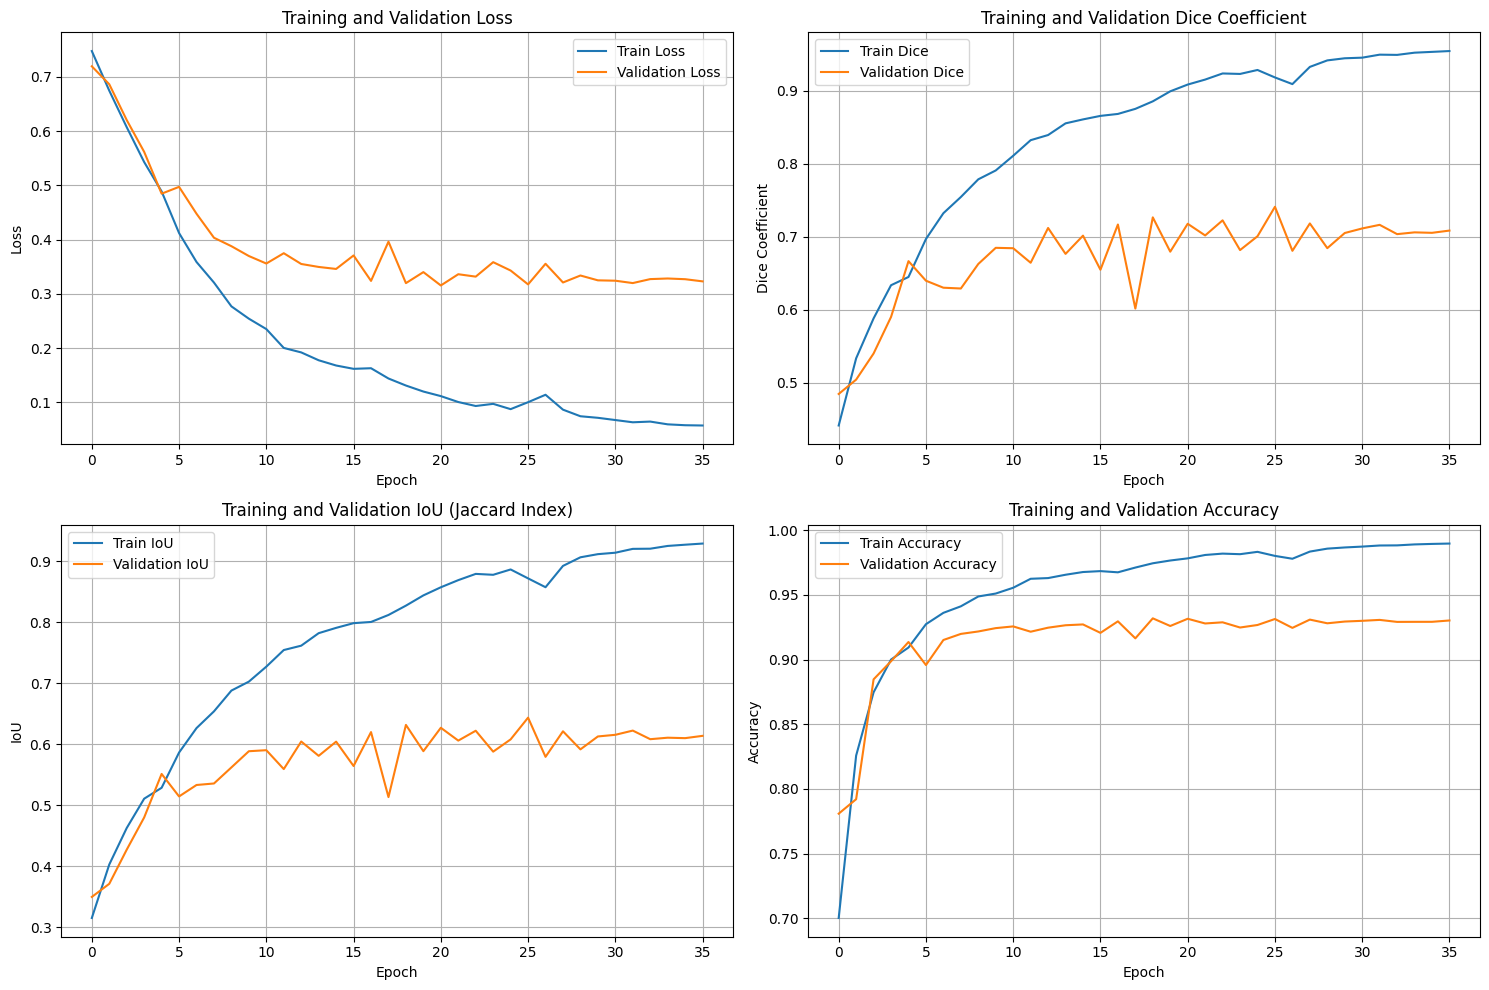

Training completed!


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from ducknet import create_ducknet

class EarlyStopping:
    """Early stopping để dừng training khi validation loss không cải thiện"""
    def __init__(self, patience=10, min_delta=0.0, restore_best_weights=True, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None
        
    def __call__(self, val_metric, model):
        # Sử dụng validation dice score (càng cao càng tốt)
        score = val_metric
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model_state)
                    if self.verbose:
                        print('Restored best model weights')
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0
            
    def save_checkpoint(self, model):
        """Save model checkpoint"""
        self.best_model_state = model.state_dict().copy()

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-6):
        super(FocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Apply sigmoid if not already
        if inputs.max() > 1:
            inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        TP = (inputs * targets).sum()
        FP = ((1 - targets) * inputs).sum()
        FN = (targets * (1 - inputs)).sum()

        Tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        FocalTversky = (1 - Tversky) ** self.gamma

        return FocalTversky


class KvasirDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, mask_transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.mask_transform = mask_transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        
        # Load mask
        mask = Image.open(self.mask_paths[idx]).convert('L')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        # Convert mask to binary (0 or 1)
        mask = (mask > 0.5).float()
        
        return image, mask

def dice_coefficient(pred, target, smooth=1e-6):
    """Calculate Dice coefficient"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    intersection = (pred * target).sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + smooth)
    return dice.mean()

def jaccard_index(pred, target, smooth=1e-6):
    """Calculate Jaccard Index (IoU)"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def precision_score(pred, target, smooth=1e-6):
    """Calculate Precision"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    true_positive = (pred * target).sum(dim=(2, 3))
    predicted_positive = pred.sum(dim=(2, 3))
    precision = (true_positive + smooth) / (predicted_positive + smooth)
    return precision.mean()

def recall_score(pred, target, smooth=1e-6):
    """Calculate Recall (Sensitivity)"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    true_positive = (pred * target).sum(dim=(2, 3))
    actual_positive = target.sum(dim=(2, 3))
    recall = (true_positive + smooth) / (actual_positive + smooth)
    return recall.mean()

def accuracy_score(pred, target):
    """Calculate Accuracy"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    correct = (pred == target).float()
    accuracy = correct.mean()
    return accuracy

def prepare_data():
    """Prepare Kvasir dataset"""
    data_dir = "/kaggle/input/dataset/Kvasir-SEG"
    images_dir = os.path.join(data_dir, "images")
    masks_dir = os.path.join(data_dir, "masks")
    
    # Get all image files
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    
    image_paths = []
    mask_paths = []
    
    for img_file in image_files:
        img_path = os.path.join(images_dir, img_file)
        mask_path = os.path.join(masks_dir, img_file)
        
        if os.path.exists(mask_path):
            image_paths.append(img_path)
            mask_paths.append(mask_path)
    
    print(f"Found {len(image_paths)} image-mask pairs")
    
    # Split dataset
    train_imgs, val_imgs, train_masks, val_masks = train_test_split(
        image_paths, mask_paths, test_size=0.2, random_state=42
    )
    
    return train_imgs, val_imgs, train_masks, val_masks

def create_data_loaders(train_imgs, val_imgs, train_masks, val_masks, batch_size=4):
    """Create PyTorch data loaders"""
    
    # Define transforms
    image_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    
    # Create datasets
    train_dataset = KvasirDataset(train_imgs, train_masks, image_transform, mask_transform)
    val_dataset = KvasirDataset(val_imgs, val_masks, image_transform, mask_transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, val_loader

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4, 
                early_stopping_patience=10, early_stopping_min_delta=0.001):
    """Train the DuckNet model with early stopping"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=0.75)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(
        patience=early_stopping_patience, 
        min_delta=early_stopping_min_delta, 
        restore_best_weights=True, 
        verbose=True
    )
    
    # Training history
    train_losses = []
    val_losses = []
    train_dices = []
    val_dices = []
    train_ious = []
    val_ious = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_dice = 0.0
    
    print("Starting training...")
    print(f"Early stopping patience: {early_stopping_patience} epochs")
    print(f"Early stopping min delta: {early_stopping_min_delta}")
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        train_iou = 0.0
        train_precision = 0.0
        train_recall = 0.0
        train_accuracy = 0.0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (images, masks) in enumerate(train_pbar):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            dice = dice_coefficient(outputs, masks)
            iou = jaccard_index(outputs, masks)
            precision = precision_score(outputs, masks)
            recall = recall_score(outputs, masks)
            accuracy = accuracy_score(outputs, masks)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_dice += dice.item()
            train_iou += iou.item()
            train_precision += precision.item()
            train_recall += recall.item()
            train_accuracy += accuracy.item()
            
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Dice': f'{dice.item():.4f}',
                'IoU': f'{iou.item():.4f}'
            })
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_iou = 0.0
        val_precision = 0.0
        val_recall = 0.0
        val_accuracy = 0.0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, masks in val_pbar:
                images, masks = images.to(device), masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                dice = dice_coefficient(outputs, masks)
                iou = jaccard_index(outputs, masks)
                precision = precision_score(outputs, masks)
                recall = recall_score(outputs, masks)
                accuracy = accuracy_score(outputs, masks)
                
                val_loss += loss.item()
                val_dice += dice.item()
                val_iou += iou.item()
                val_precision += precision.item()
                val_recall += recall.item()
                val_accuracy += accuracy.item()
                
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Dice': f'{dice.item():.4f}',
                    'IoU': f'{iou.item():.4f}'
                })
        
        # Calculate average metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_train_dice = train_dice / len(train_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_train_iou = train_iou / len(train_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_train_precision = train_precision / len(train_loader)
        avg_val_precision = val_precision / len(val_loader)
        avg_train_recall = train_recall / len(train_loader)
        avg_val_recall = val_recall / len(val_loader)
        avg_train_accuracy = train_accuracy / len(train_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Save metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_dices.append(avg_train_dice)
        val_dices.append(avg_val_dice)
        train_ious.append(avg_train_iou)
        val_ious.append(avg_val_iou)
        train_precisions.append(avg_train_precision)
        val_precisions.append(avg_val_precision)
        train_recalls.append(avg_train_recall)
        val_recalls.append(avg_val_recall)
        train_accuracies.append(avg_train_accuracy)
        val_accuracies.append(avg_val_accuracy)
        
        epoch_time = time.time() - start_time
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train - Loss: {avg_train_loss:.4f}, Dice: {avg_train_dice:.4f}, IoU: {avg_train_iou:.4f}, Acc: {avg_train_accuracy:.4f}')
        print(f'  Val   - Loss: {avg_val_loss:.4f}, Dice: {avg_val_dice:.4f}, IoU: {avg_val_iou:.4f}, Acc: {avg_val_accuracy:.4f}')
        print(f'  Precision: Train={avg_train_precision:.4f}, Val={avg_val_precision:.4f}')
        print(f'  Recall   : Train={avg_train_recall:.4f}, Val={avg_val_recall:.4f}')
        print(f'  Time: {epoch_time:.2f}s')
        print('-' * 70)
        
        # Save best model
        if avg_val_dice > best_val_dice:
            best_val_dice = avg_val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': avg_val_dice,
                'val_loss': avg_val_loss,
            }, 'checkpoints/ducknet_pytorch_best.pth')
            print(f'  New best model saved! Dice: {best_val_dice:.4f}')
        
        # Check early stopping
        early_stopping(avg_val_dice, model)
        
        if early_stopping.early_stop:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            print(f"Best validation Dice score: {early_stopping.best_score:.4f}")
            break
    
    # Save final model
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_dices': train_dices,
        'val_dices': val_dices,
        'train_ious': train_ious,
        'val_ious': val_ious,
        'train_precisions': train_precisions,
        'val_precisions': val_precisions,
        'train_recalls': train_recalls,
        'val_recalls': val_recalls,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'early_stopped': early_stopping.early_stop,
        'best_val_dice': early_stopping.best_score,
    }, 'checkpoints/ducknet_pytorch_final.pth')
    
    return train_losses, val_losses, train_dices, val_dices, train_ious, val_ious, train_accuracies, val_accuracies

def plot_training_history(train_losses, val_losses, train_dices, val_dices, train_ious, val_ious, train_accuracies, val_accuracies):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot losses
    axes[0,0].plot(train_losses, label='Train Loss')
    axes[0,0].plot(val_losses, label='Validation Loss')
    axes[0,0].set_title('Training and Validation Loss')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    # Plot dice coefficients
    axes[0,1].plot(train_dices, label='Train Dice')
    axes[0,1].plot(val_dices, label='Validation Dice')
    axes[0,1].set_title('Training and Validation Dice Coefficient')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Dice Coefficient')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # Plot IoU (Jaccard Index)
    axes[1,0].plot(train_ious, label='Train IoU')
    axes[1,0].plot(val_ious, label='Validation IoU')
    axes[1,0].set_title('Training and Validation IoU (Jaccard Index)')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('IoU')
    axes[1,0].legend()
    axes[1,0].grid(True)
    
    # Plot Accuracy
    axes[1,1].plot(train_accuracies, label='Train Accuracy')
    axes[1,1].plot(val_accuracies, label='Validation Accuracy')
    axes[1,1].set_title('Training and Validation Accuracy')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].legend()
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.savefig('logs/training_history_pytorch.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    """Main training function"""
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Create directories if they don't exist
    os.makedirs('checkpoints', exist_ok=True)
    os.makedirs('logs', exist_ok=True)
    
    # Prepare data
    print("Preparing data...")
    train_imgs, val_imgs, train_masks, val_masks = prepare_data()
    
    # Create data loaders
    print("Creating data loaders...")
    train_loader, val_loader = create_data_loaders(
        train_imgs, val_imgs, train_masks, val_masks, batch_size=4
    )
    
    # Create model
    print("Creating model...")
    model = create_ducknet(input_channels=3, num_classes=1)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Train model with early stopping
    train_losses, val_losses, train_dices, val_dices, train_ious, val_ious, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, 
        num_epochs=50, 
        learning_rate=1e-4,
        early_stopping_patience=10,  # Dừng nếu không cải thiện sau 10 epochs
        early_stopping_min_delta=0.001  # Ngưỡng cải thiện tối thiểu
    )
    
    # Plot training history
    plot_training_history(train_losses, val_losses, train_dices, val_dices, train_ious, val_ious, train_accuracies, val_accuracies)
    
    print("Training completed!")

if __name__ == "__main__":
    main()

# Training Ducknet với attention trong từng block

Preparing data...
Found 1000 image-mask pairs
Creating data loaders...
Creating DuckNet with Attention...
Total parameters: 8,279,506
Trainable parameters: 8,279,506
Using device: cuda
Starting training DuckNet with Attention Gates...


Epoch 1/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.80it/s, Loss=0.7612, Dice=0.4592, IoU=0.3218]


Epoch 1/50:
  Train - Loss: 0.7885, Dice: 0.4096, IoU: 0.2878, Acc: 0.6409
  Val   - Loss: 0.7525, Dice: 0.4562, IoU: 0.3254, Acc: 0.7396
  Precision: Train=0.3062, Val=0.3656
  Recall   : Train=0.9146, Val=0.8869
  Time: 50.42s
----------------------------------------------------------------------
  New best model saved! Dice: 0.4562


Epoch 2/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.54it/s, Loss=0.7144, Dice=0.5427, IoU=0.3855]


Epoch 2/50:
  Train - Loss: 0.7184, Dice: 0.4921, IoU: 0.3622, Acc: 0.7781
  Val   - Loss: 0.7175, Dice: 0.4868, IoU: 0.3543, Acc: 0.7784
  Precision: Train=0.4033, Val=0.3950
  Recall   : Train=0.8755, Val=0.8745
  Time: 52.95s
----------------------------------------------------------------------
  New best model saved! Dice: 0.4868


Epoch 3/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.16it/s, Loss=0.6581, Dice=0.5830, IoU=0.4195]


Epoch 3/50:
  Train - Loss: 0.6555, Dice: 0.5757, IoU: 0.4462, Acc: 0.8565
  Val   - Loss: 0.6720, Dice: 0.5187, IoU: 0.3861, Acc: 0.8107
  Precision: Train=0.5250, Val=0.4464
  Recall   : Train=0.8205, Val=0.8481
  Time: 56.70s
----------------------------------------------------------------------
  New best model saved! Dice: 0.5187


Epoch 4/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.03it/s, Loss=0.6375, Dice=0.5680, IoU=0.4314]


Epoch 4/50:
  Train - Loss: 0.5785, Dice: 0.6269, IoU: 0.5009, Acc: 0.8900
  Val   - Loss: 0.6218, Dice: 0.5735, IoU: 0.4448, Acc: 0.8444
  Precision: Train=0.6121, Val=0.5151
  Recall   : Train=0.7911, Val=0.8321
  Time: 56.08s
----------------------------------------------------------------------
  New best model saved! Dice: 0.5735


Epoch 5/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.06it/s, Loss=0.4415, Dice=0.7588, IoU=0.6457]


Epoch 5/50:
  Train - Loss: 0.5146, Dice: 0.6703, IoU: 0.5513, Acc: 0.9064
  Val   - Loss: 0.5228, Dice: 0.6328, IoU: 0.5210, Acc: 0.9052
  Precision: Train=0.6805, Val=0.7129
  Recall   : Train=0.7816, Val=0.6824
  Time: 56.76s
----------------------------------------------------------------------
  New best model saved! Dice: 0.6328


Epoch 6/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.09it/s, Loss=0.4053, Dice=0.8269, IoU=0.7095]


Epoch 6/50:
  Train - Loss: 0.4542, Dice: 0.6891, IoU: 0.5755, Acc: 0.9199
  Val   - Loss: 0.5040, Dice: 0.6737, IoU: 0.5521, Acc: 0.8991
  Precision: Train=0.7357, Val=0.6721
  Recall   : Train=0.7584, Val=0.7985
  Time: 56.52s
----------------------------------------------------------------------
  New best model saved! Dice: 0.6737


Epoch 7/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.06it/s, Loss=0.2792, Dice=0.8834, IoU=0.7937]


Epoch 7/50:
  Train - Loss: 0.3954, Dice: 0.7170, IoU: 0.6099, Acc: 0.9309
  Val   - Loss: 0.4721, Dice: 0.6530, IoU: 0.5411, Acc: 0.9051
  Precision: Train=0.7910, Val=0.7369
  Recall   : Train=0.7525, Val=0.7122
  Time: 56.71s
----------------------------------------------------------------------


Epoch 8/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.02it/s, Loss=0.3176, Dice=0.8588, IoU=0.7604]


Epoch 8/50:
  Train - Loss: 0.3474, Dice: 0.7495, IoU: 0.6441, Acc: 0.9390
  Val   - Loss: 0.4423, Dice: 0.6417, IoU: 0.5370, Acc: 0.9122
  Precision: Train=0.8168, Val=0.7782
  Recall   : Train=0.7685, Val=0.6631
  Time: 56.68s
----------------------------------------------------------------------


Epoch 9/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.96it/s, Loss=0.1903, Dice=0.9110, IoU=0.8386]


Epoch 9/50:
  Train - Loss: 0.3111, Dice: 0.7684, IoU: 0.6671, Acc: 0.9442
  Val   - Loss: 0.4148, Dice: 0.6414, IoU: 0.5381, Acc: 0.9150
  Precision: Train=0.8459, Val=0.8600
  Recall   : Train=0.7747, Val=0.5976
  Time: 56.58s
----------------------------------------------------------------------


Epoch 10/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.05it/s, Loss=0.2661, Dice=0.8683, IoU=0.7726]


Epoch 10/50:
  Train - Loss: 0.3002, Dice: 0.7620, IoU: 0.6609, Acc: 0.9435
  Val   - Loss: 0.4199, Dice: 0.6213, IoU: 0.5212, Acc: 0.9115
  Precision: Train=0.8525, Val=0.8556
  Recall   : Train=0.7540, Val=0.5931
  Time: 56.52s
----------------------------------------------------------------------


Epoch 11/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.95it/s, Loss=0.2370, Dice=0.8853, IoU=0.8003]


Epoch 11/50:
  Train - Loss: 0.2586, Dice: 0.7978, IoU: 0.7034, Acc: 0.9518
  Val   - Loss: 0.3892, Dice: 0.6601, IoU: 0.5599, Acc: 0.9166
  Precision: Train=0.8857, Val=0.8603
  Recall   : Train=0.7781, Val=0.6385
  Time: 56.98s
----------------------------------------------------------------------


Epoch 12/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.10it/s, Loss=0.1559, Dice=0.9054, IoU=0.8335]


Epoch 12/50:
  Train - Loss: 0.2466, Dice: 0.8065, IoU: 0.7133, Acc: 0.9537
  Val   - Loss: 0.3772, Dice: 0.6712, IoU: 0.5737, Acc: 0.9183
  Precision: Train=0.8854, Val=0.8405
  Recall   : Train=0.7871, Val=0.6807
  Time: 56.60s
----------------------------------------------------------------------


Epoch 13/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.99it/s, Loss=0.1874, Dice=0.9072, IoU=0.8329]


Epoch 13/50:
  Train - Loss: 0.2191, Dice: 0.8284, IoU: 0.7421, Acc: 0.9586
  Val   - Loss: 0.3617, Dice: 0.7193, IoU: 0.6133, Acc: 0.9221
  Precision: Train=0.9044, Val=0.8025
  Recall   : Train=0.8060, Val=0.7317
  Time: 56.64s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7193


Epoch 14/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.07it/s, Loss=0.1563, Dice=0.8708, IoU=0.7867]


Epoch 14/50:
  Train - Loss: 0.2088, Dice: 0.8295, IoU: 0.7442, Acc: 0.9600
  Val   - Loss: 0.3771, Dice: 0.6593, IoU: 0.5607, Acc: 0.9170
  Precision: Train=0.9125, Val=0.8684
  Recall   : Train=0.8008, Val=0.6230
  Time: 56.99s
----------------------------------------------------------------------


Epoch 15/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.06it/s, Loss=0.2881, Dice=0.8622, IoU=0.7703]


Epoch 15/50:
  Train - Loss: 0.1993, Dice: 0.8361, IoU: 0.7518, Acc: 0.9617
  Val   - Loss: 0.3802, Dice: 0.7122, IoU: 0.6056, Acc: 0.9154
  Precision: Train=0.9161, Val=0.7709
  Recall   : Train=0.8094, Val=0.7565
  Time: 56.73s
----------------------------------------------------------------------


Epoch 16/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.03it/s, Loss=0.1574, Dice=0.9174, IoU=0.8482]


Epoch 16/50:
  Train - Loss: 0.1835, Dice: 0.8504, IoU: 0.7708, Acc: 0.9652
  Val   - Loss: 0.3557, Dice: 0.7280, IoU: 0.6221, Acc: 0.9224
  Precision: Train=0.9237, Val=0.7976
  Recall   : Train=0.8223, Val=0.7625
  Time: 56.57s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7280


Epoch 17/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.12it/s, Loss=0.1629, Dice=0.9070, IoU=0.8317]


Epoch 17/50:
  Train - Loss: 0.1717, Dice: 0.8572, IoU: 0.7800, Acc: 0.9671
  Val   - Loss: 0.3391, Dice: 0.7113, IoU: 0.6121, Acc: 0.9247
  Precision: Train=0.9322, Val=0.8535
  Recall   : Train=0.8254, Val=0.6884
  Time: 56.47s
----------------------------------------------------------------------


Epoch 18/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.03it/s, Loss=0.1930, Dice=0.8956, IoU=0.8138]


Epoch 18/50:
  Train - Loss: 0.1571, Dice: 0.8713, IoU: 0.8003, Acc: 0.9705
  Val   - Loss: 0.3330, Dice: 0.7300, IoU: 0.6297, Acc: 0.9260
  Precision: Train=0.9408, Val=0.8296
  Recall   : Train=0.8422, Val=0.7419
  Time: 56.49s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7300


Epoch 19/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.00it/s, Loss=0.1369, Dice=0.9243, IoU=0.8602]


Epoch 19/50:
  Train - Loss: 0.1482, Dice: 0.8792, IoU: 0.8090, Acc: 0.9723
  Val   - Loss: 0.3504, Dice: 0.6924, IoU: 0.5974, Acc: 0.9212
  Precision: Train=0.9479, Val=0.8470
  Recall   : Train=0.8473, Val=0.6748
  Time: 56.69s
----------------------------------------------------------------------


Epoch 20/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.08it/s, Loss=0.2003, Dice=0.8941, IoU=0.8132]


Epoch 20/50:
  Train - Loss: 0.1472, Dice: 0.8816, IoU: 0.8114, Acc: 0.9717
  Val   - Loss: 0.3383, Dice: 0.7077, IoU: 0.6115, Acc: 0.9236
  Precision: Train=0.9454, Val=0.8770
  Recall   : Train=0.8478, Val=0.6825
  Time: 57.09s
----------------------------------------------------------------------


Epoch 21/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.03it/s, Loss=0.1228, Dice=0.9191, IoU=0.8525]


Epoch 21/50:
  Train - Loss: 0.1356, Dice: 0.8857, IoU: 0.8189, Acc: 0.9747
  Val   - Loss: 0.3114, Dice: 0.7194, IoU: 0.6197, Acc: 0.9306
  Precision: Train=0.9509, Val=0.8834
  Recall   : Train=0.8553, Val=0.6820
  Time: 56.71s
----------------------------------------------------------------------


Epoch 22/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.05it/s, Loss=0.1962, Dice=0.8952, IoU=0.8122]


Epoch 22/50:
  Train - Loss: 0.1426, Dice: 0.8823, IoU: 0.8148, Acc: 0.9732
  Val   - Loss: 0.3380, Dice: 0.7302, IoU: 0.6294, Acc: 0.9259
  Precision: Train=0.9472, Val=0.8106
  Recall   : Train=0.8528, Val=0.7371
  Time: 56.71s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7302


Epoch 23/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.01it/s, Loss=0.1752, Dice=0.9077, IoU=0.8341]


Epoch 23/50:
  Train - Loss: 0.1330, Dice: 0.8919, IoU: 0.8292, Acc: 0.9752
  Val   - Loss: 0.3515, Dice: 0.7418, IoU: 0.6437, Acc: 0.9229
  Precision: Train=0.9508, Val=0.7896
  Recall   : Train=0.8612, Val=0.7916
  Time: 56.59s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7418


Epoch 24/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.11it/s, Loss=0.1965, Dice=0.6919, IoU=0.6444]


Epoch 24/50:
  Train - Loss: 0.1260, Dice: 0.8981, IoU: 0.8361, Acc: 0.9765
  Val   - Loss: 0.3844, Dice: 0.6308, IoU: 0.5381, Acc: 0.9156
  Precision: Train=0.9587, Val=0.8311
  Recall   : Train=0.8652, Val=0.6235
  Time: 56.67s
----------------------------------------------------------------------


Epoch 25/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.05it/s, Loss=0.2507, Dice=0.8790, IoU=0.7985]


Epoch 25/50:
  Train - Loss: 0.1175, Dice: 0.8977, IoU: 0.8383, Acc: 0.9785
  Val   - Loss: 0.3106, Dice: 0.7480, IoU: 0.6451, Acc: 0.9307
  Precision: Train=0.9616, Val=0.8632
  Recall   : Train=0.8665, Val=0.7320
  Time: 57.04s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7480


Epoch 26/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.13it/s, Loss=0.1482, Dice=0.8832, IoU=0.8017]


Epoch 26/50:
  Train - Loss: 0.1110, Dice: 0.9096, IoU: 0.8529, Acc: 0.9796
  Val   - Loss: 0.3351, Dice: 0.6951, IoU: 0.5970, Acc: 0.9244
  Precision: Train=0.9584, Val=0.8584
  Recall   : Train=0.8798, Val=0.6659
  Time: 56.62s
----------------------------------------------------------------------


Epoch 27/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.01it/s, Loss=0.3045, Dice=0.7822, IoU=0.6669]


Epoch 27/50:
  Train - Loss: 0.1226, Dice: 0.8981, IoU: 0.8356, Acc: 0.9768
  Val   - Loss: 0.3208, Dice: 0.7272, IoU: 0.6258, Acc: 0.9288
  Precision: Train=0.9581, Val=0.8730
  Recall   : Train=0.8682, Val=0.7003
  Time: 56.82s
----------------------------------------------------------------------


Epoch 28/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.01it/s, Loss=0.3059, Dice=0.8402, IoU=0.7442]


Epoch 28/50:
  Train - Loss: 0.1135, Dice: 0.9075, IoU: 0.8501, Acc: 0.9793
  Val   - Loss: 0.3054, Dice: 0.7455, IoU: 0.6503, Acc: 0.9313
  Precision: Train=0.9605, Val=0.8628
  Recall   : Train=0.8782, Val=0.7403
  Time: 56.86s
----------------------------------------------------------------------


Epoch 29/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.08it/s, Loss=0.1980, Dice=0.8938, IoU=0.8136]


Epoch 29/50:
  Train - Loss: 0.0999, Dice: 0.9175, IoU: 0.8654, Acc: 0.9823
  Val   - Loss: 0.3258, Dice: 0.7123, IoU: 0.6138, Acc: 0.9267
  Precision: Train=0.9705, Val=0.8956
  Recall   : Train=0.8887, Val=0.6715
  Time: 56.44s
----------------------------------------------------------------------


Epoch 30/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.07it/s, Loss=0.3135, Dice=0.8543, IoU=0.7666]


Epoch 30/50:
  Train - Loss: 0.0965, Dice: 0.9229, IoU: 0.8720, Acc: 0.9829
  Val   - Loss: 0.3326, Dice: 0.7377, IoU: 0.6400, Acc: 0.9259
  Precision: Train=0.9712, Val=0.8329
  Recall   : Train=0.8940, Val=0.7633
  Time: 56.57s
----------------------------------------------------------------------


Epoch 31/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.07it/s, Loss=0.2270, Dice=0.8897, IoU=0.8129]


Epoch 31/50:
  Train - Loss: 0.0910, Dice: 0.9276, IoU: 0.8804, Acc: 0.9843
  Val   - Loss: 0.2978, Dice: 0.7620, IoU: 0.6667, Acc: 0.9339
  Precision: Train=0.9752, Val=0.8461
  Recall   : Train=0.9003, Val=0.7605
  Time: 56.51s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7620


Epoch 32/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.10it/s, Loss=0.2342, Dice=0.8783, IoU=0.7933]


Epoch 32/50:
  Train - Loss: 0.0966, Dice: 0.9244, IoU: 0.8756, Acc: 0.9827
  Val   - Loss: 0.3093, Dice: 0.7461, IoU: 0.6481, Acc: 0.9313
  Precision: Train=0.9703, Val=0.8332
  Recall   : Train=0.8979, Val=0.7489
  Time: 56.52s
----------------------------------------------------------------------


Epoch 33/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.05it/s, Loss=0.1870, Dice=0.8974, IoU=0.8169]


Epoch 33/50:
  Train - Loss: 0.0920, Dice: 0.9245, IoU: 0.8766, Acc: 0.9840
  Val   - Loss: 0.3166, Dice: 0.7265, IoU: 0.6321, Acc: 0.9294
  Precision: Train=0.9745, Val=0.8483
  Recall   : Train=0.8967, Val=0.7170
  Time: 56.63s
----------------------------------------------------------------------


Epoch 34/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.11it/s, Loss=0.1765, Dice=0.9004, IoU=0.8221]


Epoch 34/50:
  Train - Loss: 0.0907, Dice: 0.9219, IoU: 0.8751, Acc: 0.9839
  Val   - Loss: 0.2998, Dice: 0.7563, IoU: 0.6597, Acc: 0.9330
  Precision: Train=0.9747, Val=0.8518
  Recall   : Train=0.8957, Val=0.7517
  Time: 56.63s
----------------------------------------------------------------------


Epoch 35/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.06it/s, Loss=0.3556, Dice=0.8361, IoU=0.7460]


Epoch 35/50:
  Train - Loss: 0.0882, Dice: 0.9281, IoU: 0.8812, Acc: 0.9847
  Val   - Loss: 0.3358, Dice: 0.7570, IoU: 0.6607, Acc: 0.9260
  Precision: Train=0.9718, Val=0.7887
  Recall   : Train=0.9010, Val=0.8164
  Time: 56.58s
----------------------------------------------------------------------


Epoch 36/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.10it/s, Loss=0.1035, Dice=0.9378, IoU=0.8839]


Epoch 36/50:
  Train - Loss: 0.0829, Dice: 0.9320, IoU: 0.8871, Acc: 0.9854
  Val   - Loss: 0.3152, Dice: 0.7404, IoU: 0.6423, Acc: 0.9274
  Precision: Train=0.9794, Val=0.8563
  Recall   : Train=0.9048, Val=0.7147
  Time: 56.62s
----------------------------------------------------------------------


Epoch 37/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.93it/s, Loss=0.2750, Dice=0.8680, IoU=0.7818]


Epoch 37/50:
  Train - Loss: 0.0867, Dice: 0.9271, IoU: 0.8827, Acc: 0.9849
  Val   - Loss: 0.3138, Dice: 0.7318, IoU: 0.6397, Acc: 0.9305
  Precision: Train=0.9741, Val=0.8643
  Recall   : Train=0.9018, Val=0.7222
  Time: 57.12s
----------------------------------------------------------------------


Epoch 38/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.01it/s, Loss=0.2048, Dice=0.8948, IoU=0.8165]


Epoch 38/50:
  Train - Loss: 0.0760, Dice: 0.9378, IoU: 0.8981, Acc: 0.9873
  Val   - Loss: 0.3049, Dice: 0.7275, IoU: 0.6377, Acc: 0.9319
  Precision: Train=0.9812, Val=0.8837
  Recall   : Train=0.9122, Val=0.7130
  Time: 56.90s
----------------------------------------------------------------------


Epoch 39/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.01it/s, Loss=0.2836, Dice=0.8660, IoU=0.7797]


Epoch 39/50:
  Train - Loss: 0.0686, Dice: 0.9439, IoU: 0.9081, Acc: 0.9892
  Val   - Loss: 0.3025, Dice: 0.7606, IoU: 0.6680, Acc: 0.9344
  Precision: Train=0.9856, Val=0.8522
  Recall   : Train=0.9206, Val=0.7768
  Time: 56.80s
----------------------------------------------------------------------


Epoch 40/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.01it/s, Loss=0.1314, Dice=0.9202, IoU=0.8544]


Epoch 40/50:
  Train - Loss: 0.0629, Dice: 0.9479, IoU: 0.9141, Acc: 0.9899
  Val   - Loss: 0.3092, Dice: 0.7280, IoU: 0.6332, Acc: 0.9304
  Precision: Train=0.9865, Val=0.8913
  Recall   : Train=0.9257, Val=0.6955
  Time: 56.80s
----------------------------------------------------------------------


Epoch 41/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.03it/s, Loss=0.2293, Dice=0.8792, IoU=0.7935]


Epoch 41/50:
  Train - Loss: 0.0652, Dice: 0.9476, IoU: 0.9133, Acc: 0.9898
  Val   - Loss: 0.2898, Dice: 0.7508, IoU: 0.6610, Acc: 0.9355
  Precision: Train=0.9821, Val=0.8766
  Recall   : Train=0.9267, Val=0.7410
  Time: 56.63s
----------------------------------------------------------------------


Epoch 42/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.03it/s, Loss=0.2385, Dice=0.8759, IoU=0.7897]


Epoch 42/50:
  Train - Loss: 0.0666, Dice: 0.9458, IoU: 0.9108, Acc: 0.9891
  Val   - Loss: 0.2973, Dice: 0.7476, IoU: 0.6568, Acc: 0.9340
  Precision: Train=0.9845, Val=0.8579
  Recall   : Train=0.9230, Val=0.7326
  Time: 56.54s
----------------------------------------------------------------------


Epoch 43/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.05it/s, Loss=0.2478, Dice=0.8696, IoU=0.7803]


Epoch 43/50:
  Train - Loss: 0.0618, Dice: 0.9511, IoU: 0.9187, Acc: 0.9906
  Val   - Loss: 0.2935, Dice: 0.7655, IoU: 0.6720, Acc: 0.9356
  Precision: Train=0.9865, Val=0.8524
  Recall   : Train=0.9299, Val=0.7605
  Time: 56.58s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7655


Epoch 44/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.06it/s, Loss=0.2472, Dice=0.8699, IoU=0.7795]


Epoch 44/50:
  Train - Loss: 0.0628, Dice: 0.9511, IoU: 0.9176, Acc: 0.9898
  Val   - Loss: 0.2947, Dice: 0.7669, IoU: 0.6754, Acc: 0.9352
  Precision: Train=0.9845, Val=0.8375
  Recall   : Train=0.9294, Val=0.7806
  Time: 56.61s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7669


Epoch 45/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.99it/s, Loss=0.1726, Dice=0.8967, IoU=0.8164]


Epoch 45/50:
  Train - Loss: 0.0590, Dice: 0.9535, IoU: 0.9219, Acc: 0.9908
  Val   - Loss: 0.2883, Dice: 0.7716, IoU: 0.6793, Acc: 0.9364
  Precision: Train=0.9847, Val=0.8549
  Recall   : Train=0.9332, Val=0.7718
  Time: 56.81s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7716


Epoch 46/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.02it/s, Loss=0.3054, Dice=0.8493, IoU=0.7556]


Epoch 46/50:
  Train - Loss: 0.0576, Dice: 0.9555, IoU: 0.9255, Acc: 0.9913
  Val   - Loss: 0.2985, Dice: 0.7563, IoU: 0.6652, Acc: 0.9352
  Precision: Train=0.9878, Val=0.8360
  Recall   : Train=0.9361, Val=0.7607
  Time: 57.05s
----------------------------------------------------------------------


Epoch 47/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.04it/s, Loss=0.1748, Dice=0.8994, IoU=0.8210]


Epoch 47/50:
  Train - Loss: 0.0541, Dice: 0.9568, IoU: 0.9277, Acc: 0.9918
  Val   - Loss: 0.2803, Dice: 0.7733, IoU: 0.6846, Acc: 0.9386
  Precision: Train=0.9863, Val=0.8481
  Recall   : Train=0.9373, Val=0.7761
  Time: 56.98s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7733


Epoch 48/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.03it/s, Loss=0.1821, Dice=0.8966, IoU=0.8165]


Epoch 48/50:
  Train - Loss: 0.0539, Dice: 0.9581, IoU: 0.9300, Acc: 0.9921
  Val   - Loss: 0.2881, Dice: 0.7678, IoU: 0.6783, Acc: 0.9370
  Precision: Train=0.9894, Val=0.8546
  Recall   : Train=0.9394, Val=0.7701
  Time: 57.02s
----------------------------------------------------------------------


Epoch 49/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.04it/s, Loss=0.2182, Dice=0.8811, IoU=0.7939]


Epoch 49/50:
  Train - Loss: 0.0517, Dice: 0.9593, IoU: 0.9321, Acc: 0.9924
  Val   - Loss: 0.2842, Dice: 0.7766, IoU: 0.6880, Acc: 0.9381
  Precision: Train=0.9901, Val=0.8390
  Recall   : Train=0.9410, Val=0.7869
  Time: 56.95s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7766


Epoch 50/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.07it/s, Loss=0.2012, Dice=0.8852, IoU=0.7992]


Epoch 50/50:
  Train - Loss: 0.0501, Dice: 0.9606, IoU: 0.9341, Acc: 0.9927
  Val   - Loss: 0.2815, Dice: 0.7793, IoU: 0.6884, Acc: 0.9382
  Precision: Train=0.9898, Val=0.8497
  Recall   : Train=0.9431, Val=0.7821
  Time: 56.82s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7793


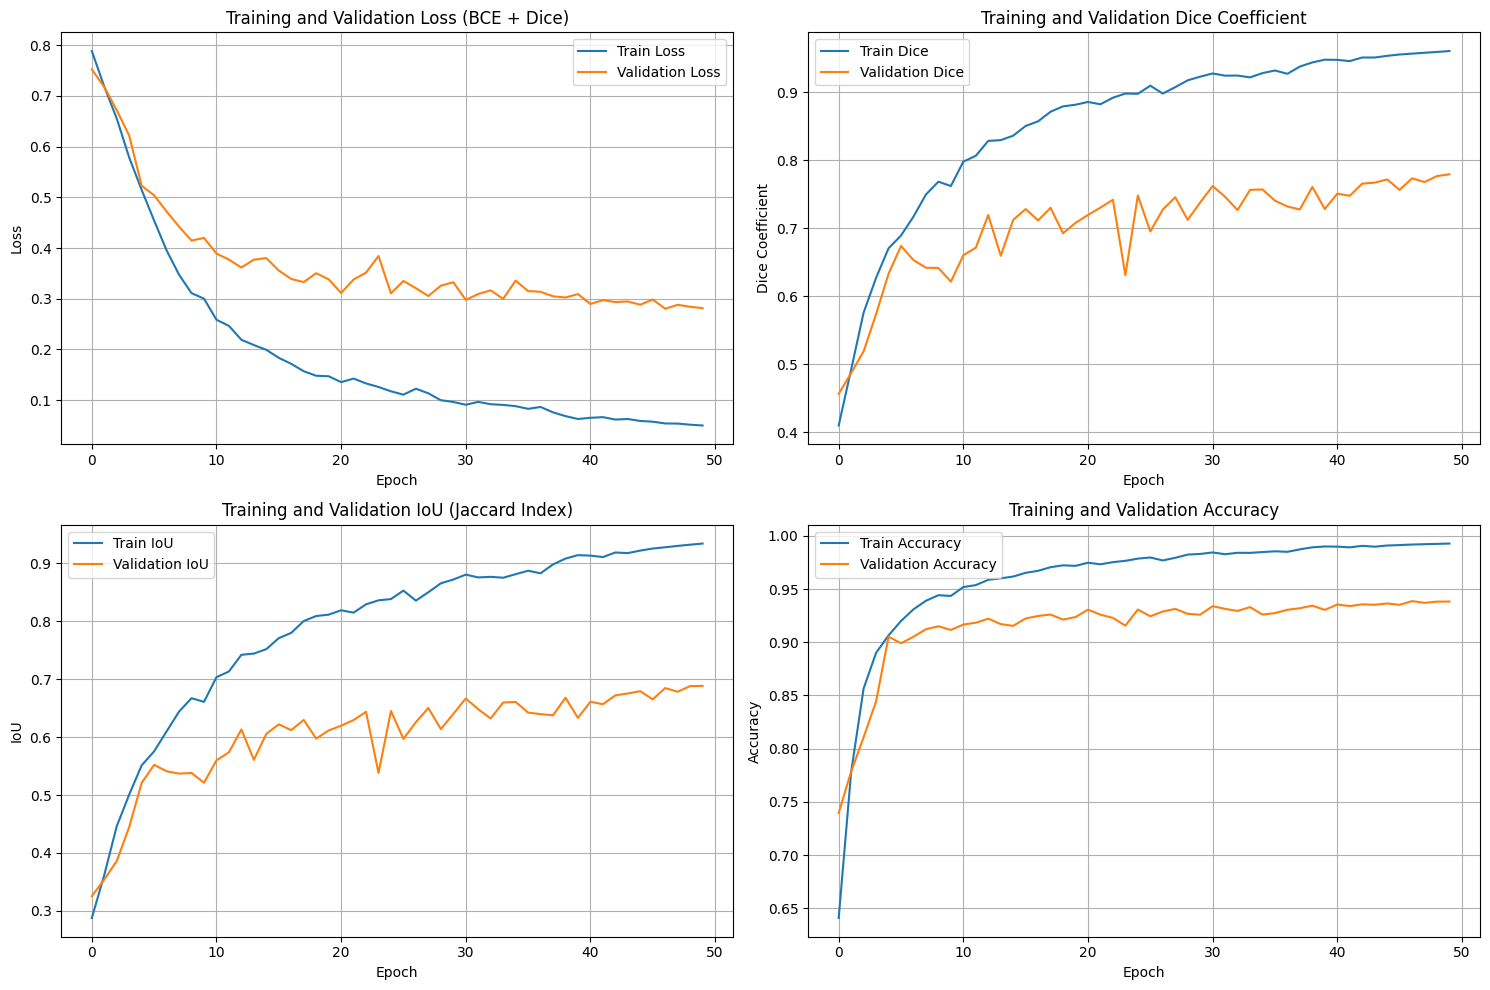

Training completed!
Best model saved as 'ducknet_attention_block_pytorch_best.pth'
Final model saved as 'ducknet_attention_block_pytorch_final.pth'


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from ducknet_attention_block import create_attention_ducknet

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-6):
        super(FocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Apply sigmoid if not already
        if inputs.max() > 1:
            inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        TP = (inputs * targets).sum()
        FP = ((1 - targets) * inputs).sum()
        FN = (targets * (1 - inputs)).sum()

        Tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        FocalTversky = (1 - Tversky) ** self.gamma

        return FocalTversky

class KvasirDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, mask_transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.mask_transform = mask_transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        
        # Load mask
        mask = Image.open(self.mask_paths[idx]).convert('L')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        # Convert mask to binary (0 or 1)
        mask = (mask > 0.5).float()
        
        return image, mask

def dice_coefficient(pred, target, smooth=1e-6):
    """Calculate Dice coefficient"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    intersection = (pred * target).sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + smooth)
    return dice.mean()

def jaccard_index(pred, target, smooth=1e-6):
    """Calculate Jaccard Index (IoU)"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def precision_score(pred, target, smooth=1e-6):
    """Calculate Precision"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    true_positive = (pred * target).sum(dim=(2, 3))
    predicted_positive = pred.sum(dim=(2, 3))
    precision = (true_positive + smooth) / (predicted_positive + smooth)
    return precision.mean()

def recall_score(pred, target, smooth=1e-6):
    """Calculate Recall (Sensitivity)"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    true_positive = (pred * target).sum(dim=(2, 3))
    actual_positive = target.sum(dim=(2, 3))
    recall = (true_positive + smooth) / (actual_positive + smooth)
    return recall.mean()

def accuracy_score(pred, target):
    """Calculate Accuracy"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    correct = (pred == target).float()
    accuracy = correct.mean()
    return accuracy

def dice_loss(pred, target, smooth=1e-6):
    """Calculate Dice Loss"""
    return 1 - dice_coefficient(pred, target, smooth)

def prepare_data():
    """Prepare Kvasir dataset"""
    data_dir = "/kaggle/input/dataset/Kvasir-SEG/"
    images_dir = os.path.join(data_dir, "images")
    masks_dir = os.path.join(data_dir, "masks")
    
    # Get all image files
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    
    image_paths = []
    mask_paths = []
    
    for img_file in image_files:
        img_path = os.path.join(images_dir, img_file)
        mask_path = os.path.join(masks_dir, img_file)
        
        if os.path.exists(mask_path):
            image_paths.append(img_path)
            mask_paths.append(mask_path)
    
    print(f"Found {len(image_paths)} image-mask pairs")
    
    # Split dataset
    train_imgs, val_imgs, train_masks, val_masks = train_test_split(
        image_paths, mask_paths, test_size=0.2, random_state=42
    )
    
    return train_imgs, val_imgs, train_masks, val_masks

def create_data_loaders(train_imgs, val_imgs, train_masks, val_masks, batch_size=4):
    """Create PyTorch data loaders"""
    
    # Define transforms
    image_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    
    # Create datasets
    train_dataset = KvasirDataset(train_imgs, train_masks, image_transform, mask_transform)
    val_dataset = KvasirDataset(val_imgs, val_masks, image_transform, mask_transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, val_loader

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4):
    """Train the DuckNet Attention model"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = model.to(device)
    
    criterion = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=0.75)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    
    # Training history
    train_losses = []
    val_losses = []
    train_dices = []
    val_dices = []
    train_ious = []
    val_ious = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_dice = 0.0
    
    print("Starting training DuckNet with Attention Gates...")
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        train_iou = 0.0
        train_precision = 0.0
        train_recall = 0.0
        train_accuracy = 0.0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (images, masks) in enumerate(train_pbar):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            # Calculate metrics
            dice = dice_coefficient(outputs, masks)
            iou = jaccard_index(outputs, masks)
            precision = precision_score(outputs, masks)
            recall = recall_score(outputs, masks)
            accuracy = accuracy_score(outputs, masks)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_dice += dice.item()
            train_iou += iou.item()
            train_precision += precision.item()
            train_recall += recall.item()
            train_accuracy += accuracy.item()
            
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Dice': f'{dice.item():.4f}',
                'IoU': f'{iou.item():.4f}'
            })
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_iou = 0.0
        val_precision = 0.0
        val_recall = 0.0
        val_accuracy = 0.0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, masks in val_pbar:
                images, masks = images.to(device), masks.to(device)
                
                outputs = model(images)
    
                loss = criterion(outputs, masks)
                
                # Calculate metrics
                dice = dice_coefficient(outputs, masks)
                iou = jaccard_index(outputs, masks)
                precision = precision_score(outputs, masks)
                recall = recall_score(outputs, masks)
                accuracy = accuracy_score(outputs, masks)
                
                val_loss += loss.item()
                val_dice += dice.item()
                val_iou += iou.item()
                val_precision += precision.item()
                val_recall += recall.item()
                val_accuracy += accuracy.item()
                
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Dice': f'{dice.item():.4f}',
                    'IoU': f'{iou.item():.4f}'
                })
        
        # Calculate average metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_train_dice = train_dice / len(train_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_train_iou = train_iou / len(train_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_train_precision = train_precision / len(train_loader)
        avg_val_precision = val_precision / len(val_loader)
        avg_train_recall = train_recall / len(train_loader)
        avg_val_recall = val_recall / len(val_loader)
        avg_train_accuracy = train_accuracy / len(train_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Save metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_dices.append(avg_train_dice)
        val_dices.append(avg_val_dice)
        train_ious.append(avg_train_iou)
        val_ious.append(avg_val_iou)
        train_precisions.append(avg_train_precision)
        val_precisions.append(avg_val_precision)
        train_recalls.append(avg_train_recall)
        val_recalls.append(avg_val_recall)
        train_accuracies.append(avg_train_accuracy)
        val_accuracies.append(avg_val_accuracy)
        
        epoch_time = time.time() - start_time
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train - Loss: {avg_train_loss:.4f}, Dice: {avg_train_dice:.4f}, IoU: {avg_train_iou:.4f}, Acc: {avg_train_accuracy:.4f}')
        print(f'  Val   - Loss: {avg_val_loss:.4f}, Dice: {avg_val_dice:.4f}, IoU: {avg_val_iou:.4f}, Acc: {avg_val_accuracy:.4f}')
        print(f'  Precision: Train={avg_train_precision:.4f}, Val={avg_val_precision:.4f}')
        print(f'  Recall   : Train={avg_train_recall:.4f}, Val={avg_val_recall:.4f}')
        print(f'  Time: {epoch_time:.2f}s')
        print('-' * 70)
        
        # Save best model
        if avg_val_dice > best_val_dice:
            best_val_dice = avg_val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': avg_val_dice,
                'val_loss': avg_val_loss,
            }, 'checkpoints/ducknet_attention_pytorch_block_best.pth')
            print(f'  New best model saved! Dice: {best_val_dice:.4f}')
    
    # Save final model
    torch.save({
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_dices': train_dices,
        'val_dices': val_dices,
        'train_ious': train_ious,
        'val_ious': val_ious,
        'train_precisions': train_precisions,
        'val_precisions': val_precisions,
        'train_recalls': train_recalls,
        'val_recalls': val_recalls,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
    }, 'checkpoints/ducknet_attention_pytorch_block_final.pth')
    
    return train_losses, val_losses, train_dices, val_dices, train_ious, val_ious, train_accuracies, val_accuracies

def plot_training_history(train_losses, val_losses, train_dices, val_dices, train_ious, val_ious, train_accuracies, val_accuracies):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot losses
    axes[0,0].plot(train_losses, label='Train Loss')
    axes[0,0].plot(val_losses, label='Validation Loss')
    axes[0,0].set_title('Training and Validation Loss (BCE + Dice)')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    # Plot dice coefficients
    axes[0,1].plot(train_dices, label='Train Dice')
    axes[0,1].plot(val_dices, label='Validation Dice')
    axes[0,1].set_title('Training and Validation Dice Coefficient')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Dice Coefficient')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # Plot IoU (Jaccard Index)
    axes[1,0].plot(train_ious, label='Train IoU')
    axes[1,0].plot(val_ious, label='Validation IoU')
    axes[1,0].set_title('Training and Validation IoU (Jaccard Index)')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('IoU')
    axes[1,0].legend()
    axes[1,0].grid(True)
    
    # Plot Accuracy
    axes[1,1].plot(train_accuracies, label='Train Accuracy')
    axes[1,1].plot(val_accuracies, label='Validation Accuracy')
    axes[1,1].set_title('Training and Validation Accuracy')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].legend()
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.savefig('logs/training_history_attention_block_pytorch.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    """Main training function"""
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Create directories if they don't exist
    os.makedirs('checkpoints', exist_ok=True)
    os.makedirs('logs', exist_ok=True)
    
    # Prepare data
    print("Preparing data...")
    train_imgs, val_imgs, train_masks, val_masks = prepare_data()
    
    # Create data loaders
    print("Creating data loaders...")
    train_loader, val_loader = create_data_loaders(
        train_imgs, val_imgs, train_masks, val_masks, batch_size=4
    )
    
    # Create model
    print("Creating DuckNet with Attention...")
    model = create_attention_ducknet(input_channels=3, num_classes=1)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Train model
    train_losses, val_losses, train_dices, val_dices, train_ious, val_ious, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4
    )
    
    # Plot training history
    plot_training_history(train_losses, val_losses, train_dices, val_dices, train_ious, val_ious, train_accuracies, val_accuracies)
    
    print("Training completed!")
    print("Best model saved as 'ducknet_attention_block_pytorch_best.pth'")
    print("Final model saved as 'ducknet_attention_block_pytorch_final.pth'")

if __name__ == "__main__":
    main() 

# Training Ducknet với attention trong bottleneck

Preparing data...
Found 1000 image-mask pairs
Creating data loaders...
Creating DuckNet with Attention...
Total parameters: 9,110,173
Trainable parameters: 9,110,173
Using device: cuda
Starting training DuckNet with Attention...


Epoch 1/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 18.03it/s, Loss=0.7334, Dice=0.4387, IoU=0.3024]


Epoch 1/50:
  Train - Loss: 0.7374, Dice: 0.4618, IoU: 0.3339, Acc: 0.7809
  Val   - Loss: 0.7186, Dice: 0.4549, IoU: 0.3244, Acc: 0.7338
  Precision: Train=0.4010, Val=0.3700
  Recall   : Train=0.7719, Val=0.8821
  Time: 37.58s
----------------------------------------------------------------------
  New best model saved! Dice: 0.4549


Epoch 2/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 17.25it/s, Loss=0.6259, Dice=0.5380, IoU=0.4271]


Epoch 2/50:
  Train - Loss: 0.6481, Dice: 0.5361, IoU: 0.4058, Acc: 0.8367
  Val   - Loss: 0.6494, Dice: 0.5194, IoU: 0.3889, Acc: 0.8329
  Precision: Train=0.4914, Val=0.4959
  Recall   : Train=0.7946, Val=0.7808
  Time: 38.67s
----------------------------------------------------------------------
  New best model saved! Dice: 0.5194


Epoch 3/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 15.93it/s, Loss=0.5603, Dice=0.4967, IoU=0.3982]


Epoch 3/50:
  Train - Loss: 0.5775, Dice: 0.5737, IoU: 0.4500, Acc: 0.8753
  Val   - Loss: 0.5924, Dice: 0.5514, IoU: 0.4297, Acc: 0.8646
  Precision: Train=0.5839, Val=0.6028
  Recall   : Train=0.7394, Val=0.7092
  Time: 42.62s
----------------------------------------------------------------------
  New best model saved! Dice: 0.5514


Epoch 4/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 15.29it/s, Loss=0.4752, Dice=0.4215, IoU=0.3530]


Epoch 4/50:
  Train - Loss: 0.5092, Dice: 0.6131, IoU: 0.4925, Acc: 0.8976
  Val   - Loss: 0.5438, Dice: 0.5226, IoU: 0.4197, Acc: 0.8969
  Precision: Train=0.6525, Val=0.7694
  Recall   : Train=0.7179, Val=0.5549
  Time: 43.52s
----------------------------------------------------------------------


Epoch 5/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.86it/s, Loss=0.3674, Dice=0.6708, IoU=0.5548]


Epoch 5/50:
  Train - Loss: 0.4532, Dice: 0.6421, IoU: 0.5276, Acc: 0.9100
  Val   - Loss: 0.4856, Dice: 0.6008, IoU: 0.4827, Acc: 0.9046
  Precision: Train=0.7244, Val=0.7373
  Recall   : Train=0.7043, Val=0.6448
  Time: 43.58s
----------------------------------------------------------------------
  New best model saved! Dice: 0.6008


Epoch 6/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 16.81it/s, Loss=0.2494, Dice=0.6571, IoU=0.5961]


Epoch 6/50:
  Train - Loss: 0.3937, Dice: 0.6665, IoU: 0.5582, Acc: 0.9224
  Val   - Loss: 0.4336, Dice: 0.6094, IoU: 0.5144, Acc: 0.9152
  Precision: Train=0.7823, Val=0.8314
  Recall   : Train=0.6951, Val=0.6028
  Time: 43.28s
----------------------------------------------------------------------
  New best model saved! Dice: 0.6094


Epoch 7/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.58it/s, Loss=0.2518, Dice=0.6778, IoU=0.6056]


Epoch 7/50:
  Train - Loss: 0.3549, Dice: 0.6978, IoU: 0.5925, Acc: 0.9283
  Val   - Loss: 0.4144, Dice: 0.6040, IoU: 0.5089, Acc: 0.9176
  Precision: Train=0.8111, Val=0.8195
  Recall   : Train=0.7129, Val=0.6042
  Time: 43.13s
----------------------------------------------------------------------


Epoch 8/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 16.71it/s, Loss=0.2338, Dice=0.6756, IoU=0.6171]


Epoch 8/50:
  Train - Loss: 0.3119, Dice: 0.7283, IoU: 0.6265, Acc: 0.9372
  Val   - Loss: 0.4198, Dice: 0.6202, IoU: 0.5183, Acc: 0.9125
  Precision: Train=0.8400, Val=0.7920
  Recall   : Train=0.7329, Val=0.6515
  Time: 43.52s
----------------------------------------------------------------------
  New best model saved! Dice: 0.6202


Epoch 9/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 16.69it/s, Loss=0.2014, Dice=0.8888, IoU=0.8030]


Epoch 9/50:
  Train - Loss: 0.2844, Dice: 0.7566, IoU: 0.6612, Acc: 0.9415
  Val   - Loss: 0.3954, Dice: 0.6779, IoU: 0.5672, Acc: 0.9164
  Precision: Train=0.8638, Val=0.7569
  Recall   : Train=0.7545, Val=0.7168
  Time: 43.27s
----------------------------------------------------------------------
  New best model saved! Dice: 0.6779


Epoch 10/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.62it/s, Loss=0.1968, Dice=0.8178, IoU=0.7204]


Epoch 10/50:
  Train - Loss: 0.2583, Dice: 0.7658, IoU: 0.6730, Acc: 0.9471
  Val   - Loss: 0.3958, Dice: 0.6404, IoU: 0.5374, Acc: 0.9167
  Precision: Train=0.8800, Val=0.7904
  Recall   : Train=0.7501, Val=0.6546
  Time: 43.14s
----------------------------------------------------------------------


Epoch 11/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.55it/s, Loss=0.1921, Dice=0.9033, IoU=0.8269]


Epoch 11/50:
  Train - Loss: 0.2459, Dice: 0.7881, IoU: 0.6973, Acc: 0.9491
  Val   - Loss: 0.3868, Dice: 0.6354, IoU: 0.5433, Acc: 0.9182
  Precision: Train=0.8975, Val=0.8715
  Recall   : Train=0.7679, Val=0.6128
  Time: 43.31s
----------------------------------------------------------------------


Epoch 12/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.65it/s, Loss=0.1627, Dice=0.8816, IoU=0.7993]


Epoch 12/50:
  Train - Loss: 0.2399, Dice: 0.7858, IoU: 0.6971, Acc: 0.9490
  Val   - Loss: 0.3603, Dice: 0.6615, IoU: 0.5691, Acc: 0.9228
  Precision: Train=0.8967, Val=0.8498
  Recall   : Train=0.7634, Val=0.6395
  Time: 43.21s
----------------------------------------------------------------------


Epoch 13/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 16.76it/s, Loss=0.1806, Dice=0.7884, IoU=0.7040]


Epoch 13/50:
  Train - Loss: 0.2199, Dice: 0.8104, IoU: 0.7238, Acc: 0.9538
  Val   - Loss: 0.3627, Dice: 0.6609, IoU: 0.5678, Acc: 0.9207
  Precision: Train=0.9088, Val=0.8548
  Recall   : Train=0.7867, Val=0.6539
  Time: 43.13s
----------------------------------------------------------------------


Epoch 14/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.66it/s, Loss=0.1013, Dice=0.9409, IoU=0.8891]


Epoch 14/50:
  Train - Loss: 0.1949, Dice: 0.8309, IoU: 0.7490, Acc: 0.9587
  Val   - Loss: 0.3496, Dice: 0.7059, IoU: 0.6067, Acc: 0.9247
  Precision: Train=0.9250, Val=0.8385
  Recall   : Train=0.8036, Val=0.6996
  Time: 43.20s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7059


Epoch 15/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.59it/s, Loss=0.2579, Dice=0.8836, IoU=0.8059]


Epoch 15/50:
  Train - Loss: 0.1869, Dice: 0.8322, IoU: 0.7534, Acc: 0.9599
  Val   - Loss: 0.3484, Dice: 0.7225, IoU: 0.6170, Acc: 0.9262
  Precision: Train=0.9224, Val=0.8229
  Recall   : Train=0.8045, Val=0.7370
  Time: 43.40s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7225


Epoch 16/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.54it/s, Loss=0.1997, Dice=0.9016, IoU=0.8263]


Epoch 16/50:
  Train - Loss: 0.1660, Dice: 0.8609, IoU: 0.7887, Acc: 0.9653
  Val   - Loss: 0.3703, Dice: 0.6681, IoU: 0.5702, Acc: 0.9225
  Precision: Train=0.9397, Val=0.8752
  Recall   : Train=0.8302, Val=0.6492
  Time: 43.62s
----------------------------------------------------------------------


Epoch 17/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.51it/s, Loss=0.1148, Dice=0.9338, IoU=0.8780]


Epoch 17/50:
  Train - Loss: 0.1580, Dice: 0.8576, IoU: 0.7894, Acc: 0.9673
  Val   - Loss: 0.3473, Dice: 0.6833, IoU: 0.5933, Acc: 0.9258
  Precision: Train=0.9436, Val=0.8755
  Recall   : Train=0.8268, Val=0.6557
  Time: 43.57s
----------------------------------------------------------------------


Epoch 18/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.59it/s, Loss=0.1415, Dice=0.9145, IoU=0.8479]


Epoch 18/50:
  Train - Loss: 0.1637, Dice: 0.8614, IoU: 0.7923, Acc: 0.9657
  Val   - Loss: 0.3173, Dice: 0.7286, IoU: 0.6342, Acc: 0.9318
  Precision: Train=0.9434, Val=0.8586
  Recall   : Train=0.8310, Val=0.7154
  Time: 43.57s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7286


Epoch 19/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.31it/s, Loss=0.1179, Dice=0.9146, IoU=0.8448]


Epoch 19/50:
  Train - Loss: 0.1445, Dice: 0.8795, IoU: 0.8144, Acc: 0.9709
  Val   - Loss: 0.3626, Dice: 0.6434, IoU: 0.5566, Acc: 0.9208
  Precision: Train=0.9526, Val=0.9218
  Recall   : Train=0.8485, Val=0.5910
  Time: 43.64s
----------------------------------------------------------------------


Epoch 20/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.65it/s, Loss=0.1767, Dice=0.8976, IoU=0.8178]


Epoch 20/50:
  Train - Loss: 0.1309, Dice: 0.8885, IoU: 0.8272, Acc: 0.9736
  Val   - Loss: 0.3218, Dice: 0.7310, IoU: 0.6345, Acc: 0.9311
  Precision: Train=0.9554, Val=0.8562
  Recall   : Train=0.8590, Val=0.7307
  Time: 43.42s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7310


Epoch 21/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 16.75it/s, Loss=0.1772, Dice=0.9078, IoU=0.8351]


Epoch 21/50:
  Train - Loss: 0.1264, Dice: 0.8955, IoU: 0.8365, Acc: 0.9744
  Val   - Loss: 0.3397, Dice: 0.7038, IoU: 0.6060, Acc: 0.9257
  Precision: Train=0.9637, Val=0.8433
  Recall   : Train=0.8635, Val=0.6957
  Time: 43.23s
----------------------------------------------------------------------


Epoch 22/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.60it/s, Loss=0.1386, Dice=0.9260, IoU=0.8636]


Epoch 22/50:
  Train - Loss: 0.1205, Dice: 0.8975, IoU: 0.8404, Acc: 0.9758
  Val   - Loss: 0.3308, Dice: 0.7129, IoU: 0.6212, Acc: 0.9289
  Precision: Train=0.9635, Val=0.8773
  Recall   : Train=0.8671, Val=0.7050
  Time: 43.36s
----------------------------------------------------------------------


Epoch 23/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.61it/s, Loss=0.2800, Dice=0.8538, IoU=0.7582]


Epoch 23/50:
  Train - Loss: 0.1281, Dice: 0.8909, IoU: 0.8324, Acc: 0.9728
  Val   - Loss: 0.3767, Dice: 0.6521, IoU: 0.5614, Acc: 0.9186
  Precision: Train=0.9636, Val=0.8885
  Recall   : Train=0.8597, Val=0.6151
  Time: 43.24s
----------------------------------------------------------------------


Epoch 24/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.62it/s, Loss=0.1789, Dice=0.8680, IoU=0.7778]


Epoch 24/50:
  Train - Loss: 0.1326, Dice: 0.8853, IoU: 0.8249, Acc: 0.9724
  Val   - Loss: 0.3330, Dice: 0.6967, IoU: 0.6075, Acc: 0.9279
  Precision: Train=0.9613, Val=0.8941
  Recall   : Train=0.8526, Val=0.6585
  Time: 43.34s
----------------------------------------------------------------------


Epoch 25/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.60it/s, Loss=0.1472, Dice=0.9107, IoU=0.8405]


Epoch 25/50:
  Train - Loss: 0.1072, Dice: 0.9094, IoU: 0.8587, Acc: 0.9788
  Val   - Loss: 0.3076, Dice: 0.7331, IoU: 0.6408, Acc: 0.9322
  Precision: Train=0.9727, Val=0.8931
  Recall   : Train=0.8799, Val=0.7056
  Time: 43.58s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7331


Epoch 26/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.50it/s, Loss=0.1081, Dice=0.9316, IoU=0.8737]


Epoch 26/50:
  Train - Loss: 0.0917, Dice: 0.9212, IoU: 0.8769, Acc: 0.9815
  Val   - Loss: 0.3120, Dice: 0.7368, IoU: 0.6428, Acc: 0.9327
  Precision: Train=0.9798, Val=0.8840
  Recall   : Train=0.8929, Val=0.7172
  Time: 43.51s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7368


Epoch 27/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.57it/s, Loss=0.1298, Dice=0.9260, IoU=0.8632]


Epoch 27/50:
  Train - Loss: 0.0876, Dice: 0.9268, IoU: 0.8849, Acc: 0.9828
  Val   - Loss: 0.3171, Dice: 0.7211, IoU: 0.6272, Acc: 0.9313
  Precision: Train=0.9836, Val=0.8925
  Recall   : Train=0.8990, Val=0.6894
  Time: 43.63s
----------------------------------------------------------------------


Epoch 28/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.66it/s, Loss=0.1579, Dice=0.9060, IoU=0.8302]


Epoch 28/50:
  Train - Loss: 0.0833, Dice: 0.9306, IoU: 0.8906, Acc: 0.9838
  Val   - Loss: 0.3096, Dice: 0.7483, IoU: 0.6530, Acc: 0.9337
  Precision: Train=0.9829, Val=0.8702
  Recall   : Train=0.9041, Val=0.7347
  Time: 43.55s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7483


Epoch 29/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.44it/s, Loss=0.1536, Dice=0.9116, IoU=0.8399]


Epoch 29/50:
  Train - Loss: 0.0792, Dice: 0.9335, IoU: 0.8960, Acc: 0.9849
  Val   - Loss: 0.3061, Dice: 0.7452, IoU: 0.6493, Acc: 0.9338
  Precision: Train=0.9849, Val=0.8856
  Recall   : Train=0.9086, Val=0.7244
  Time: 43.57s
----------------------------------------------------------------------


Epoch 30/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.59it/s, Loss=0.1499, Dice=0.9115, IoU=0.8403]


Epoch 30/50:
  Train - Loss: 0.0763, Dice: 0.9351, IoU: 0.8989, Acc: 0.9856
  Val   - Loss: 0.3138, Dice: 0.7526, IoU: 0.6562, Acc: 0.9327
  Precision: Train=0.9854, Val=0.8486
  Recall   : Train=0.9104, Val=0.7570
  Time: 43.62s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7526


Epoch 31/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.55it/s, Loss=0.1305, Dice=0.9194, IoU=0.8528]


Epoch 31/50:
  Train - Loss: 0.0765, Dice: 0.9361, IoU: 0.9000, Acc: 0.9855
  Val   - Loss: 0.3064, Dice: 0.7547, IoU: 0.6556, Acc: 0.9332
  Precision: Train=0.9854, Val=0.8761
  Recall   : Train=0.9117, Val=0.7320
  Time: 43.52s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7547


Epoch 32/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.41it/s, Loss=0.2041, Dice=0.8960, IoU=0.8146]


Epoch 32/50:
  Train - Loss: 0.0748, Dice: 0.9379, IoU: 0.9017, Acc: 0.9860
  Val   - Loss: 0.2991, Dice: 0.7571, IoU: 0.6639, Acc: 0.9347
  Precision: Train=0.9862, Val=0.8737
  Recall   : Train=0.9137, Val=0.7439
  Time: 43.59s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7571


Epoch 33/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.56it/s, Loss=0.1923, Dice=0.9010, IoU=0.8237]


Epoch 33/50:
  Train - Loss: 0.0711, Dice: 0.9440, IoU: 0.9098, Acc: 0.9870
  Val   - Loss: 0.2962, Dice: 0.7569, IoU: 0.6621, Acc: 0.9352
  Precision: Train=0.9867, Val=0.8857
  Recall   : Train=0.9214, Val=0.7412
  Time: 43.64s
----------------------------------------------------------------------


Epoch 34/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.47it/s, Loss=0.1528, Dice=0.9167, IoU=0.8487]


Epoch 34/50:
  Train - Loss: 0.0671, Dice: 0.9457, IoU: 0.9127, Acc: 0.9875
  Val   - Loss: 0.2986, Dice: 0.7534, IoU: 0.6590, Acc: 0.9359
  Precision: Train=0.9853, Val=0.8777
  Recall   : Train=0.9234, Val=0.7354
  Time: 43.60s
----------------------------------------------------------------------


Epoch 35/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.52it/s, Loss=0.1875, Dice=0.9007, IoU=0.8229]


Epoch 35/50:
  Train - Loss: 0.0658, Dice: 0.9472, IoU: 0.9149, Acc: 0.9880
  Val   - Loss: 0.2969, Dice: 0.7550, IoU: 0.6628, Acc: 0.9353
  Precision: Train=0.9883, Val=0.8693
  Recall   : Train=0.9254, Val=0.7370
  Time: 43.61s
----------------------------------------------------------------------


Epoch 36/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 16.70it/s, Loss=0.1314, Dice=0.9238, IoU=0.8602]


Epoch 36/50:
  Train - Loss: 0.0643, Dice: 0.9494, IoU: 0.9180, Acc: 0.9885
  Val   - Loss: 0.3008, Dice: 0.7438, IoU: 0.6503, Acc: 0.9350
  Precision: Train=0.9885, Val=0.8817
  Recall   : Train=0.9281, Val=0.7219
  Time: 43.63s
----------------------------------------------------------------------


Epoch 37/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.45it/s, Loss=0.1306, Dice=0.9148, IoU=0.8463]


Epoch 37/50:
  Train - Loss: 0.0642, Dice: 0.9492, IoU: 0.9186, Acc: 0.9886
  Val   - Loss: 0.3057, Dice: 0.7302, IoU: 0.6364, Acc: 0.9330
  Precision: Train=0.9883, Val=0.8948
  Recall   : Train=0.9289, Val=0.6942
  Time: 43.60s
----------------------------------------------------------------------


Epoch 38/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 16.68it/s, Loss=0.1419, Dice=0.9142, IoU=0.8445]


Epoch 38/50:
  Train - Loss: 0.0618, Dice: 0.9494, IoU: 0.9192, Acc: 0.9890
  Val   - Loss: 0.3066, Dice: 0.7352, IoU: 0.6435, Acc: 0.9327
  Precision: Train=0.9891, Val=0.8834
  Recall   : Train=0.9289, Val=0.7061
  Time: 43.56s
----------------------------------------------------------------------


Epoch 39/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.51it/s, Loss=0.1718, Dice=0.9008, IoU=0.8253]


Epoch 39/50:
  Train - Loss: 0.0632, Dice: 0.9508, IoU: 0.9208, Acc: 0.9889
  Val   - Loss: 0.3073, Dice: 0.7420, IoU: 0.6500, Acc: 0.9344
  Precision: Train=0.9887, Val=0.8570
  Recall   : Train=0.9310, Val=0.7266
  Time: 43.56s
----------------------------------------------------------------------


Epoch 40/50 [Val]: 100%|██████████| 50/50 [00:02<00:00, 16.67it/s, Loss=0.1279, Dice=0.9239, IoU=0.8614]


Epoch 40/50:
  Train - Loss: 0.0600, Dice: 0.9535, IoU: 0.9248, Acc: 0.9898
  Val   - Loss: 0.3047, Dice: 0.7515, IoU: 0.6576, Acc: 0.9348
  Precision: Train=0.9886, Val=0.8774
  Recall   : Train=0.9338, Val=0.7359
  Time: 43.32s
----------------------------------------------------------------------


Epoch 41/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.66it/s, Loss=0.1645, Dice=0.9098, IoU=0.8374]


Epoch 41/50:
  Train - Loss: 0.0551, Dice: 0.9568, IoU: 0.9305, Acc: 0.9908
  Val   - Loss: 0.3127, Dice: 0.7424, IoU: 0.6475, Acc: 0.9328
  Precision: Train=0.9884, Val=0.8776
  Recall   : Train=0.9385, Val=0.7263
  Time: 43.32s
----------------------------------------------------------------------


Epoch 42/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.64it/s, Loss=0.1766, Dice=0.9052, IoU=0.8310]


Epoch 42/50:
  Train - Loss: 0.0524, Dice: 0.9583, IoU: 0.9331, Acc: 0.9911
  Val   - Loss: 0.3128, Dice: 0.7477, IoU: 0.6526, Acc: 0.9332
  Precision: Train=0.9901, Val=0.8684
  Recall   : Train=0.9407, Val=0.7367
  Time: 43.32s
----------------------------------------------------------------------


Epoch 43/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.63it/s, Loss=0.1752, Dice=0.9047, IoU=0.8290]


Epoch 43/50:
  Train - Loss: 0.0504, Dice: 0.9595, IoU: 0.9350, Acc: 0.9914
  Val   - Loss: 0.3111, Dice: 0.7382, IoU: 0.6452, Acc: 0.9327
  Precision: Train=0.9917, Val=0.8793
  Recall   : Train=0.9423, Val=0.7160
  Time: 43.28s
----------------------------------------------------------------------


Epoch 44/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.58it/s, Loss=0.1654, Dice=0.9084, IoU=0.8350]


Epoch 44/50:
  Train - Loss: 0.0503, Dice: 0.9601, IoU: 0.9362, Acc: 0.9917
  Val   - Loss: 0.3114, Dice: 0.7496, IoU: 0.6533, Acc: 0.9340
  Precision: Train=0.9921, Val=0.8645
  Recall   : Train=0.9433, Val=0.7440
  Time: 43.15s
----------------------------------------------------------------------


Epoch 45/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.57it/s, Loss=0.2172, Dice=0.8861, IoU=0.8024]


Epoch 45/50:
  Train - Loss: 0.0473, Dice: 0.9617, IoU: 0.9384, Acc: 0.9920
  Val   - Loss: 0.3082, Dice: 0.7484, IoU: 0.6552, Acc: 0.9341
  Precision: Train=0.9925, Val=0.8766
  Recall   : Train=0.9452, Val=0.7353
  Time: 43.27s
----------------------------------------------------------------------


Epoch 46/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.60it/s, Loss=0.1589, Dice=0.9086, IoU=0.8352]


Epoch 46/50:
  Train - Loss: 0.0460, Dice: 0.9631, IoU: 0.9408, Acc: 0.9924
  Val   - Loss: 0.3098, Dice: 0.7496, IoU: 0.6543, Acc: 0.9342
  Precision: Train=0.9929, Val=0.8684
  Recall   : Train=0.9472, Val=0.7383
  Time: 43.30s
----------------------------------------------------------------------


Epoch 47/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.43it/s, Loss=0.1434, Dice=0.9148, IoU=0.8450]


Epoch 47/50:
  Train - Loss: 0.0452, Dice: 0.9640, IoU: 0.9423, Acc: 0.9926
  Val   - Loss: 0.3152, Dice: 0.7473, IoU: 0.6511, Acc: 0.9328
  Precision: Train=0.9916, Val=0.8694
  Recall   : Train=0.9489, Val=0.7315
  Time: 43.50s
----------------------------------------------------------------------


Epoch 48/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.59it/s, Loss=0.1769, Dice=0.9027, IoU=0.8262]


Epoch 48/50:
  Train - Loss: 0.0452, Dice: 0.9642, IoU: 0.9426, Acc: 0.9926
  Val   - Loss: 0.3165, Dice: 0.7445, IoU: 0.6491, Acc: 0.9327
  Precision: Train=0.9906, Val=0.8736
  Recall   : Train=0.9488, Val=0.7278
  Time: 43.58s
----------------------------------------------------------------------


Epoch 49/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.54it/s, Loss=0.2401, Dice=0.8780, IoU=0.7929]


Epoch 49/50:
  Train - Loss: 0.0450, Dice: 0.9648, IoU: 0.9438, Acc: 0.9927
  Val   - Loss: 0.3124, Dice: 0.7583, IoU: 0.6622, Acc: 0.9340
  Precision: Train=0.9922, Val=0.8566
  Recall   : Train=0.9497, Val=0.7597
  Time: 43.54s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7583


Epoch 50/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 16.50it/s, Loss=0.1303, Dice=0.9207, IoU=0.8555]


Epoch 50/50:
  Train - Loss: 0.0451, Dice: 0.9652, IoU: 0.9444, Acc: 0.9929
  Val   - Loss: 0.3054, Dice: 0.7420, IoU: 0.6505, Acc: 0.9337
  Precision: Train=0.9923, Val=0.8903
  Recall   : Train=0.9503, Val=0.7149
  Time: 43.31s
----------------------------------------------------------------------


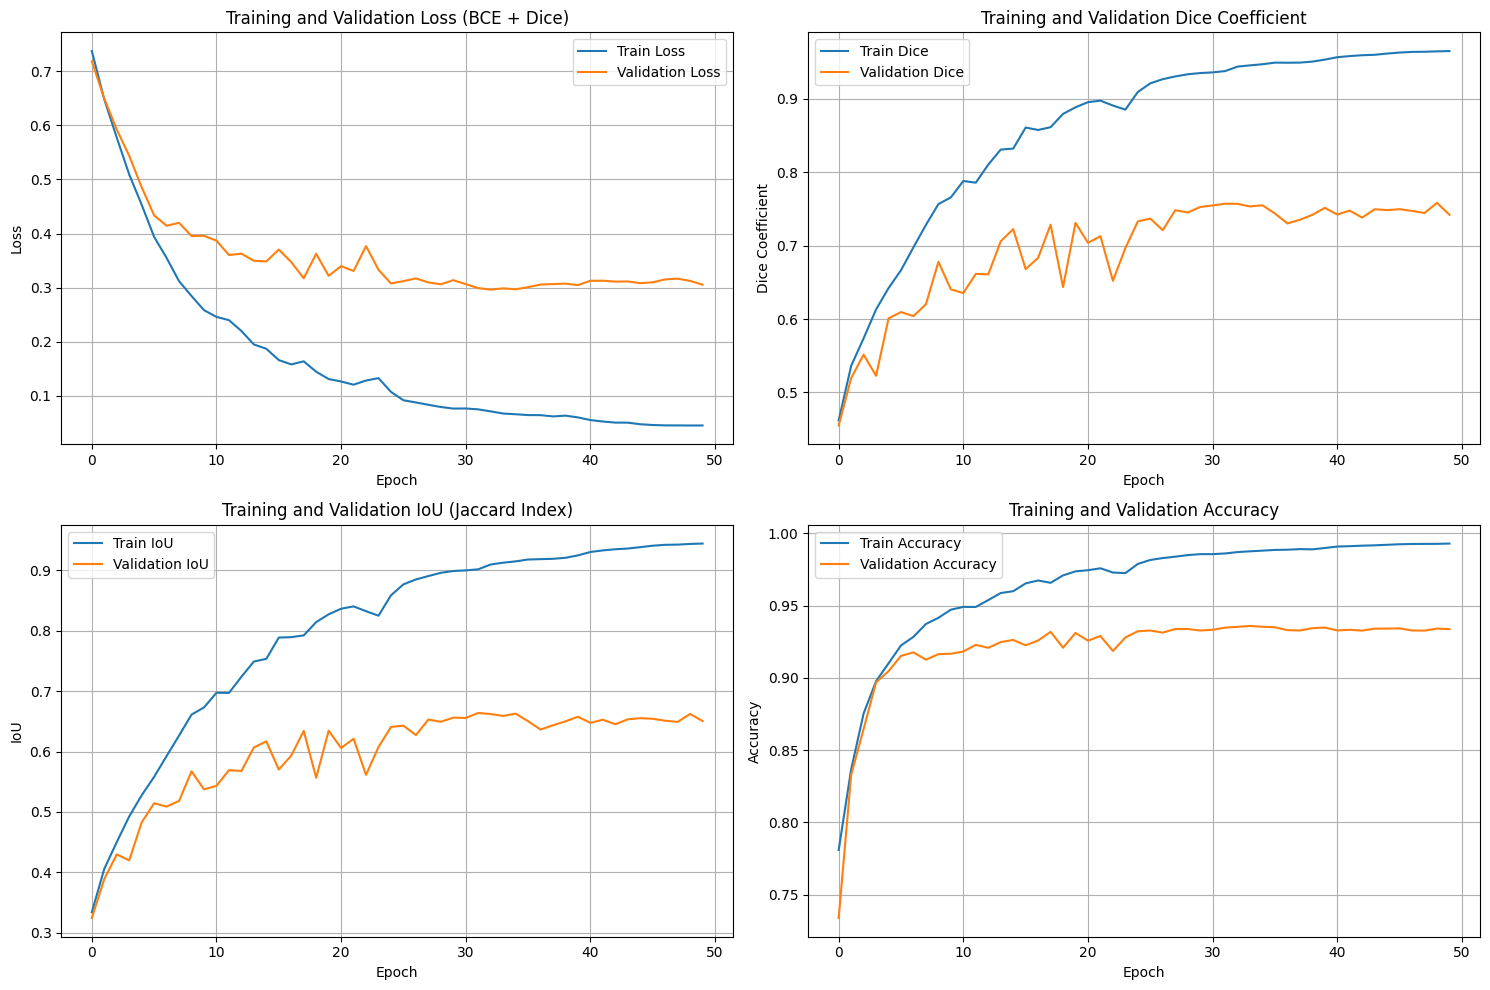

Training completed!
Best model saved as 'ducknet_attention_bottleneck_pytorch_best.pth'
Final model saved as 'ducknet_attention_bottleneck_pytorch_final.pth'


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from ducknet_attention_bottleneck import create_attention_ducknet

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-6):
        super(FocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Apply sigmoid if not already
        if inputs.max() > 1:
            inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        TP = (inputs * targets).sum()
        FP = ((1 - targets) * inputs).sum()
        FN = (targets * (1 - inputs)).sum()

        Tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        FocalTversky = (1 - Tversky) ** self.gamma

        return FocalTversky

class KvasirDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, mask_transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.mask_transform = mask_transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        
        # Load mask
        mask = Image.open(self.mask_paths[idx]).convert('L')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        # Convert mask to binary (0 or 1)
        mask = (mask > 0.5).float()
        
        return image, mask

def dice_coefficient(pred, target, smooth=1e-6):
    """Calculate Dice coefficient"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    intersection = (pred * target).sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + smooth)
    return dice.mean()

def jaccard_index(pred, target, smooth=1e-6):
    """Calculate Jaccard Index (IoU)"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def precision_score(pred, target, smooth=1e-6):
    """Calculate Precision"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    true_positive = (pred * target).sum(dim=(2, 3))
    predicted_positive = pred.sum(dim=(2, 3))
    precision = (true_positive + smooth) / (predicted_positive + smooth)
    return precision.mean()

def recall_score(pred, target, smooth=1e-6):
    """Calculate Recall (Sensitivity)"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    true_positive = (pred * target).sum(dim=(2, 3))
    actual_positive = target.sum(dim=(2, 3))
    recall = (true_positive + smooth) / (actual_positive + smooth)
    return recall.mean()

def accuracy_score(pred, target):
    """Calculate Accuracy"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    correct = (pred == target).float()
    accuracy = correct.mean()
    return accuracy

def dice_loss(pred, target, smooth=1e-6):
    """Calculate Dice Loss"""
    return 1 - dice_coefficient(pred, target, smooth)

def prepare_data():
    """Prepare Kvasir dataset"""
    data_dir = "/kaggle/input/dataset/Kvasir-SEG/"
    images_dir = os.path.join(data_dir, "images")
    masks_dir = os.path.join(data_dir, "masks")
    
    # Get all image files
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    
    image_paths = []
    mask_paths = []
    
    for img_file in image_files:
        img_path = os.path.join(images_dir, img_file)
        mask_path = os.path.join(masks_dir, img_file)
        
        if os.path.exists(mask_path):
            image_paths.append(img_path)
            mask_paths.append(mask_path)
    
    print(f"Found {len(image_paths)} image-mask pairs")
    
    # Split dataset
    train_imgs, val_imgs, train_masks, val_masks = train_test_split(
        image_paths, mask_paths, test_size=0.2, random_state=42
    )
    
    return train_imgs, val_imgs, train_masks, val_masks

def create_data_loaders(train_imgs, val_imgs, train_masks, val_masks, batch_size=4):
    """Create PyTorch data loaders"""
    
    # Define transforms
    image_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    
    # Create datasets
    train_dataset = KvasirDataset(train_imgs, train_masks, image_transform, mask_transform)
    val_dataset = KvasirDataset(val_imgs, val_masks, image_transform, mask_transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, val_loader

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4):
    """Train the DuckNet Attention model"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = model.to(device)
    
    criterion = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=0.75)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    
    # Training history
    train_losses = []
    val_losses = []
    train_dices = []
    val_dices = []
    train_ious = []
    val_ious = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_dice = 0.0
    
    print("Starting training DuckNet with Attention...")
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        train_iou = 0.0
        train_precision = 0.0
        train_recall = 0.0
        train_accuracy = 0.0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (images, masks) in enumerate(train_pbar):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            # Calculate metrics
            dice = dice_coefficient(outputs, masks)
            iou = jaccard_index(outputs, masks)
            precision = precision_score(outputs, masks)
            recall = recall_score(outputs, masks)
            accuracy = accuracy_score(outputs, masks)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_dice += dice.item()
            train_iou += iou.item()
            train_precision += precision.item()
            train_recall += recall.item()
            train_accuracy += accuracy.item()
            
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Dice': f'{dice.item():.4f}',
                'IoU': f'{iou.item():.4f}'
            })
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_iou = 0.0
        val_precision = 0.0
        val_recall = 0.0
        val_accuracy = 0.0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, masks in val_pbar:
                images, masks = images.to(device), masks.to(device)
                
                outputs = model(images)
    
                loss = criterion(outputs, masks)
                
                # Calculate metrics
                dice = dice_coefficient(outputs, masks)
                iou = jaccard_index(outputs, masks)
                precision = precision_score(outputs, masks)
                recall = recall_score(outputs, masks)
                accuracy = accuracy_score(outputs, masks)
                
                val_loss += loss.item()
                val_dice += dice.item()
                val_iou += iou.item()
                val_precision += precision.item()
                val_recall += recall.item()
                val_accuracy += accuracy.item()
                
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Dice': f'{dice.item():.4f}',
                    'IoU': f'{iou.item():.4f}'
                })
        
        # Calculate average metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_train_dice = train_dice / len(train_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_train_iou = train_iou / len(train_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_train_precision = train_precision / len(train_loader)
        avg_val_precision = val_precision / len(val_loader)
        avg_train_recall = train_recall / len(train_loader)
        avg_val_recall = val_recall / len(val_loader)
        avg_train_accuracy = train_accuracy / len(train_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Save metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_dices.append(avg_train_dice)
        val_dices.append(avg_val_dice)
        train_ious.append(avg_train_iou)
        val_ious.append(avg_val_iou)
        train_precisions.append(avg_train_precision)
        val_precisions.append(avg_val_precision)
        train_recalls.append(avg_train_recall)
        val_recalls.append(avg_val_recall)
        train_accuracies.append(avg_train_accuracy)
        val_accuracies.append(avg_val_accuracy)
        
        epoch_time = time.time() - start_time
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train - Loss: {avg_train_loss:.4f}, Dice: {avg_train_dice:.4f}, IoU: {avg_train_iou:.4f}, Acc: {avg_train_accuracy:.4f}')
        print(f'  Val   - Loss: {avg_val_loss:.4f}, Dice: {avg_val_dice:.4f}, IoU: {avg_val_iou:.4f}, Acc: {avg_val_accuracy:.4f}')
        print(f'  Precision: Train={avg_train_precision:.4f}, Val={avg_val_precision:.4f}')
        print(f'  Recall   : Train={avg_train_recall:.4f}, Val={avg_val_recall:.4f}')
        print(f'  Time: {epoch_time:.2f}s')
        print('-' * 70)
        
        # Save best model
        if avg_val_dice > best_val_dice:
            best_val_dice = avg_val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': avg_val_dice,
                'val_loss': avg_val_loss,
            }, 'checkpoints/ducknet_attention_bottleneck_pytorch_best.pth')
            print(f'  New best model saved! Dice: {best_val_dice:.4f}')
    
    # Save final model
    torch.save({
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_dices': train_dices,
        'val_dices': val_dices,
        'train_ious': train_ious,
        'val_ious': val_ious,
        'train_precisions': train_precisions,
        'val_precisions': val_precisions,
        'train_recalls': train_recalls,
        'val_recalls': val_recalls,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
    }, 'checkpoints/ducknet_attention_bottleneck_pytorch_final.pth')
    
    return train_losses, val_losses, train_dices, val_dices, train_ious, val_ious, train_accuracies, val_accuracies

def plot_training_history(train_losses, val_losses, train_dices, val_dices, train_ious, val_ious, train_accuracies, val_accuracies):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot losses
    axes[0,0].plot(train_losses, label='Train Loss')
    axes[0,0].plot(val_losses, label='Validation Loss')
    axes[0,0].set_title('Training and Validation Loss (BCE + Dice)')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    # Plot dice coefficients
    axes[0,1].plot(train_dices, label='Train Dice')
    axes[0,1].plot(val_dices, label='Validation Dice')
    axes[0,1].set_title('Training and Validation Dice Coefficient')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Dice Coefficient')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # Plot IoU (Jaccard Index)
    axes[1,0].plot(train_ious, label='Train IoU')
    axes[1,0].plot(val_ious, label='Validation IoU')
    axes[1,0].set_title('Training and Validation IoU (Jaccard Index)')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('IoU')
    axes[1,0].legend()
    axes[1,0].grid(True)
    
    # Plot Accuracy
    axes[1,1].plot(train_accuracies, label='Train Accuracy')
    axes[1,1].plot(val_accuracies, label='Validation Accuracy')
    axes[1,1].set_title('Training and Validation Accuracy')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].legend()
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.savefig('logs/training_history_attention_bottleneck_pytorch.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    """Main training function"""
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Create directories if they don't exist
    os.makedirs('checkpoints', exist_ok=True)
    os.makedirs('logs', exist_ok=True)
    
    # Prepare data
    print("Preparing data...")
    train_imgs, val_imgs, train_masks, val_masks = prepare_data()
    
    # Create data loaders
    print("Creating data loaders...")
    train_loader, val_loader = create_data_loaders(
        train_imgs, val_imgs, train_masks, val_masks, batch_size=4
    )
    
    # Create model
    print("Creating DuckNet with Attention...")
    model = create_attention_ducknet(input_channels=3, num_classes=1)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Train model
    train_losses, val_losses, train_dices, val_dices, train_ious, val_ious, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4
    )
    
    # Plot training history
    plot_training_history(train_losses, val_losses, train_dices, val_dices, train_ious, val_ious, train_accuracies, val_accuracies)
    
    print("Training completed!")
    print("Best model saved as 'ducknet_attention_bottleneck_pytorch_best.pth'")
    print("Final model saved as 'ducknet_attention_bottleneck_pytorch_final.pth'")

if __name__ == "__main__":
    main() 

# Training DuckNet với attention gate trong skip connection

Preparing data...
Found 1000 image-mask pairs
Creating data loaders...
Creating DuckNet with Attention...
Total parameters: 8,323,784
Trainable parameters: 8,323,784
Using device: cuda
Starting training DuckNet with Attention...


Epoch 1/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 15.20it/s, Loss=0.6451, Dice=0.5276, IoU=0.4261]


Epoch 1/50:
  Train - Loss: 0.7203, Dice: 0.4626, IoU: 0.3342, Acc: 0.7923
  Val   - Loss: 0.6707, Dice: 0.5186, IoU: 0.3866, Acc: 0.8512
  Precision: Train=0.4139, Val=0.5404
  Recall   : Train=0.7447, Val=0.6851
  Time: 52.23s
----------------------------------------------------------------------
  New best model saved! Dice: 0.5186


Epoch 2/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.48it/s, Loss=0.5731, Dice=0.5930, IoU=0.4634]


Epoch 2/50:
  Train - Loss: 0.6203, Dice: 0.5410, IoU: 0.4113, Acc: 0.8557
  Val   - Loss: 0.6185, Dice: 0.5412, IoU: 0.4123, Acc: 0.8512
  Precision: Train=0.5351, Val=0.5480
  Recall   : Train=0.7294, Val=0.7439
  Time: 49.25s
----------------------------------------------------------------------
  New best model saved! Dice: 0.5412


Epoch 3/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.73it/s, Loss=0.4385, Dice=0.7245, IoU=0.5848]


Epoch 3/50:
  Train - Loss: 0.5431, Dice: 0.5809, IoU: 0.4561, Acc: 0.8858
  Val   - Loss: 0.5593, Dice: 0.5765, IoU: 0.4486, Acc: 0.8687
  Precision: Train=0.6263, Val=0.5819
  Recall   : Train=0.6944, Val=0.7493
  Time: 50.14s
----------------------------------------------------------------------
  New best model saved! Dice: 0.5765


Epoch 4/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.69it/s, Loss=0.3515, Dice=0.6192, IoU=0.5348]


Epoch 4/50:
  Train - Loss: 0.4778, Dice: 0.6224, IoU: 0.5012, Acc: 0.9030
  Val   - Loss: 0.4983, Dice: 0.5596, IoU: 0.4479, Acc: 0.9035
  Precision: Train=0.6945, Val=0.7671
  Recall   : Train=0.7024, Val=0.5850
  Time: 49.78s
----------------------------------------------------------------------


Epoch 5/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.69it/s, Loss=0.2682, Dice=0.6767, IoU=0.6178]


Epoch 5/50:
  Train - Loss: 0.4171, Dice: 0.6480, IoU: 0.5353, Acc: 0.9175
  Val   - Loss: 0.4465, Dice: 0.6273, IoU: 0.5214, Acc: 0.9105
  Precision: Train=0.7644, Val=0.7803
  Recall   : Train=0.6854, Val=0.6584
  Time: 50.02s
----------------------------------------------------------------------
  New best model saved! Dice: 0.6273


Epoch 6/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.71it/s, Loss=0.3315, Dice=0.6376, IoU=0.5643]


Epoch 6/50:
  Train - Loss: 0.3716, Dice: 0.6754, IoU: 0.5674, Acc: 0.9246
  Val   - Loss: 0.4911, Dice: 0.5687, IoU: 0.4668, Acc: 0.8944
  Precision: Train=0.7959, Val=0.7138
  Recall   : Train=0.6902, Val=0.6363
  Time: 49.78s
----------------------------------------------------------------------


Epoch 7/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.76it/s, Loss=0.2744, Dice=0.5248, IoU=0.4501]


Epoch 7/50:
  Train - Loss: 0.3285, Dice: 0.7172, IoU: 0.6131, Acc: 0.9333
  Val   - Loss: 0.4252, Dice: 0.5851, IoU: 0.4915, Acc: 0.9126
  Precision: Train=0.8386, Val=0.8773
  Recall   : Train=0.7191, Val=0.5665
  Time: 49.90s
----------------------------------------------------------------------


Epoch 8/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.65it/s, Loss=0.2505, Dice=0.6736, IoU=0.6117]


Epoch 8/50:
  Train - Loss: 0.3047, Dice: 0.7208, IoU: 0.6224, Acc: 0.9363
  Val   - Loss: 0.4326, Dice: 0.6314, IoU: 0.5214, Acc: 0.9065
  Precision: Train=0.8614, Val=0.7626
  Recall   : Train=0.7120, Val=0.6779
  Time: 49.88s
----------------------------------------------------------------------
  New best model saved! Dice: 0.6314


Epoch 9/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.71it/s, Loss=0.1792, Dice=0.6996, IoU=0.6572]


Epoch 9/50:
  Train - Loss: 0.2793, Dice: 0.7437, IoU: 0.6484, Acc: 0.9412
  Val   - Loss: 0.3802, Dice: 0.6347, IoU: 0.5425, Acc: 0.9187
  Precision: Train=0.8776, Val=0.8684
  Recall   : Train=0.7294, Val=0.6185
  Time: 49.84s
----------------------------------------------------------------------
  New best model saved! Dice: 0.6347


Epoch 10/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.74it/s, Loss=0.2909, Dice=0.8009, IoU=0.7016]


Epoch 10/50:
  Train - Loss: 0.2586, Dice: 0.7608, IoU: 0.6711, Acc: 0.9460
  Val   - Loss: 0.3663, Dice: 0.6802, IoU: 0.5770, Acc: 0.9211
  Precision: Train=0.8912, Val=0.8071
  Recall   : Train=0.7394, Val=0.6917
  Time: 49.91s
----------------------------------------------------------------------
  New best model saved! Dice: 0.6802


Epoch 11/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.75it/s, Loss=0.3197, Dice=0.7851, IoU=0.6804]


Epoch 11/50:
  Train - Loss: 0.2449, Dice: 0.7678, IoU: 0.6792, Acc: 0.9474
  Val   - Loss: 0.3717, Dice: 0.6693, IoU: 0.5709, Acc: 0.9207
  Precision: Train=0.9029, Val=0.8252
  Recall   : Train=0.7470, Val=0.6746
  Time: 49.86s
----------------------------------------------------------------------


Epoch 12/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.72it/s, Loss=0.1787, Dice=0.6941, IoU=0.6471]


Epoch 12/50:
  Train - Loss: 0.2237, Dice: 0.7904, IoU: 0.7073, Acc: 0.9516
  Val   - Loss: 0.3727, Dice: 0.6440, IoU: 0.5474, Acc: 0.9204
  Precision: Train=0.9157, Val=0.8838
  Recall   : Train=0.7682, Val=0.6180
  Time: 49.90s
----------------------------------------------------------------------


Epoch 13/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.76it/s, Loss=0.1580, Dice=0.7097, IoU=0.6740]


Epoch 13/50:
  Train - Loss: 0.2099, Dice: 0.8017, IoU: 0.7220, Acc: 0.9545
  Val   - Loss: 0.3656, Dice: 0.6841, IoU: 0.5870, Acc: 0.9205
  Precision: Train=0.9253, Val=0.8200
  Recall   : Train=0.7755, Val=0.7059
  Time: 49.86s
----------------------------------------------------------------------
  New best model saved! Dice: 0.6841


Epoch 14/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.76it/s, Loss=0.1593, Dice=0.6966, IoU=0.6516]


Epoch 14/50:
  Train - Loss: 0.1946, Dice: 0.8174, IoU: 0.7409, Acc: 0.9584
  Val   - Loss: 0.3726, Dice: 0.6637, IoU: 0.5669, Acc: 0.9191
  Precision: Train=0.9321, Val=0.8196
  Recall   : Train=0.7863, Val=0.6779
  Time: 49.85s
----------------------------------------------------------------------


Epoch 15/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.73it/s, Loss=0.1086, Dice=0.9354, IoU=0.8809]


Epoch 15/50:
  Train - Loss: 0.1923, Dice: 0.8215, IoU: 0.7451, Acc: 0.9592
  Val   - Loss: 0.3359, Dice: 0.7060, IoU: 0.6092, Acc: 0.9275
  Precision: Train=0.9338, Val=0.8317
  Recall   : Train=0.7894, Val=0.7108
  Time: 49.89s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7060


Epoch 16/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.71it/s, Loss=0.1752, Dice=0.7006, IoU=0.6582]


Epoch 16/50:
  Train - Loss: 0.1890, Dice: 0.8261, IoU: 0.7496, Acc: 0.9595
  Val   - Loss: 0.3903, Dice: 0.6119, IoU: 0.5247, Acc: 0.9177
  Precision: Train=0.9352, Val=0.9011
  Recall   : Train=0.7990, Val=0.5832
  Time: 49.92s
----------------------------------------------------------------------


Epoch 17/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.74it/s, Loss=0.2531, Dice=0.8375, IoU=0.7563]


Epoch 17/50:
  Train - Loss: 0.1611, Dice: 0.8528, IoU: 0.7840, Acc: 0.9650
  Val   - Loss: 0.3745, Dice: 0.6825, IoU: 0.5796, Acc: 0.9198
  Precision: Train=0.9535, Val=0.7881
  Recall   : Train=0.8183, Val=0.7108
  Time: 49.92s
----------------------------------------------------------------------


Epoch 18/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.71it/s, Loss=0.1327, Dice=0.9316, IoU=0.8732]


Epoch 18/50:
  Train - Loss: 0.1559, Dice: 0.8542, IoU: 0.7874, Acc: 0.9666
  Val   - Loss: 0.3547, Dice: 0.6786, IoU: 0.5816, Acc: 0.9233
  Precision: Train=0.9511, Val=0.8461
  Recall   : Train=0.8214, Val=0.6629
  Time: 49.98s
----------------------------------------------------------------------


Epoch 19/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.69it/s, Loss=0.1565, Dice=0.9224, IoU=0.8590]


Epoch 19/50:
  Train - Loss: 0.1544, Dice: 0.8591, IoU: 0.7934, Acc: 0.9675
  Val   - Loss: 0.3766, Dice: 0.6711, IoU: 0.5768, Acc: 0.9184
  Precision: Train=0.9536, Val=0.7795
  Recall   : Train=0.8299, Val=0.7060
  Time: 50.02s
----------------------------------------------------------------------


Epoch 20/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.50it/s, Loss=0.1356, Dice=0.9240, IoU=0.8608]


Epoch 20/50:
  Train - Loss: 0.1561, Dice: 0.8607, IoU: 0.7938, Acc: 0.9670
  Val   - Loss: 0.3669, Dice: 0.6606, IoU: 0.5725, Acc: 0.9220
  Precision: Train=0.9527, Val=0.8501
  Recall   : Train=0.8284, Val=0.6721
  Time: 50.22s
----------------------------------------------------------------------


Epoch 21/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.58it/s, Loss=0.1590, Dice=0.9183, IoU=0.8516]


Epoch 21/50:
  Train - Loss: 0.1386, Dice: 0.8709, IoU: 0.8090, Acc: 0.9700
  Val   - Loss: 0.3555, Dice: 0.6843, IoU: 0.5938, Acc: 0.9263
  Precision: Train=0.9598, Val=0.8577
  Recall   : Train=0.8379, Val=0.6822
  Time: 50.14s
----------------------------------------------------------------------


Epoch 22/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.67it/s, Loss=0.1229, Dice=0.9291, IoU=0.8692]


Epoch 22/50:
  Train - Loss: 0.1198, Dice: 0.8868, IoU: 0.8343, Acc: 0.9754
  Val   - Loss: 0.3491, Dice: 0.6717, IoU: 0.5817, Acc: 0.9263
  Precision: Train=0.9672, Val=0.8996
  Recall   : Train=0.8552, Val=0.6343
  Time: 50.12s
----------------------------------------------------------------------


Epoch 23/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.71it/s, Loss=0.1412, Dice=0.9133, IoU=0.8452]


Epoch 23/50:
  Train - Loss: 0.1078, Dice: 0.9024, IoU: 0.8528, Acc: 0.9775
  Val   - Loss: 0.3491, Dice: 0.6829, IoU: 0.5913, Acc: 0.9274
  Precision: Train=0.9764, Val=0.8526
  Recall   : Train=0.8711, Val=0.6752
  Time: 50.14s
----------------------------------------------------------------------


Epoch 24/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.66it/s, Loss=0.1184, Dice=0.9251, IoU=0.8630]


Epoch 24/50:
  Train - Loss: 0.1016, Dice: 0.9125, IoU: 0.8653, Acc: 0.9791
  Val   - Loss: 0.3252, Dice: 0.7231, IoU: 0.6301, Acc: 0.9311
  Precision: Train=0.9759, Val=0.8608
  Recall   : Train=0.8834, Val=0.7211
  Time: 50.18s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7231


Epoch 25/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.61it/s, Loss=0.1717, Dice=0.9024, IoU=0.8255]


Epoch 25/50:
  Train - Loss: 0.0973, Dice: 0.9175, IoU: 0.8732, Acc: 0.9803
  Val   - Loss: 0.3388, Dice: 0.6931, IoU: 0.6001, Acc: 0.9288
  Precision: Train=0.9811, Val=0.8759
  Recall   : Train=0.8890, Val=0.6838
  Time: 50.02s
----------------------------------------------------------------------


Epoch 26/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.66it/s, Loss=0.1784, Dice=0.8974, IoU=0.8177]


Epoch 26/50:
  Train - Loss: 0.0919, Dice: 0.9194, IoU: 0.8771, Acc: 0.9813
  Val   - Loss: 0.3287, Dice: 0.7000, IoU: 0.6109, Acc: 0.9305
  Precision: Train=0.9822, Val=0.8796
  Recall   : Train=0.8910, Val=0.6876
  Time: 50.05s
----------------------------------------------------------------------


Epoch 27/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.68it/s, Loss=0.1697, Dice=0.9024, IoU=0.8256]


Epoch 27/50:
  Train - Loss: 0.0882, Dice: 0.9266, IoU: 0.8862, Acc: 0.9822
  Val   - Loss: 0.3417, Dice: 0.6895, IoU: 0.5995, Acc: 0.9268
  Precision: Train=0.9810, Val=0.8837
  Recall   : Train=0.8996, Val=0.6698
  Time: 50.07s
----------------------------------------------------------------------


Epoch 28/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.64it/s, Loss=0.1349, Dice=0.9169, IoU=0.8507]


Epoch 28/50:
  Train - Loss: 0.0852, Dice: 0.9275, IoU: 0.8879, Acc: 0.9829
  Val   - Loss: 0.3527, Dice: 0.6866, IoU: 0.5917, Acc: 0.9259
  Precision: Train=0.9829, Val=0.8684
  Recall   : Train=0.9012, Val=0.6703
  Time: 49.91s
----------------------------------------------------------------------


Epoch 29/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.72it/s, Loss=0.1460, Dice=0.9117, IoU=0.8411]


Epoch 29/50:
  Train - Loss: 0.0828, Dice: 0.9286, IoU: 0.8893, Acc: 0.9834
  Val   - Loss: 0.3365, Dice: 0.6988, IoU: 0.6090, Acc: 0.9280
  Precision: Train=0.9856, Val=0.8805
  Recall   : Train=0.9017, Val=0.6827
  Time: 49.90s
----------------------------------------------------------------------


Epoch 30/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.62it/s, Loss=0.1446, Dice=0.9198, IoU=0.8540]


Epoch 30/50:
  Train - Loss: 0.0863, Dice: 0.9290, IoU: 0.8890, Acc: 0.9832
  Val   - Loss: 0.3322, Dice: 0.7057, IoU: 0.6159, Acc: 0.9287
  Precision: Train=0.9828, Val=0.8681
  Recall   : Train=0.9028, Val=0.6985
  Time: 49.94s
----------------------------------------------------------------------


Epoch 31/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.65it/s, Loss=0.1770, Dice=0.8825, IoU=0.7943]


Epoch 31/50:
  Train - Loss: 0.0794, Dice: 0.9337, IoU: 0.8975, Acc: 0.9845
  Val   - Loss: 0.3405, Dice: 0.6682, IoU: 0.5813, Acc: 0.9275
  Precision: Train=0.9854, Val=0.8973
  Recall   : Train=0.9094, Val=0.6346
  Time: 50.01s
----------------------------------------------------------------------


Epoch 32/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.67it/s, Loss=0.1804, Dice=0.8926, IoU=0.8099]


Epoch 32/50:
  Train - Loss: 0.0746, Dice: 0.9388, IoU: 0.9041, Acc: 0.9854
  Val   - Loss: 0.3327, Dice: 0.7000, IoU: 0.6091, Acc: 0.9294
  Precision: Train=0.9870, Val=0.8830
  Recall   : Train=0.9142, Val=0.6843
  Time: 49.99s
----------------------------------------------------------------------


Epoch 33/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.67it/s, Loss=0.1638, Dice=0.9088, IoU=0.8360]


Epoch 33/50:
  Train - Loss: 0.0702, Dice: 0.9413, IoU: 0.9092, Acc: 0.9864
  Val   - Loss: 0.3299, Dice: 0.7066, IoU: 0.6158, Acc: 0.9301
  Precision: Train=0.9892, Val=0.8783
  Recall   : Train=0.9183, Val=0.6870
  Time: 50.08s
----------------------------------------------------------------------


Epoch 34/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.69it/s, Loss=0.1442, Dice=0.9145, IoU=0.8449]


Epoch 34/50:
  Train - Loss: 0.0717, Dice: 0.9419, IoU: 0.9097, Acc: 0.9866
  Val   - Loss: 0.3260, Dice: 0.7130, IoU: 0.6238, Acc: 0.9309
  Precision: Train=0.9881, Val=0.8756
  Recall   : Train=0.9197, Val=0.7000
  Time: 50.09s
----------------------------------------------------------------------


Epoch 35/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.66it/s, Loss=0.1229, Dice=0.9220, IoU=0.8579]


Epoch 35/50:
  Train - Loss: 0.0686, Dice: 0.9427, IoU: 0.9108, Acc: 0.9868
  Val   - Loss: 0.3273, Dice: 0.7065, IoU: 0.6150, Acc: 0.9299
  Precision: Train=0.9882, Val=0.8829
  Recall   : Train=0.9205, Val=0.6844
  Time: 50.13s
----------------------------------------------------------------------


Epoch 36/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.63it/s, Loss=0.1399, Dice=0.9194, IoU=0.8524]


Epoch 36/50:
  Train - Loss: 0.0654, Dice: 0.9443, IoU: 0.9139, Acc: 0.9877
  Val   - Loss: 0.3292, Dice: 0.7054, IoU: 0.6165, Acc: 0.9300
  Precision: Train=0.9897, Val=0.8771
  Recall   : Train=0.9228, Val=0.6884
  Time: 50.16s
----------------------------------------------------------------------


Epoch 37/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.58it/s, Loss=0.1374, Dice=0.9195, IoU=0.8532]


Epoch 37/50:
  Train - Loss: 0.0634, Dice: 0.9461, IoU: 0.9168, Acc: 0.9881
  Val   - Loss: 0.3272, Dice: 0.7040, IoU: 0.6149, Acc: 0.9303
  Precision: Train=0.9902, Val=0.8832
  Recall   : Train=0.9253, Val=0.6843
  Time: 50.01s
----------------------------------------------------------------------


Epoch 38/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.65it/s, Loss=0.1473, Dice=0.9076, IoU=0.8332]


Epoch 38/50:
  Train - Loss: 0.0642, Dice: 0.9466, IoU: 0.9182, Acc: 0.9883
  Val   - Loss: 0.3382, Dice: 0.6780, IoU: 0.5923, Acc: 0.9287
  Precision: Train=0.9876, Val=0.8865
  Recall   : Train=0.9268, Val=0.6587
  Time: 50.01s
----------------------------------------------------------------------


Epoch 39/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.62it/s, Loss=0.1453, Dice=0.9162, IoU=0.8473]


Epoch 39/50:
  Train - Loss: 0.0617, Dice: 0.9471, IoU: 0.9191, Acc: 0.9885
  Val   - Loss: 0.3295, Dice: 0.6988, IoU: 0.6105, Acc: 0.9297
  Precision: Train=0.9914, Val=0.8845
  Recall   : Train=0.9267, Val=0.6782
  Time: 50.03s
----------------------------------------------------------------------


Epoch 40/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.71it/s, Loss=0.1330, Dice=0.9167, IoU=0.8482]


Epoch 40/50:
  Train - Loss: 0.0591, Dice: 0.9483, IoU: 0.9208, Acc: 0.9888
  Val   - Loss: 0.3329, Dice: 0.6888, IoU: 0.6011, Acc: 0.9287
  Precision: Train=0.9908, Val=0.8904
  Recall   : Train=0.9288, Val=0.6656
  Time: 50.16s
----------------------------------------------------------------------


Epoch 41/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.60it/s, Loss=0.1611, Dice=0.9075, IoU=0.8337]


Epoch 41/50:
  Train - Loss: 0.0591, Dice: 0.9500, IoU: 0.9234, Acc: 0.9890
  Val   - Loss: 0.3289, Dice: 0.7023, IoU: 0.6117, Acc: 0.9297
  Precision: Train=0.9909, Val=0.8789
  Recall   : Train=0.9309, Val=0.6840
  Time: 50.19s
----------------------------------------------------------------------


Epoch 42/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.59it/s, Loss=0.1587, Dice=0.9061, IoU=0.8314]


Epoch 42/50:
  Train - Loss: 0.0581, Dice: 0.9507, IoU: 0.9246, Acc: 0.9892
  Val   - Loss: 0.3271, Dice: 0.7094, IoU: 0.6185, Acc: 0.9304
  Precision: Train=0.9902, Val=0.8707
  Recall   : Train=0.9321, Val=0.7007
  Time: 50.13s
----------------------------------------------------------------------


Epoch 43/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.74it/s, Loss=0.1597, Dice=0.9094, IoU=0.8364]


Epoch 43/50:
  Train - Loss: 0.0565, Dice: 0.9515, IoU: 0.9259, Acc: 0.9896
  Val   - Loss: 0.3300, Dice: 0.7077, IoU: 0.6164, Acc: 0.9299
  Precision: Train=0.9915, Val=0.8690
  Recall   : Train=0.9331, Val=0.6958
  Time: 49.69s
----------------------------------------------------------------------


Epoch 44/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.69it/s, Loss=0.1637, Dice=0.9090, IoU=0.8358]


Epoch 44/50:
  Train - Loss: 0.0564, Dice: 0.9517, IoU: 0.9262, Acc: 0.9896
  Val   - Loss: 0.3315, Dice: 0.7040, IoU: 0.6142, Acc: 0.9294
  Precision: Train=0.9921, Val=0.8766
  Recall   : Train=0.9332, Val=0.6871
  Time: 49.70s
----------------------------------------------------------------------


Epoch 45/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.65it/s, Loss=0.1678, Dice=0.9040, IoU=0.8279]


Epoch 45/50:
  Train - Loss: 0.0558, Dice: 0.9525, IoU: 0.9277, Acc: 0.9898
  Val   - Loss: 0.3275, Dice: 0.7056, IoU: 0.6154, Acc: 0.9303
  Precision: Train=0.9924, Val=0.8754
  Recall   : Train=0.9344, Val=0.6919
  Time: 49.85s
----------------------------------------------------------------------


Epoch 46/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.72it/s, Loss=0.1549, Dice=0.9103, IoU=0.8378]


Epoch 46/50:
  Train - Loss: 0.0565, Dice: 0.9529, IoU: 0.9280, Acc: 0.9898
  Val   - Loss: 0.3338, Dice: 0.6870, IoU: 0.6000, Acc: 0.9292
  Precision: Train=0.9902, Val=0.8924
  Recall   : Train=0.9357, Val=0.6627
  Time: 49.97s
----------------------------------------------------------------------


Epoch 47/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.51it/s, Loss=0.1884, Dice=0.8892, IoU=0.8040]


Epoch 47/50:
  Train - Loss: 0.0562, Dice: 0.9524, IoU: 0.9277, Acc: 0.9897
  Val   - Loss: 0.3298, Dice: 0.7072, IoU: 0.6165, Acc: 0.9304
  Precision: Train=0.9914, Val=0.8602
  Recall   : Train=0.9342, Val=0.7038
  Time: 50.06s
----------------------------------------------------------------------


Epoch 48/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.65it/s, Loss=0.1506, Dice=0.9112, IoU=0.8395]


Epoch 48/50:
  Train - Loss: 0.0544, Dice: 0.9531, IoU: 0.9286, Acc: 0.9901
  Val   - Loss: 0.3354, Dice: 0.6933, IoU: 0.6040, Acc: 0.9287
  Precision: Train=0.9921, Val=0.8872
  Recall   : Train=0.9355, Val=0.6735
  Time: 50.07s
----------------------------------------------------------------------


Epoch 49/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.57it/s, Loss=0.1683, Dice=0.9020, IoU=0.8247]


Epoch 49/50:
  Train - Loss: 0.0539, Dice: 0.9537, IoU: 0.9296, Acc: 0.9900
  Val   - Loss: 0.3293, Dice: 0.7035, IoU: 0.6134, Acc: 0.9301
  Precision: Train=0.9922, Val=0.8739
  Recall   : Train=0.9364, Val=0.6944
  Time: 50.19s
----------------------------------------------------------------------


Epoch 50/50 [Val]: 100%|██████████| 50/50 [00:03<00:00, 14.60it/s, Loss=0.1795, Dice=0.8987, IoU=0.8197]


Epoch 50/50:
  Train - Loss: 0.0548, Dice: 0.9541, IoU: 0.9304, Acc: 0.9904
  Val   - Loss: 0.3311, Dice: 0.7055, IoU: 0.6142, Acc: 0.9297
  Precision: Train=0.9926, Val=0.8703
  Recall   : Train=0.9370, Val=0.6971
  Time: 50.16s
----------------------------------------------------------------------


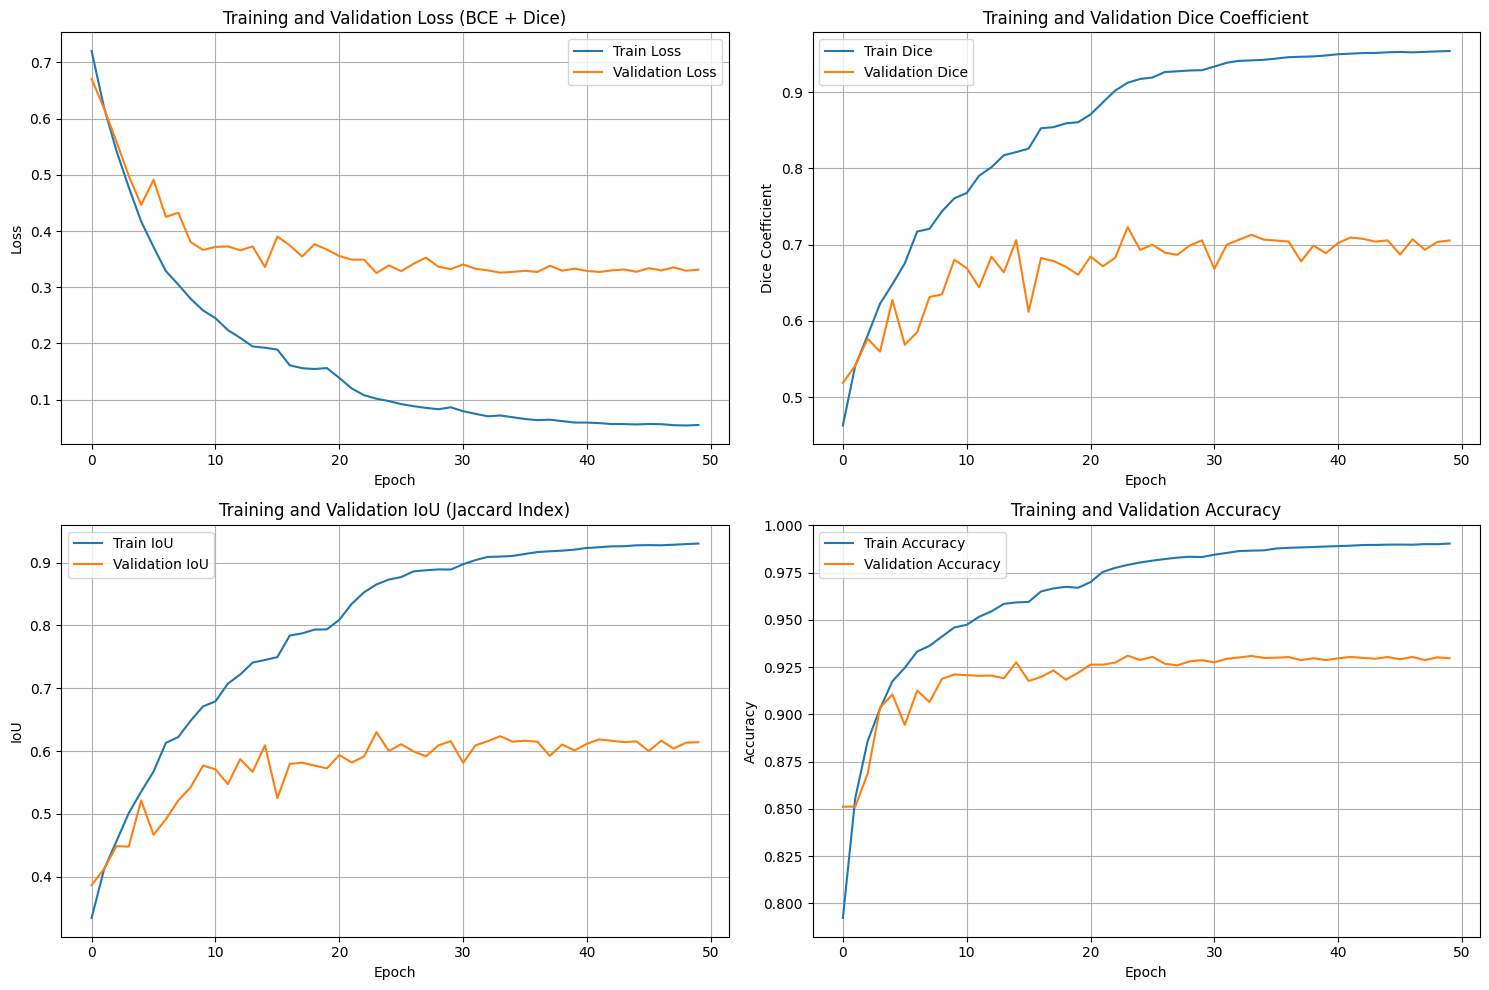

Training completed!
Best model saved as 'ducknet_attention_skip_connection_pytorch_best.pth'
Final model saved as 'ducknet_attention_skip_connection_pytorch_final.pth'


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from ducknet_attention_gate import create_attention_ducknet

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-6):
        super(FocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Apply sigmoid if not already
        if inputs.max() > 1:
            inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        TP = (inputs * targets).sum()
        FP = ((1 - targets) * inputs).sum()
        FN = (targets * (1 - inputs)).sum()

        Tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        FocalTversky = (1 - Tversky) ** self.gamma

        return FocalTversky

class KvasirDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, mask_transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.mask_transform = mask_transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        
        # Load mask
        mask = Image.open(self.mask_paths[idx]).convert('L')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        # Convert mask to binary (0 or 1)
        mask = (mask > 0.5).float()
        
        return image, mask

def dice_coefficient(pred, target, smooth=1e-6):
    """Calculate Dice coefficient"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    intersection = (pred * target).sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + smooth)
    return dice.mean()

def jaccard_index(pred, target, smooth=1e-6):
    """Calculate Jaccard Index (IoU)"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def precision_score(pred, target, smooth=1e-6):
    """Calculate Precision"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    true_positive = (pred * target).sum(dim=(2, 3))
    predicted_positive = pred.sum(dim=(2, 3))
    precision = (true_positive + smooth) / (predicted_positive + smooth)
    return precision.mean()

def recall_score(pred, target, smooth=1e-6):
    """Calculate Recall (Sensitivity)"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    true_positive = (pred * target).sum(dim=(2, 3))
    actual_positive = target.sum(dim=(2, 3))
    recall = (true_positive + smooth) / (actual_positive + smooth)
    return recall.mean()

def accuracy_score(pred, target):
    """Calculate Accuracy"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    correct = (pred == target).float()
    accuracy = correct.mean()
    return accuracy

def dice_loss(pred, target, smooth=1e-6):
    """Calculate Dice Loss"""
    return 1 - dice_coefficient(pred, target, smooth)

def prepare_data():
    """Prepare Kvasir dataset"""
    data_dir = "/kaggle/input/dataset/Kvasir-SEG/"
    images_dir = os.path.join(data_dir, "images")
    masks_dir = os.path.join(data_dir, "masks")
    
    # Get all image files
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    
    image_paths = []
    mask_paths = []
    
    for img_file in image_files:
        img_path = os.path.join(images_dir, img_file)
        mask_path = os.path.join(masks_dir, img_file)
        
        if os.path.exists(mask_path):
            image_paths.append(img_path)
            mask_paths.append(mask_path)
    
    print(f"Found {len(image_paths)} image-mask pairs")
    
    # Split dataset
    train_imgs, val_imgs, train_masks, val_masks = train_test_split(
        image_paths, mask_paths, test_size=0.2, random_state=42
    )
    
    return train_imgs, val_imgs, train_masks, val_masks

def create_data_loaders(train_imgs, val_imgs, train_masks, val_masks, batch_size=4):
    """Create PyTorch data loaders"""
    
    # Define transforms
    image_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    
    # Create datasets
    train_dataset = KvasirDataset(train_imgs, train_masks, image_transform, mask_transform)
    val_dataset = KvasirDataset(val_imgs, val_masks, image_transform, mask_transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, val_loader

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4):
    """Train the DuckNet Attention model"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = model.to(device)
    
    criterion = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=0.75)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    
    # Training history
    train_losses = []
    val_losses = []
    train_dices = []
    val_dices = []
    train_ious = []
    val_ious = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_dice = 0.0
    
    print("Starting training DuckNet with Attention...")
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        train_iou = 0.0
        train_precision = 0.0
        train_recall = 0.0
        train_accuracy = 0.0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (images, masks) in enumerate(train_pbar):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            # Calculate metrics
            dice = dice_coefficient(outputs, masks)
            iou = jaccard_index(outputs, masks)
            precision = precision_score(outputs, masks)
            recall = recall_score(outputs, masks)
            accuracy = accuracy_score(outputs, masks)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_dice += dice.item()
            train_iou += iou.item()
            train_precision += precision.item()
            train_recall += recall.item()
            train_accuracy += accuracy.item()
            
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Dice': f'{dice.item():.4f}',
                'IoU': f'{iou.item():.4f}'
            })
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_iou = 0.0
        val_precision = 0.0
        val_recall = 0.0
        val_accuracy = 0.0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, masks in val_pbar:
                images, masks = images.to(device), masks.to(device)
                
                outputs = model(images)
    
                loss = criterion(outputs, masks)
                
                # Calculate metrics
                dice = dice_coefficient(outputs, masks)
                iou = jaccard_index(outputs, masks)
                precision = precision_score(outputs, masks)
                recall = recall_score(outputs, masks)
                accuracy = accuracy_score(outputs, masks)
                
                val_loss += loss.item()
                val_dice += dice.item()
                val_iou += iou.item()
                val_precision += precision.item()
                val_recall += recall.item()
                val_accuracy += accuracy.item()
                
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Dice': f'{dice.item():.4f}',
                    'IoU': f'{iou.item():.4f}'
                })
        
        # Calculate average metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_train_dice = train_dice / len(train_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_train_iou = train_iou / len(train_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_train_precision = train_precision / len(train_loader)
        avg_val_precision = val_precision / len(val_loader)
        avg_train_recall = train_recall / len(train_loader)
        avg_val_recall = val_recall / len(val_loader)
        avg_train_accuracy = train_accuracy / len(train_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Save metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_dices.append(avg_train_dice)
        val_dices.append(avg_val_dice)
        train_ious.append(avg_train_iou)
        val_ious.append(avg_val_iou)
        train_precisions.append(avg_train_precision)
        val_precisions.append(avg_val_precision)
        train_recalls.append(avg_train_recall)
        val_recalls.append(avg_val_recall)
        train_accuracies.append(avg_train_accuracy)
        val_accuracies.append(avg_val_accuracy)
        
        epoch_time = time.time() - start_time
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train - Loss: {avg_train_loss:.4f}, Dice: {avg_train_dice:.4f}, IoU: {avg_train_iou:.4f}, Acc: {avg_train_accuracy:.4f}')
        print(f'  Val   - Loss: {avg_val_loss:.4f}, Dice: {avg_val_dice:.4f}, IoU: {avg_val_iou:.4f}, Acc: {avg_val_accuracy:.4f}')
        print(f'  Precision: Train={avg_train_precision:.4f}, Val={avg_val_precision:.4f}')
        print(f'  Recall   : Train={avg_train_recall:.4f}, Val={avg_val_recall:.4f}')
        print(f'  Time: {epoch_time:.2f}s')
        print('-' * 70)
        
        # Save best model
        if avg_val_dice > best_val_dice:
            best_val_dice = avg_val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': avg_val_dice,
                'val_loss': avg_val_loss,
            }, 'checkpoints/ducknet_attention_skip_connection_pytorch_best.pth')
            print(f'  New best model saved! Dice: {best_val_dice:.4f}')
    
    # Save final model
    torch.save({
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_dices': train_dices,
        'val_dices': val_dices,
        'train_ious': train_ious,
        'val_ious': val_ious,
        'train_precisions': train_precisions,
        'val_precisions': val_precisions,
        'train_recalls': train_recalls,
        'val_recalls': val_recalls,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
    }, 'checkpoints/ducknet_attention_skip_connection_pytorch_final.pth')
    
    return train_losses, val_losses, train_dices, val_dices, train_ious, val_ious, train_accuracies, val_accuracies

def plot_training_history(train_losses, val_losses, train_dices, val_dices, train_ious, val_ious, train_accuracies, val_accuracies):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot losses
    axes[0,0].plot(train_losses, label='Train Loss')
    axes[0,0].plot(val_losses, label='Validation Loss')
    axes[0,0].set_title('Training and Validation Loss (BCE + Dice)')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    # Plot dice coefficients
    axes[0,1].plot(train_dices, label='Train Dice')
    axes[0,1].plot(val_dices, label='Validation Dice')
    axes[0,1].set_title('Training and Validation Dice Coefficient')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Dice Coefficient')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # Plot IoU (Jaccard Index)
    axes[1,0].plot(train_ious, label='Train IoU')
    axes[1,0].plot(val_ious, label='Validation IoU')
    axes[1,0].set_title('Training and Validation IoU (Jaccard Index)')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('IoU')
    axes[1,0].legend()
    axes[1,0].grid(True)
    
    # Plot Accuracy
    axes[1,1].plot(train_accuracies, label='Train Accuracy')
    axes[1,1].plot(val_accuracies, label='Validation Accuracy')
    axes[1,1].set_title('Training and Validation Accuracy')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].legend()
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.savefig('logs/training_history_attention_skip_connection_pytorch.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    """Main training function"""
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Create directories if they don't exist
    os.makedirs('checkpoints', exist_ok=True)
    os.makedirs('logs', exist_ok=True)
    
    # Prepare data
    print("Preparing data...")
    train_imgs, val_imgs, train_masks, val_masks = prepare_data()
    
    # Create data loaders
    print("Creating data loaders...")
    train_loader, val_loader = create_data_loaders(
        train_imgs, val_imgs, train_masks, val_masks, batch_size=4
    )
    
    # Create model
    print("Creating DuckNet with Attention...")
    model = create_attention_ducknet(input_channels=3, num_classes=1)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Train model
    train_losses, val_losses, train_dices, val_dices, train_ious, val_ious, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4
    )
    
    # Plot training history
    plot_training_history(train_losses, val_losses, train_dices, val_dices, train_ious, val_ious, train_accuracies, val_accuracies)
    
    print("Training completed!")
    print("Best model saved as 'ducknet_attention_skip_connection_pytorch_best.pth'")
    print("Final model saved as 'ducknet_attention_skip_connection_pytorch_final.pth'")

if __name__ == "__main__":
    main() 

# Training Ducknet với attention trong tất cả các lớp

Preparing data...
Found 1000 image-mask pairs
Creating data loaders...
Creating DuckNet with Attention Gates...
Total parameters: 10,117,119
Trainable parameters: 10,117,119
Using device: cuda
Starting training DuckNet with Attention Gates...


Epoch 1/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.60it/s, Loss=0.7705, Dice=0.4412, IoU=0.3020]


Epoch 1/50:
  Train - Loss: 0.7875, Dice: 0.4355, IoU: 0.3090, Acc: 0.7159
  Val   - Loss: 0.7530, Dice: 0.4741, IoU: 0.3399, Acc: 0.7708
  Precision: Train=0.3487, Val=0.3927
  Recall   : Train=0.8398, Val=0.8394
  Time: 58.16s
----------------------------------------------------------------------
  New best model saved! Dice: 0.4741


Epoch 2/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.04it/s, Loss=0.6947, Dice=0.5485, IoU=0.4433]


Epoch 2/50:
  Train - Loss: 0.7058, Dice: 0.5303, IoU: 0.3971, Acc: 0.8218
  Val   - Loss: 0.6880, Dice: 0.5605, IoU: 0.4289, Acc: 0.8517
  Precision: Train=0.4629, Val=0.5207
  Recall   : Train=0.8346, Val=0.7946
  Time: 60.45s
----------------------------------------------------------------------
  New best model saved! Dice: 0.5605


Epoch 3/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.32it/s, Loss=0.6141, Dice=0.6633, IoU=0.5273]


Epoch 3/50:
  Train - Loss: 0.6434, Dice: 0.5802, IoU: 0.4518, Acc: 0.8664
  Val   - Loss: 0.6183, Dice: 0.6026, IoU: 0.4742, Acc: 0.8790
  Precision: Train=0.5484, Val=0.5843
  Recall   : Train=0.7900, Val=0.7798
  Time: 62.98s
----------------------------------------------------------------------
  New best model saved! Dice: 0.6026


Epoch 4/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.23it/s, Loss=0.5324, Dice=0.6829, IoU=0.5402]


Epoch 4/50:
  Train - Loss: 0.5707, Dice: 0.6245, IoU: 0.4999, Acc: 0.8942
  Val   - Loss: 0.5825, Dice: 0.5933, IoU: 0.4672, Acc: 0.9011
  Precision: Train=0.6276, Val=0.7212
  Recall   : Train=0.7644, Val=0.6020
  Time: 62.51s
----------------------------------------------------------------------


Epoch 5/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.23it/s, Loss=0.3899, Dice=0.7959, IoU=0.6825]


Epoch 5/50:
  Train - Loss: 0.5074, Dice: 0.6648, IoU: 0.5437, Acc: 0.9098
  Val   - Loss: 0.5097, Dice: 0.6516, IoU: 0.5279, Acc: 0.9105
  Precision: Train=0.6902, Val=0.7653
  Recall   : Train=0.7671, Val=0.6536
  Time: 62.19s
----------------------------------------------------------------------
  New best model saved! Dice: 0.6516


Epoch 6/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.15it/s, Loss=0.4055, Dice=0.8146, IoU=0.6939]


Epoch 6/50:
  Train - Loss: 0.4403, Dice: 0.7068, IoU: 0.5920, Acc: 0.9242
  Val   - Loss: 0.4798, Dice: 0.6780, IoU: 0.5610, Acc: 0.9108
  Precision: Train=0.7546, Val=0.7405
  Recall   : Train=0.7654, Val=0.7221
  Time: 62.63s
----------------------------------------------------------------------
  New best model saved! Dice: 0.6780


Epoch 7/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.20it/s, Loss=0.3828, Dice=0.7582, IoU=0.6305]


Epoch 7/50:
  Train - Loss: 0.3840, Dice: 0.7319, IoU: 0.6218, Acc: 0.9332
  Val   - Loss: 0.4488, Dice: 0.6511, IoU: 0.5436, Acc: 0.9125
  Precision: Train=0.7954, Val=0.8121
  Recall   : Train=0.7597, Val=0.6563
  Time: 62.26s
----------------------------------------------------------------------


Epoch 8/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.21it/s, Loss=0.2327, Dice=0.8806, IoU=0.7942]


Epoch 8/50:
  Train - Loss: 0.3481, Dice: 0.7477, IoU: 0.6441, Acc: 0.9372
  Val   - Loss: 0.4728, Dice: 0.6418, IoU: 0.5259, Acc: 0.8996
  Precision: Train=0.8263, Val=0.7141
  Recall   : Train=0.7610, Val=0.6991
  Time: 62.58s
----------------------------------------------------------------------


Epoch 9/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.20it/s, Loss=0.3022, Dice=0.8391, IoU=0.7295]


Epoch 9/50:
  Train - Loss: 0.3182, Dice: 0.7606, IoU: 0.6597, Acc: 0.9413
  Val   - Loss: 0.4019, Dice: 0.6824, IoU: 0.5771, Acc: 0.9171
  Precision: Train=0.8470, Val=0.8007
  Recall   : Train=0.7596, Val=0.6834
  Time: 62.49s
----------------------------------------------------------------------
  New best model saved! Dice: 0.6824


Epoch 10/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.26it/s, Loss=0.4182, Dice=0.7971, IoU=0.6893]


Epoch 10/50:
  Train - Loss: 0.2876, Dice: 0.7776, IoU: 0.6801, Acc: 0.9459
  Val   - Loss: 0.4205, Dice: 0.6694, IoU: 0.5633, Acc: 0.9087
  Precision: Train=0.8622, Val=0.7767
  Recall   : Train=0.7707, Val=0.7057
  Time: 62.25s
----------------------------------------------------------------------


Epoch 11/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.20it/s, Loss=0.4096, Dice=0.7651, IoU=0.6426]


Epoch 11/50:
  Train - Loss: 0.2547, Dice: 0.7990, IoU: 0.7076, Acc: 0.9525
  Val   - Loss: 0.3844, Dice: 0.7010, IoU: 0.5977, Acc: 0.9170
  Precision: Train=0.8880, Val=0.8317
  Recall   : Train=0.7823, Val=0.7076
  Time: 62.62s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7010


Epoch 12/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.07it/s, Loss=0.2268, Dice=0.8518, IoU=0.7509]


Epoch 12/50:
  Train - Loss: 0.2388, Dice: 0.7946, IoU: 0.7069, Acc: 0.9541
  Val   - Loss: 0.3663, Dice: 0.7113, IoU: 0.6104, Acc: 0.9209
  Precision: Train=0.8990, Val=0.8052
  Recall   : Train=0.7682, Val=0.7386
  Time: 62.23s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7113


Epoch 13/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.15it/s, Loss=0.3641, Dice=0.8135, IoU=0.7046]


Epoch 13/50:
  Train - Loss: 0.2199, Dice: 0.8203, IoU: 0.7338, Acc: 0.9580
  Val   - Loss: 0.3726, Dice: 0.7121, IoU: 0.6092, Acc: 0.9199
  Precision: Train=0.9023, Val=0.7875
  Recall   : Train=0.7986, Val=0.7522
  Time: 62.42s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7121


Epoch 14/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.10it/s, Loss=0.1982, Dice=0.8794, IoU=0.7907]


Epoch 14/50:
  Train - Loss: 0.2020, Dice: 0.8302, IoU: 0.7478, Acc: 0.9615
  Val   - Loss: 0.3436, Dice: 0.7241, IoU: 0.6282, Acc: 0.9248
  Precision: Train=0.9179, Val=0.8292
  Recall   : Train=0.8031, Val=0.7251
  Time: 62.65s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7241


Epoch 15/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.10it/s, Loss=0.1455, Dice=0.9205, IoU=0.8533]


Epoch 15/50:
  Train - Loss: 0.1902, Dice: 0.8430, IoU: 0.7615, Acc: 0.9639
  Val   - Loss: 0.3519, Dice: 0.7083, IoU: 0.6132, Acc: 0.9221
  Precision: Train=0.9193, Val=0.8413
  Recall   : Train=0.8151, Val=0.7125
  Time: 62.49s
----------------------------------------------------------------------


Epoch 16/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.18it/s, Loss=0.3941, Dice=0.6140, IoU=0.5371]


Epoch 16/50:
  Train - Loss: 0.1896, Dice: 0.8436, IoU: 0.7657, Acc: 0.9631
  Val   - Loss: 0.3365, Dice: 0.7125, IoU: 0.6186, Acc: 0.9258
  Precision: Train=0.9241, Val=0.8584
  Recall   : Train=0.8146, Val=0.7063
  Time: 62.16s
----------------------------------------------------------------------


Epoch 17/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.24it/s, Loss=0.1825, Dice=0.8853, IoU=0.7993]


Epoch 17/50:
  Train - Loss: 0.1758, Dice: 0.8579, IoU: 0.7814, Acc: 0.9667
  Val   - Loss: 0.3452, Dice: 0.7134, IoU: 0.6146, Acc: 0.9226
  Precision: Train=0.9350, Val=0.8407
  Recall   : Train=0.8278, Val=0.7223
  Time: 62.44s
----------------------------------------------------------------------


Epoch 18/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.16it/s, Loss=0.1341, Dice=0.9074, IoU=0.8338]


Epoch 18/50:
  Train - Loss: 0.1610, Dice: 0.8653, IoU: 0.7916, Acc: 0.9686
  Val   - Loss: 0.3585, Dice: 0.6675, IoU: 0.5686, Acc: 0.9203
  Precision: Train=0.9423, Val=0.9016
  Recall   : Train=0.8347, Val=0.6062
  Time: 62.43s
----------------------------------------------------------------------


Epoch 19/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.12it/s, Loss=0.2263, Dice=0.8351, IoU=0.7309]


Epoch 19/50:
  Train - Loss: 0.1595, Dice: 0.8702, IoU: 0.7985, Acc: 0.9698
  Val   - Loss: 0.3336, Dice: 0.7204, IoU: 0.6214, Acc: 0.9250
  Precision: Train=0.9412, Val=0.8481
  Recall   : Train=0.8389, Val=0.7169
  Time: 62.38s
----------------------------------------------------------------------


Epoch 20/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.18it/s, Loss=0.1510, Dice=0.9075, IoU=0.8336]


Epoch 20/50:
  Train - Loss: 0.1466, Dice: 0.8778, IoU: 0.8098, Acc: 0.9724
  Val   - Loss: 0.3413, Dice: 0.7037, IoU: 0.6130, Acc: 0.9238
  Precision: Train=0.9482, Val=0.8444
  Recall   : Train=0.8462, Val=0.7033
  Time: 62.29s
----------------------------------------------------------------------


Epoch 21/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.20it/s, Loss=0.1536, Dice=0.8974, IoU=0.8180]


Epoch 21/50:
  Train - Loss: 0.1331, Dice: 0.8863, IoU: 0.8222, Acc: 0.9750
  Val   - Loss: 0.3375, Dice: 0.7194, IoU: 0.6281, Acc: 0.9254
  Precision: Train=0.9541, Val=0.8568
  Recall   : Train=0.8527, Val=0.7178
  Time: 62.52s
----------------------------------------------------------------------


Epoch 22/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.18it/s, Loss=0.1553, Dice=0.8815, IoU=0.7972]


Epoch 22/50:
  Train - Loss: 0.1497, Dice: 0.8726, IoU: 0.8031, Acc: 0.9710
  Val   - Loss: 0.3284, Dice: 0.7132, IoU: 0.6200, Acc: 0.9273
  Precision: Train=0.9453, Val=0.8898
  Recall   : Train=0.8408, Val=0.6731
  Time: 62.64s
----------------------------------------------------------------------


Epoch 23/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.19it/s, Loss=0.3737, Dice=0.7908, IoU=0.6723]


Epoch 23/50:
  Train - Loss: 0.1495, Dice: 0.8795, IoU: 0.8105, Acc: 0.9710
  Val   - Loss: 0.3776, Dice: 0.7069, IoU: 0.6088, Acc: 0.9160
  Precision: Train=0.9414, Val=0.7786
  Recall   : Train=0.8502, Val=0.7598
  Time: 62.31s
----------------------------------------------------------------------


Epoch 24/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.14it/s, Loss=0.1685, Dice=0.8763, IoU=0.7867]


Epoch 24/50:
  Train - Loss: 0.1474, Dice: 0.8786, IoU: 0.8104, Acc: 0.9722
  Val   - Loss: 0.3274, Dice: 0.7483, IoU: 0.6560, Acc: 0.9281
  Precision: Train=0.9447, Val=0.8313
  Recall   : Train=0.8478, Val=0.7592
  Time: 62.67s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7483


Epoch 25/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.23it/s, Loss=0.2141, Dice=0.8764, IoU=0.7865]


Epoch 25/50:
  Train - Loss: 0.1360, Dice: 0.8894, IoU: 0.8236, Acc: 0.9745
  Val   - Loss: 0.3291, Dice: 0.7340, IoU: 0.6373, Acc: 0.9270
  Precision: Train=0.9509, Val=0.8349
  Recall   : Train=0.8590, Val=0.7388
  Time: 62.30s
----------------------------------------------------------------------


Epoch 26/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.19it/s, Loss=0.2524, Dice=0.8619, IoU=0.7666]


Epoch 26/50:
  Train - Loss: 0.1137, Dice: 0.9052, IoU: 0.8474, Acc: 0.9787
  Val   - Loss: 0.3271, Dice: 0.7273, IoU: 0.6330, Acc: 0.9281
  Precision: Train=0.9641, Val=0.8530
  Recall   : Train=0.8747, Val=0.7239
  Time: 62.33s
----------------------------------------------------------------------


Epoch 27/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.17it/s, Loss=0.3338, Dice=0.8364, IoU=0.7403]


Epoch 27/50:
  Train - Loss: 0.1047, Dice: 0.9146, IoU: 0.8615, Acc: 0.9812
  Val   - Loss: 0.3219, Dice: 0.7497, IoU: 0.6582, Acc: 0.9291
  Precision: Train=0.9663, Val=0.8419
  Recall   : Train=0.8858, Val=0.7613
  Time: 62.43s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7497


Epoch 28/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.15it/s, Loss=0.1879, Dice=0.8851, IoU=0.7993]


Epoch 28/50:
  Train - Loss: 0.1083, Dice: 0.9122, IoU: 0.8578, Acc: 0.9801
  Val   - Loss: 0.3233, Dice: 0.7516, IoU: 0.6552, Acc: 0.9297
  Precision: Train=0.9654, Val=0.8335
  Recall   : Train=0.8844, Val=0.7678
  Time: 62.49s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7516


Epoch 29/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.18it/s, Loss=0.1922, Dice=0.8840, IoU=0.7956]


Epoch 29/50:
  Train - Loss: 0.1001, Dice: 0.9190, IoU: 0.8678, Acc: 0.9817
  Val   - Loss: 0.3125, Dice: 0.7475, IoU: 0.6523, Acc: 0.9315
  Precision: Train=0.9696, Val=0.8684
  Recall   : Train=0.8903, Val=0.7445
  Time: 62.56s
----------------------------------------------------------------------


Epoch 30/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.27it/s, Loss=0.1632, Dice=0.8950, IoU=0.8137]


Epoch 30/50:
  Train - Loss: 0.0957, Dice: 0.9231, IoU: 0.8742, Acc: 0.9831
  Val   - Loss: 0.3083, Dice: 0.7556, IoU: 0.6614, Acc: 0.9312
  Precision: Train=0.9730, Val=0.8784
  Recall   : Train=0.8945, Val=0.7290
  Time: 62.44s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7556


Epoch 31/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.21it/s, Loss=0.3645, Dice=0.7629, IoU=0.6373]


Epoch 31/50:
  Train - Loss: 0.1119, Dice: 0.9065, IoU: 0.8503, Acc: 0.9791
  Val   - Loss: 0.3363, Dice: 0.7391, IoU: 0.6400, Acc: 0.9255
  Precision: Train=0.9579, Val=0.8362
  Recall   : Train=0.8791, Val=0.7453
  Time: 62.57s
----------------------------------------------------------------------


Epoch 32/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.19it/s, Loss=0.3629, Dice=0.8314, IoU=0.7391]


Epoch 32/50:
  Train - Loss: 0.1039, Dice: 0.9143, IoU: 0.8613, Acc: 0.9813
  Val   - Loss: 0.3355, Dice: 0.7438, IoU: 0.6496, Acc: 0.9261
  Precision: Train=0.9655, Val=0.8209
  Recall   : Train=0.8831, Val=0.7699
  Time: 62.28s
----------------------------------------------------------------------


Epoch 33/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.12it/s, Loss=0.2931, Dice=0.8357, IoU=0.7212]


Epoch 33/50:
  Train - Loss: 0.1031, Dice: 0.9176, IoU: 0.8652, Acc: 0.9813
  Val   - Loss: 0.3167, Dice: 0.7446, IoU: 0.6513, Acc: 0.9300
  Precision: Train=0.9689, Val=0.8638
  Recall   : Train=0.8883, Val=0.7291
  Time: 62.47s
----------------------------------------------------------------------


Epoch 34/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.22it/s, Loss=0.3447, Dice=0.8148, IoU=0.7028]


Epoch 34/50:
  Train - Loss: 0.0936, Dice: 0.9223, IoU: 0.8734, Acc: 0.9834
  Val   - Loss: 0.3311, Dice: 0.7467, IoU: 0.6502, Acc: 0.9266
  Precision: Train=0.9738, Val=0.8546
  Recall   : Train=0.8939, Val=0.7495
  Time: 62.38s
----------------------------------------------------------------------


Epoch 35/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.21it/s, Loss=0.1465, Dice=0.9164, IoU=0.8483]


Epoch 35/50:
  Train - Loss: 0.0956, Dice: 0.9221, IoU: 0.8721, Acc: 0.9828
  Val   - Loss: 0.3263, Dice: 0.7594, IoU: 0.6644, Acc: 0.9287
  Precision: Train=0.9715, Val=0.8201
  Recall   : Train=0.8923, Val=0.7844
  Time: 62.55s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7594


Epoch 36/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.16it/s, Loss=0.1742, Dice=0.8987, IoU=0.8200]


Epoch 36/50:
  Train - Loss: 0.0901, Dice: 0.9248, IoU: 0.8772, Acc: 0.9837
  Val   - Loss: 0.3228, Dice: 0.7519, IoU: 0.6588, Acc: 0.9302
  Precision: Train=0.9726, Val=0.8425
  Recall   : Train=0.8967, Val=0.7618
  Time: 62.40s
----------------------------------------------------------------------


Epoch 37/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.21it/s, Loss=0.1688, Dice=0.8984, IoU=0.8184]


Epoch 37/50:
  Train - Loss: 0.0870, Dice: 0.9274, IoU: 0.8819, Acc: 0.9848
  Val   - Loss: 0.3118, Dice: 0.7561, IoU: 0.6642, Acc: 0.9307
  Precision: Train=0.9745, Val=0.8629
  Recall   : Train=0.8998, Val=0.7474
  Time: 62.49s
----------------------------------------------------------------------


Epoch 38/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.19it/s, Loss=0.2046, Dice=0.8725, IoU=0.7798]


Epoch 38/50:
  Train - Loss: 0.0749, Dice: 0.9372, IoU: 0.8972, Acc: 0.9873
  Val   - Loss: 0.3098, Dice: 0.7688, IoU: 0.6766, Acc: 0.9317
  Precision: Train=0.9814, Val=0.8461
  Recall   : Train=0.9117, Val=0.7777
  Time: 62.65s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7688


Epoch 39/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.13it/s, Loss=0.2069, Dice=0.8807, IoU=0.7913]


Epoch 39/50:
  Train - Loss: 0.0705, Dice: 0.9412, IoU: 0.9034, Acc: 0.9883
  Val   - Loss: 0.3212, Dice: 0.7633, IoU: 0.6721, Acc: 0.9296
  Precision: Train=0.9833, Val=0.8339
  Recall   : Train=0.9173, Val=0.7875
  Time: 62.33s
----------------------------------------------------------------------


Epoch 40/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.23it/s, Loss=0.1721, Dice=0.8971, IoU=0.8163]


Epoch 40/50:
  Train - Loss: 0.0723, Dice: 0.9426, IoU: 0.9057, Acc: 0.9884
  Val   - Loss: 0.3160, Dice: 0.7742, IoU: 0.6810, Acc: 0.9314
  Precision: Train=0.9833, Val=0.8339
  Recall   : Train=0.9199, Val=0.7948
  Time: 62.61s
----------------------------------------------------------------------
  New best model saved! Dice: 0.7742


Epoch 41/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.18it/s, Loss=0.2300, Dice=0.8527, IoU=0.7516]


Epoch 41/50:
  Train - Loss: 0.0669, Dice: 0.9455, IoU: 0.9104, Acc: 0.9893
  Val   - Loss: 0.3146, Dice: 0.7642, IoU: 0.6725, Acc: 0.9316
  Precision: Train=0.9841, Val=0.8509
  Recall   : Train=0.9226, Val=0.7724
  Time: 62.45s
----------------------------------------------------------------------


Epoch 42/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.18it/s, Loss=0.2239, Dice=0.8581, IoU=0.7586]


Epoch 42/50:
  Train - Loss: 0.0642, Dice: 0.9479, IoU: 0.9143, Acc: 0.9899
  Val   - Loss: 0.3154, Dice: 0.7636, IoU: 0.6697, Acc: 0.9314
  Precision: Train=0.9852, Val=0.8441
  Recall   : Train=0.9258, Val=0.7748
  Time: 62.60s
----------------------------------------------------------------------


Epoch 43/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.15it/s, Loss=0.1764, Dice=0.8915, IoU=0.8081]


Epoch 43/50:
  Train - Loss: 0.0625, Dice: 0.9489, IoU: 0.9167, Acc: 0.9902
  Val   - Loss: 0.3113, Dice: 0.7578, IoU: 0.6647, Acc: 0.9313
  Precision: Train=0.9876, Val=0.8535
  Recall   : Train=0.9276, Val=0.7534
  Time: 62.54s
----------------------------------------------------------------------


Epoch 44/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.17it/s, Loss=0.1989, Dice=0.8778, IoU=0.7869]


Epoch 44/50:
  Train - Loss: 0.0599, Dice: 0.9509, IoU: 0.9197, Acc: 0.9905
  Val   - Loss: 0.3177, Dice: 0.7644, IoU: 0.6712, Acc: 0.9304
  Precision: Train=0.9881, Val=0.8424
  Recall   : Train=0.9300, Val=0.7785
  Time: 62.50s
----------------------------------------------------------------------


Epoch 45/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.13it/s, Loss=0.1616, Dice=0.9026, IoU=0.8253]


Epoch 45/50:
  Train - Loss: 0.0621, Dice: 0.9504, IoU: 0.9191, Acc: 0.9905
  Val   - Loss: 0.3129, Dice: 0.7551, IoU: 0.6615, Acc: 0.9304
  Precision: Train=0.9861, Val=0.8620
  Recall   : Train=0.9298, Val=0.7493
  Time: 62.35s
----------------------------------------------------------------------


Epoch 46/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.23it/s, Loss=0.2041, Dice=0.8711, IoU=0.7765]


Epoch 46/50:
  Train - Loss: 0.0584, Dice: 0.9510, IoU: 0.9208, Acc: 0.9910
  Val   - Loss: 0.3132, Dice: 0.7502, IoU: 0.6556, Acc: 0.9303
  Precision: Train=0.9885, Val=0.8722
  Recall   : Train=0.9306, Val=0.7402
  Time: 62.53s
----------------------------------------------------------------------


Epoch 47/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.20it/s, Loss=0.2165, Dice=0.8590, IoU=0.7611]


Epoch 47/50:
  Train - Loss: 0.0560, Dice: 0.9524, IoU: 0.9226, Acc: 0.9911
  Val   - Loss: 0.3065, Dice: 0.7593, IoU: 0.6650, Acc: 0.9323
  Precision: Train=0.9886, Val=0.8619
  Recall   : Train=0.9324, Val=0.7558
  Time: 62.36s
----------------------------------------------------------------------


Epoch 48/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.15it/s, Loss=0.2235, Dice=0.8601, IoU=0.7606]


Epoch 48/50:
  Train - Loss: 0.0577, Dice: 0.9537, IoU: 0.9246, Acc: 0.9914
  Val   - Loss: 0.3192, Dice: 0.7548, IoU: 0.6594, Acc: 0.9295
  Precision: Train=0.9864, Val=0.8400
  Recall   : Train=0.9343, Val=0.7620
  Time: 62.58s
----------------------------------------------------------------------


Epoch 49/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.19it/s, Loss=0.2067, Dice=0.8674, IoU=0.7708]


Epoch 49/50:
  Train - Loss: 0.0560, Dice: 0.9543, IoU: 0.9258, Acc: 0.9916
  Val   - Loss: 0.3172, Dice: 0.7486, IoU: 0.6537, Acc: 0.9294
  Precision: Train=0.9865, Val=0.8491
  Recall   : Train=0.9351, Val=0.7475
  Time: 62.55s
----------------------------------------------------------------------


Epoch 50/50 [Val]: 100%|██████████| 50/50 [00:04<00:00, 10.19it/s, Loss=0.2421, Dice=0.8550, IoU=0.7506]


Epoch 50/50:
  Train - Loss: 0.0541, Dice: 0.9543, IoU: 0.9264, Acc: 0.9918
  Val   - Loss: 0.3185, Dice: 0.7612, IoU: 0.6654, Acc: 0.9293
  Precision: Train=0.9894, Val=0.8343
  Recall   : Train=0.9356, Val=0.7762
  Time: 62.48s
----------------------------------------------------------------------


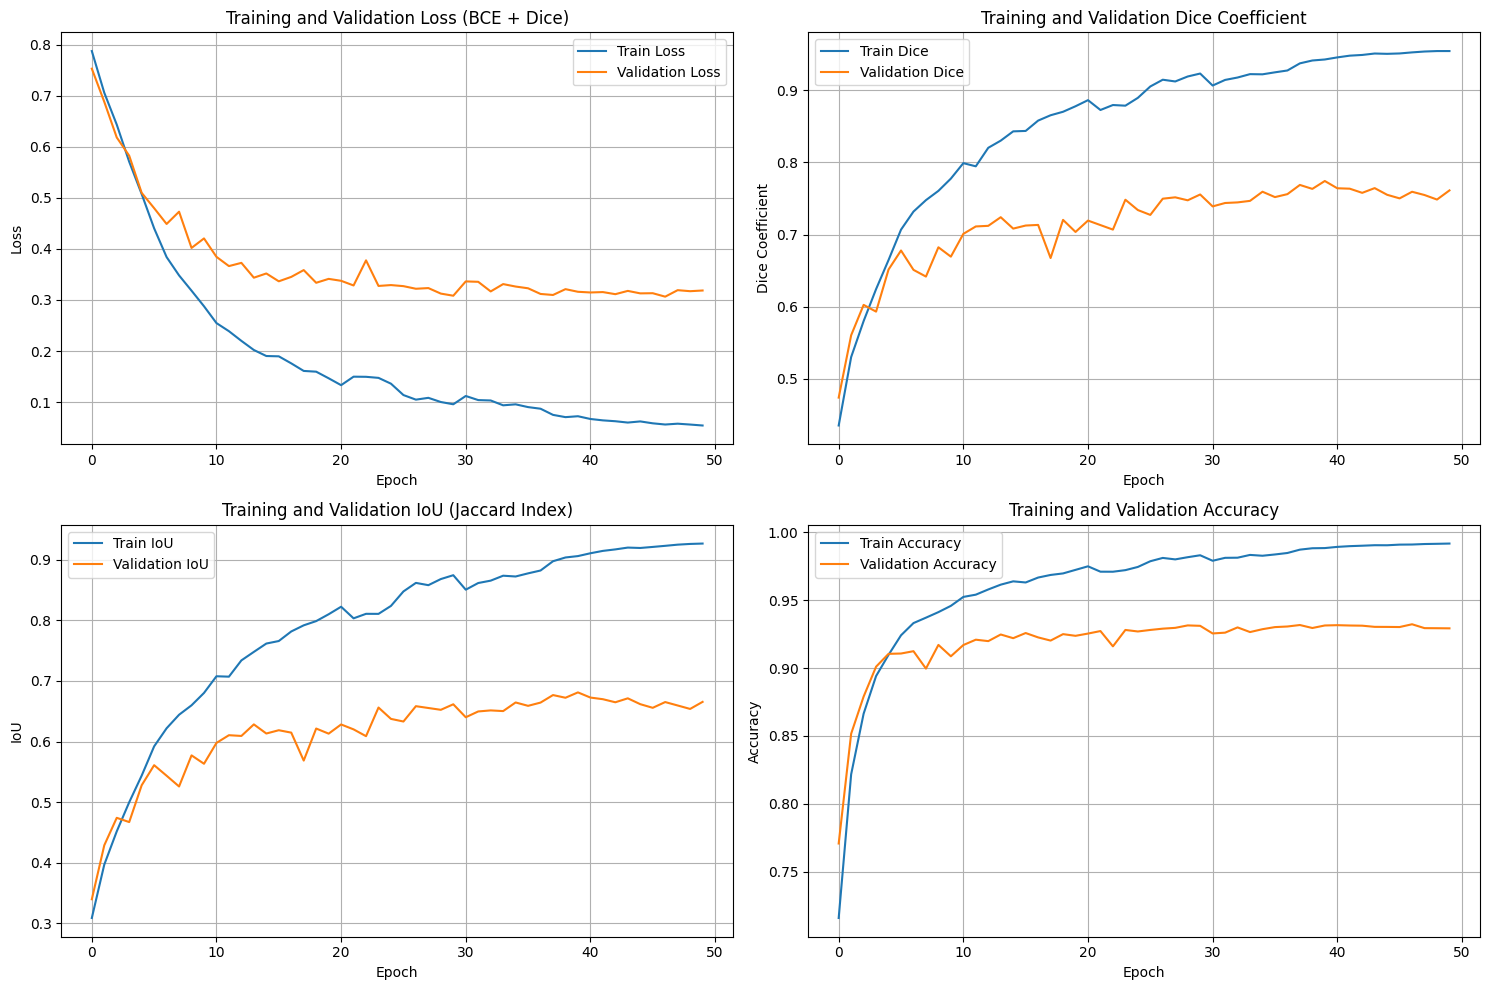

Training completed!
Best model saved as 'ducknet_attention_pytorch_best.pth'
Final model saved as 'ducknet_attention_pytorch_final.pth'


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from ducknet_attention import create_attention_ducknet

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-6):
        super(FocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Apply sigmoid if not already
        if inputs.max() > 1:
            inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        TP = (inputs * targets).sum()
        FP = ((1 - targets) * inputs).sum()
        FN = (targets * (1 - inputs)).sum()

        Tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        FocalTversky = (1 - Tversky) ** self.gamma

        return FocalTversky

class KvasirDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, mask_transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.mask_transform = mask_transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        
        # Load mask
        mask = Image.open(self.mask_paths[idx]).convert('L')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        # Convert mask to binary (0 or 1)
        mask = (mask > 0.5).float()
        
        return image, mask

def dice_coefficient(pred, target, smooth=1e-6):
    """Calculate Dice coefficient"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    intersection = (pred * target).sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + smooth)
    return dice.mean()

def jaccard_index(pred, target, smooth=1e-6):
    """Calculate Jaccard Index (IoU)"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def precision_score(pred, target, smooth=1e-6):
    """Calculate Precision"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    true_positive = (pred * target).sum(dim=(2, 3))
    predicted_positive = pred.sum(dim=(2, 3))
    precision = (true_positive + smooth) / (predicted_positive + smooth)
    return precision.mean()

def recall_score(pred, target, smooth=1e-6):
    """Calculate Recall (Sensitivity)"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    true_positive = (pred * target).sum(dim=(2, 3))
    actual_positive = target.sum(dim=(2, 3))
    recall = (true_positive + smooth) / (actual_positive + smooth)
    return recall.mean()

def accuracy_score(pred, target):
    """Calculate Accuracy"""
    pred = torch.sigmoid(pred) if pred.max() > 1 else pred
    pred = (pred > 0.5).float()
    
    correct = (pred == target).float()
    accuracy = correct.mean()
    return accuracy

def dice_loss(pred, target, smooth=1e-6):
    """Calculate Dice Loss"""
    return 1 - dice_coefficient(pred, target, smooth)

def prepare_data():
    """Prepare Kvasir dataset"""
    data_dir = "/kaggle/input/dataset/Kvasir-SEG/"
    images_dir = os.path.join(data_dir, "images")
    masks_dir = os.path.join(data_dir, "masks")
    
    # Get all image files
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    
    image_paths = []
    mask_paths = []
    
    for img_file in image_files:
        img_path = os.path.join(images_dir, img_file)
        mask_path = os.path.join(masks_dir, img_file)
        
        if os.path.exists(mask_path):
            image_paths.append(img_path)
            mask_paths.append(mask_path)
    
    print(f"Found {len(image_paths)} image-mask pairs")
    
    # Split dataset
    train_imgs, val_imgs, train_masks, val_masks = train_test_split(
        image_paths, mask_paths, test_size=0.2, random_state=42
    )
    
    return train_imgs, val_imgs, train_masks, val_masks

def create_data_loaders(train_imgs, val_imgs, train_masks, val_masks, batch_size=4):
    """Create PyTorch data loaders"""
    
    # Define transforms
    image_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    
    # Create datasets
    train_dataset = KvasirDataset(train_imgs, train_masks, image_transform, mask_transform)
    val_dataset = KvasirDataset(val_imgs, val_masks, image_transform, mask_transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, val_loader

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4):
    """Train the DuckNet Attention model"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = model.to(device)
    
    criterion = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=0.75)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    
    # Training history
    train_losses = []
    val_losses = []
    train_dices = []
    val_dices = []
    train_ious = []
    val_ious = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_dice = 0.0
    
    print("Starting training DuckNet with Attention Gates...")
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        train_iou = 0.0
        train_precision = 0.0
        train_recall = 0.0
        train_accuracy = 0.0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (images, masks) in enumerate(train_pbar):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            # Calculate metrics
            dice = dice_coefficient(outputs, masks)
            iou = jaccard_index(outputs, masks)
            precision = precision_score(outputs, masks)
            recall = recall_score(outputs, masks)
            accuracy = accuracy_score(outputs, masks)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_dice += dice.item()
            train_iou += iou.item()
            train_precision += precision.item()
            train_recall += recall.item()
            train_accuracy += accuracy.item()
            
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Dice': f'{dice.item():.4f}',
                'IoU': f'{iou.item():.4f}'
            })
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_iou = 0.0
        val_precision = 0.0
        val_recall = 0.0
        val_accuracy = 0.0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, masks in val_pbar:
                images, masks = images.to(device), masks.to(device)
                
                outputs = model(images)
    
                loss = criterion(outputs, masks)
                
                # Calculate metrics
                dice = dice_coefficient(outputs, masks)
                iou = jaccard_index(outputs, masks)
                precision = precision_score(outputs, masks)
                recall = recall_score(outputs, masks)
                accuracy = accuracy_score(outputs, masks)
                
                val_loss += loss.item()
                val_dice += dice.item()
                val_iou += iou.item()
                val_precision += precision.item()
                val_recall += recall.item()
                val_accuracy += accuracy.item()
                
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Dice': f'{dice.item():.4f}',
                    'IoU': f'{iou.item():.4f}'
                })
        
        # Calculate average metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_train_dice = train_dice / len(train_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_train_iou = train_iou / len(train_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_train_precision = train_precision / len(train_loader)
        avg_val_precision = val_precision / len(val_loader)
        avg_train_recall = train_recall / len(train_loader)
        avg_val_recall = val_recall / len(val_loader)
        avg_train_accuracy = train_accuracy / len(train_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Save metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_dices.append(avg_train_dice)
        val_dices.append(avg_val_dice)
        train_ious.append(avg_train_iou)
        val_ious.append(avg_val_iou)
        train_precisions.append(avg_train_precision)
        val_precisions.append(avg_val_precision)
        train_recalls.append(avg_train_recall)
        val_recalls.append(avg_val_recall)
        train_accuracies.append(avg_train_accuracy)
        val_accuracies.append(avg_val_accuracy)
        
        epoch_time = time.time() - start_time
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train - Loss: {avg_train_loss:.4f}, Dice: {avg_train_dice:.4f}, IoU: {avg_train_iou:.4f}, Acc: {avg_train_accuracy:.4f}')
        print(f'  Val   - Loss: {avg_val_loss:.4f}, Dice: {avg_val_dice:.4f}, IoU: {avg_val_iou:.4f}, Acc: {avg_val_accuracy:.4f}')
        print(f'  Precision: Train={avg_train_precision:.4f}, Val={avg_val_precision:.4f}')
        print(f'  Recall   : Train={avg_train_recall:.4f}, Val={avg_val_recall:.4f}')
        print(f'  Time: {epoch_time:.2f}s')
        print('-' * 70)
        
        # Save best model
        if avg_val_dice > best_val_dice:
            best_val_dice = avg_val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': avg_val_dice,
                'val_loss': avg_val_loss,
            }, 'checkpoints/ducknet_attention_pytorch_best.pth')
            print(f'  New best model saved! Dice: {best_val_dice:.4f}')
    
    # Save final model
    torch.save({
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_dices': train_dices,
        'val_dices': val_dices,
        'train_ious': train_ious,
        'val_ious': val_ious,
        'train_precisions': train_precisions,
        'val_precisions': val_precisions,
        'train_recalls': train_recalls,
        'val_recalls': val_recalls,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
    }, 'checkpoints/ducknet_attention_pytorch_final.pth')
    
    return train_losses, val_losses, train_dices, val_dices, train_ious, val_ious, train_accuracies, val_accuracies

def plot_training_history(train_losses, val_losses, train_dices, val_dices, train_ious, val_ious, train_accuracies, val_accuracies):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot losses
    axes[0,0].plot(train_losses, label='Train Loss')
    axes[0,0].plot(val_losses, label='Validation Loss')
    axes[0,0].set_title('Training and Validation Loss (BCE + Dice)')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    # Plot dice coefficients
    axes[0,1].plot(train_dices, label='Train Dice')
    axes[0,1].plot(val_dices, label='Validation Dice')
    axes[0,1].set_title('Training and Validation Dice Coefficient')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Dice Coefficient')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # Plot IoU (Jaccard Index)
    axes[1,0].plot(train_ious, label='Train IoU')
    axes[1,0].plot(val_ious, label='Validation IoU')
    axes[1,0].set_title('Training and Validation IoU (Jaccard Index)')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('IoU')
    axes[1,0].legend()
    axes[1,0].grid(True)
    
    # Plot Accuracy
    axes[1,1].plot(train_accuracies, label='Train Accuracy')
    axes[1,1].plot(val_accuracies, label='Validation Accuracy')
    axes[1,1].set_title('Training and Validation Accuracy')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].legend()
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.savefig('logs/training_history_attention_pytorch.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    """Main training function"""
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Create directories if they don't exist
    os.makedirs('checkpoints', exist_ok=True)
    os.makedirs('logs', exist_ok=True)
    
    # Prepare data
    print("Preparing data...")
    train_imgs, val_imgs, train_masks, val_masks = prepare_data()
    
    # Create data loaders
    print("Creating data loaders...")
    train_loader, val_loader = create_data_loaders(
        train_imgs, val_imgs, train_masks, val_masks, batch_size=4
    )
    
    # Create model
    print("Creating DuckNet with Attention Gates...")
    model = create_attention_ducknet(input_channels=3, num_classes=1)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Train model
    train_losses, val_losses, train_dices, val_dices, train_ious, val_ious, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4
    )
    
    # Plot training history
    plot_training_history(train_losses, val_losses, train_dices, val_dices, train_ious, val_ious, train_accuracies, val_accuracies)
    
    print("Training completed!")
    print("Best model saved as 'ducknet_attention_pytorch_best.pth'")
    print("Final model saved as 'ducknet_attention_pytorch_final.pth'")

if __name__ == "__main__":
    main() 

# So sánh

Using device: cuda
DuckNet Attention model loaded from /kaggle/working/checkpoints/ducknet_attention_pytorch_best.pth
Model validation Dice: 0.7742
Testing DuckNet with Multi Attention on validation set...
cju7d1tvt25bu08019dvw3uff.jpg: Dice=0.9845, IoU=0.9694, Acc=0.9914, Prec=0.9921, Rec=0.9770


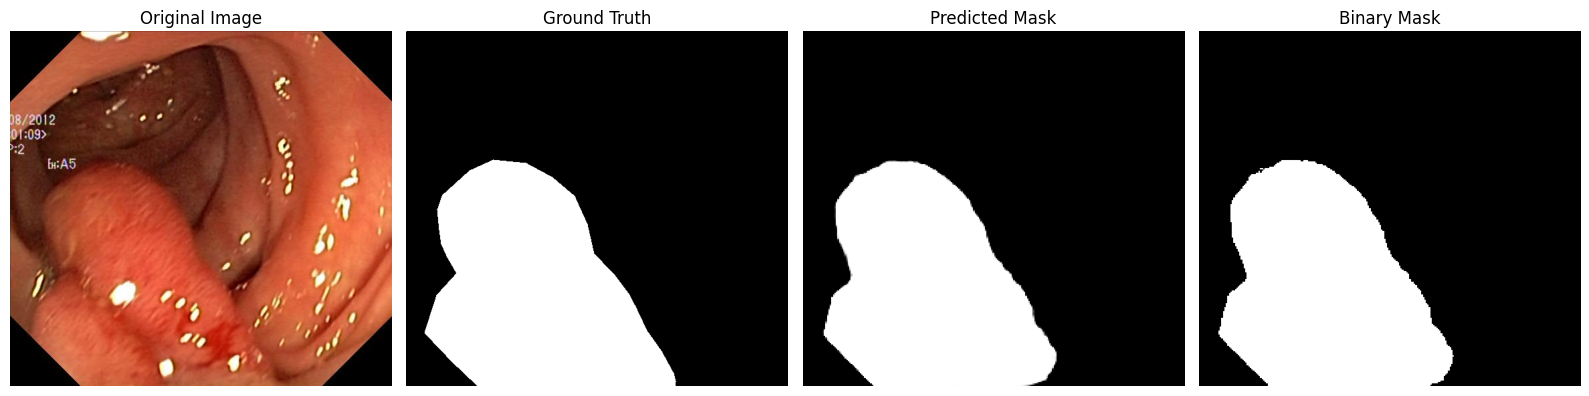

cju30qbm1ad3x0855znuhpz9u.jpg: Dice=0.9834, IoU=0.9674, Acc=0.9898, Prec=0.9874, Rec=0.9795


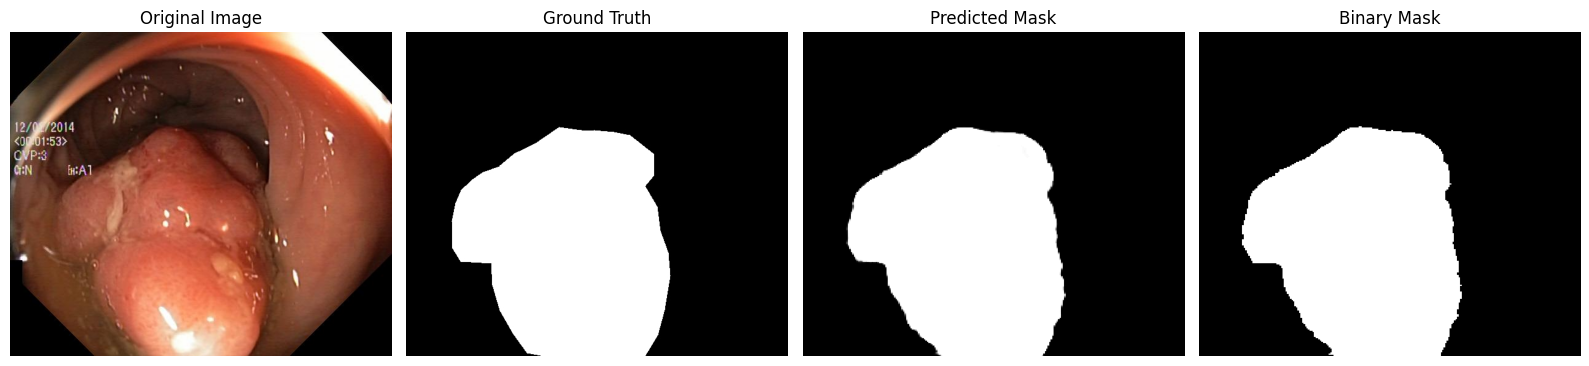

cju5xq3tdm9fn0987pbedxdg5.jpg: Dice=0.8744, IoU=0.7768, Acc=0.9919, Prec=0.9807, Rec=0.7888


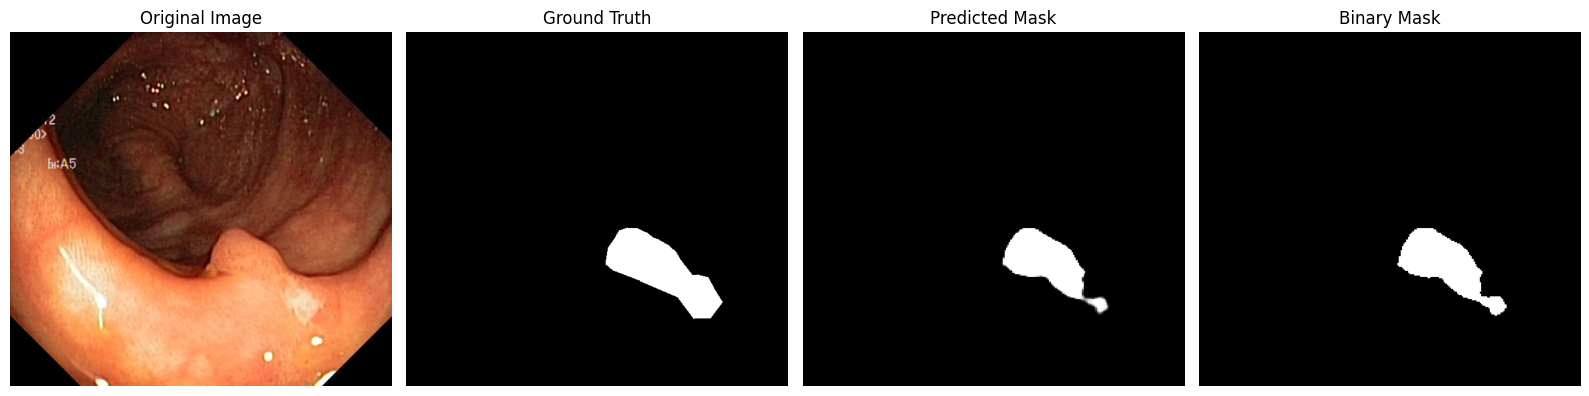

cju7deifq2fzn0755lc8idyh8.jpg: Dice=0.9643, IoU=0.9311, Acc=0.9945, Prec=0.9766, Rec=0.9523
cju2raxlosl630988jdbfy9b0.jpg: Dice=0.9687, IoU=0.9393, Acc=0.9794, Prec=0.9692, Rec=0.9681
cju5uget8krjy0818kvywd0zu.jpg: Dice=0.9609, IoU=0.9247, Acc=0.9972, Prec=0.9892, Rec=0.9342
cju8b1v3br45u087189kku66u.jpg: Dice=0.9824, IoU=0.9654, Acc=0.9914, Prec=0.9904, Rec=0.9746
cju1hs0za7jha0855vj0mdrjt.jpg: Dice=0.9826, IoU=0.9657, Acc=0.9939, Prec=0.9841, Rec=0.9810
cju171py4qiha0835u8sl59ds.jpg: Dice=0.9859, IoU=0.9723, Acc=0.9897, Prec=0.9843, Rec=0.9876
ck2bxiswtxuw80838qkisqjwz.jpg: Dice=0.9347, IoU=0.8774, Acc=0.9443, Prec=0.9712, Rec=0.9008

Average Metrics on 10 samples:
Dice Coefficient: 0.9622 ± 0.0329
IoU Score: 0.9289 ± 0.0580
Accuracy: 0.9864 ± 0.0147
Precision: 0.9825 ± 0.0075
Recall: 0.9444 ± 0.0577

COMPARING MODELS
Comparing Regular DuckNet vs DuckNet with Attention...
------------------------------------------------------------

Sample 1: cju7d1tvt25bu08019dvw3uff.jpg
Regular Duc

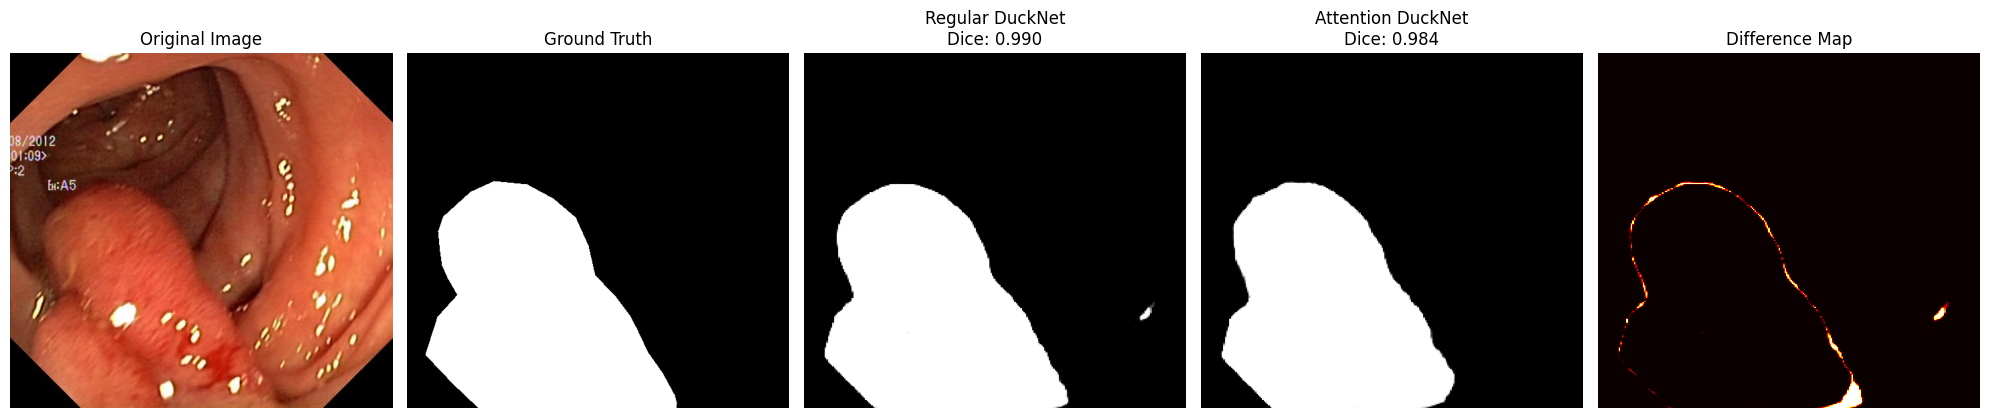


Sample 2: cju30qbm1ad3x0855znuhpz9u.jpg
Regular DuckNet    - Dice: 0.9807, IoU: 0.9622, Acc: 0.9883
Attention DuckNet  - Dice: 0.9834, IoU: 0.9674, Acc: 0.9898
Improvement        - Dice: +0.0027, IoU: +0.0052, Acc: +0.0016


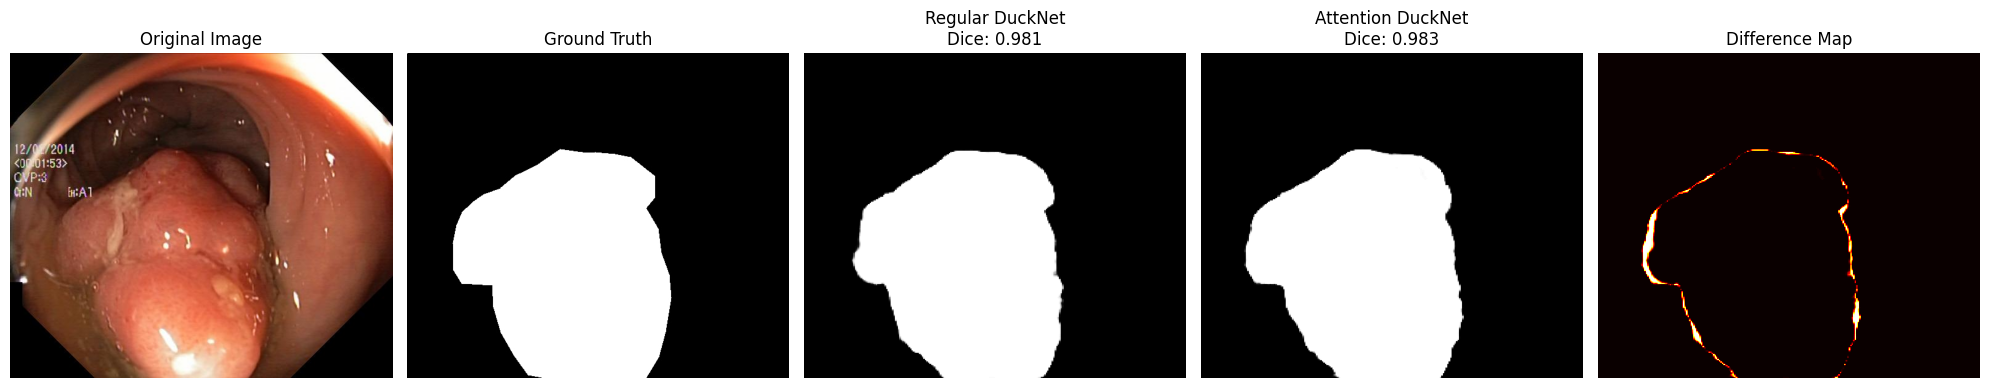


Sample 3: cju5xq3tdm9fn0987pbedxdg5.jpg
Regular DuckNet    - Dice: 0.8592, IoU: 0.7532, Acc: 0.9909
Attention DuckNet  - Dice: 0.8744, IoU: 0.7768, Acc: 0.9919
Improvement        - Dice: +0.0151, IoU: +0.0236, Acc: +0.0010


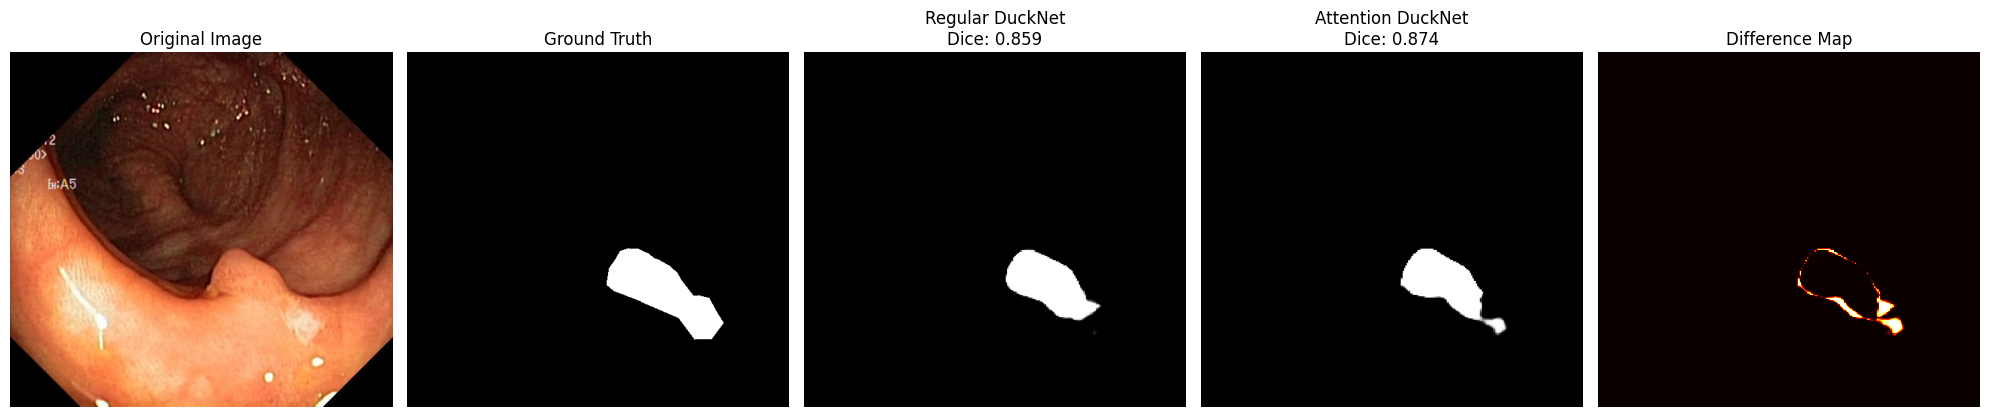


Sample 4: cju7deifq2fzn0755lc8idyh8.jpg
Regular DuckNet    - Dice: 0.9441, IoU: 0.8942, Acc: 0.9916
Attention DuckNet  - Dice: 0.9643, IoU: 0.9311, Acc: 0.9945
Improvement        - Dice: +0.0201, IoU: +0.0369, Acc: +0.0029

Sample 5: cju2raxlosl630988jdbfy9b0.jpg
Regular DuckNet    - Dice: 0.9760, IoU: 0.9532, Acc: 0.9845
Attention DuckNet  - Dice: 0.9687, IoU: 0.9393, Acc: 0.9794
Improvement        - Dice: -0.0074, IoU: -0.0140, Acc: -0.0051

AVERAGE RESULTS:
Regular DuckNet    - Dice: 0.9500, IoU: 0.9085, Acc: 0.9899
Attention DuckNet  - Dice: 0.9550, IoU: 0.9168, Acc: 0.9894
Average Improvement - Dice: +0.0050, IoU: +0.0082, Acc: -0.0005


In [11]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from ducknet_attention import create_attention_ducknet

def load_model(checkpoint_path, device):
    """Load trained PyTorch DuckNet Attention model"""
    model = create_attention_ducknet(input_channels=3, num_classes=1)
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    print(f"DuckNet Attention model loaded from {checkpoint_path}")
    if 'val_dice' in checkpoint:
        print(f"Model validation Dice: {checkpoint['val_dice']:.4f}")
    
    return model

def preprocess_image(image_path):
    """Preprocess image for inference"""
    # Load image
    image = Image.open(image_path).convert('RGB')
    original_size = image.size
    
    # Define transform
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Apply transform
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    return input_tensor, original_size, image

def postprocess_mask(mask_tensor, original_size):
    """Postprocess model output to get final mask"""
    # Remove batch dimension and convert to numpy
    mask = mask_tensor.squeeze(0).squeeze(0).cpu().numpy()
    
    # Convert to PIL Image and resize to original size
    mask_img = Image.fromarray((mask * 255).astype(np.uint8))
    mask_img = mask_img.resize(original_size, Image.NEAREST)
    
    return np.array(mask_img) / 255.0

def predict_single_image(model, image_path, device, threshold=0.5):
    """Predict mask for a single image using DuckNet Attention"""
    # Preprocess
    input_tensor, original_size, original_image = preprocess_image(image_path)
    input_tensor = input_tensor.to(device)
    
    # Inference
    with torch.no_grad():
        output = model(input_tensor)
        mask = torch.sigmoid(output)
    
    # Postprocess
    mask_np = postprocess_mask(mask, original_size)
    binary_mask = (mask_np > threshold).astype(np.uint8)
    
    return original_image, mask_np, binary_mask

def visualize_prediction(original_image, predicted_mask, binary_mask, ground_truth_mask=None):
    """Visualize prediction results"""
    if ground_truth_mask is not None:
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        titles = ['Original Image', 'Ground Truth', 'Predicted Mask', 'Binary Mask']
        images = [original_image, ground_truth_mask, predicted_mask, binary_mask]
        cmaps = [None, 'gray', 'gray', 'gray']
    else:
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        titles = ['Original Image', 'Predicted Mask', 'Binary Mask']
        images = [original_image, predicted_mask, binary_mask]
        cmaps = [None, 'gray', 'gray']
    
    for ax, img, title, cmap in zip(axes, images, titles, cmaps):
        ax.imshow(img, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def calculate_metrics(pred_mask, gt_mask, threshold=0.5):
    """Calculate evaluation metrics"""
    pred_binary = (pred_mask > threshold).astype(np.uint8)
    gt_binary = (gt_mask > 0.5).astype(np.uint8)
    
    # Dice coefficient
    intersection = np.sum(pred_binary * gt_binary)
    dice = (2.0 * intersection) / (np.sum(pred_binary) + np.sum(gt_binary) + 1e-6)
    
    # IoU (Jaccard index)
    union = np.sum(pred_binary) + np.sum(gt_binary) - intersection
    iou = intersection / (union + 1e-6)
    
    # Accuracy
    accuracy = np.mean(pred_binary == gt_binary)
    
    # Precision
    precision = intersection / (np.sum(pred_binary) + 1e-6)
    
    # Recall
    recall = intersection / (np.sum(gt_binary) + 1e-6)
    
    return dice, iou, accuracy, precision, recall

def compare_models(regular_model, attention_model, device, test_images, test_masks, num_samples=5):
    """Compare regular DuckNet with DuckNet Attention"""
    results = []
    
    print("Comparing Regular DuckNet vs DuckNet with Attention...")
    print("-" * 60)
    
    for i in range(min(num_samples, len(test_images))):
        img_path = test_images[i]
        mask_path = test_masks[i]
        
        if not os.path.exists(mask_path):
            continue
            
        print(f"\nSample {i+1}: {os.path.basename(img_path)}")
        
        # Load ground truth
        gt_mask = np.array(Image.open(mask_path).convert('L')) / 255.0
        
        # Predict with regular model
        _, reg_mask, _ = predict_single_image(regular_model, img_path, device)
        reg_dice, reg_iou, reg_acc, reg_prec, reg_rec = calculate_metrics(reg_mask, gt_mask)
        
        # Predict with attention model
        original_image, att_mask, att_binary = predict_single_image(attention_model, img_path, device)
        att_dice, att_iou, att_acc, att_prec, att_rec = calculate_metrics(att_mask, gt_mask)
        
        print(f"Regular DuckNet    - Dice: {reg_dice:.4f}, IoU: {reg_iou:.4f}, Acc: {reg_acc:.4f}")
        print(f"Attention DuckNet  - Dice: {att_dice:.4f}, IoU: {att_iou:.4f}, Acc: {att_acc:.4f}")
        print(f"Improvement        - Dice: {att_dice-reg_dice:+.4f}, IoU: {att_iou-reg_iou:+.4f}, Acc: {att_acc-reg_acc:+.4f}")
        
        results.append({
            'regular': {'dice': reg_dice, 'iou': reg_iou, 'acc': reg_acc, 'prec': reg_prec, 'rec': reg_rec},
            'attention': {'dice': att_dice, 'iou': att_iou, 'acc': att_acc, 'prec': att_prec, 'rec': att_rec}
        })
        
        # Visualize comparison for first few samples
        if i < 3:
            fig, axes = plt.subplots(1, 5, figsize=(20, 4))
            axes[0].imshow(original_image)
            axes[0].set_title('Original Image')
            axes[0].axis('off')
            
            axes[1].imshow(gt_mask, cmap='gray')
            axes[1].set_title('Ground Truth')
            axes[1].axis('off')
            
            axes[2].imshow(reg_mask, cmap='gray')
            axes[2].set_title(f'Regular DuckNet\nDice: {reg_dice:.3f}')
            axes[2].axis('off')
            
            axes[3].imshow(att_mask, cmap='gray')
            axes[3].set_title(f'Attention DuckNet\nDice: {att_dice:.3f}')
            axes[3].axis('off')
            
            # Difference map
            diff = np.abs(att_mask - reg_mask)
            axes[4].imshow(diff, cmap='hot')
            axes[4].set_title('Difference Map')
            axes[4].axis('off')
            
            plt.tight_layout()
            plt.show()
    
    # Calculate average improvements
    if results:
        avg_reg_dice = np.mean([r['regular']['dice'] for r in results])
        avg_att_dice = np.mean([r['attention']['dice'] for r in results])
        avg_reg_iou = np.mean([r['regular']['iou'] for r in results])
        avg_att_iou = np.mean([r['attention']['iou'] for r in results])
        avg_reg_acc = np.mean([r['regular']['acc'] for r in results])
        avg_att_acc = np.mean([r['attention']['acc'] for r in results])
        
        print(f"\n{'='*60}")
        print("AVERAGE RESULTS:")
        print(f"Regular DuckNet    - Dice: {avg_reg_dice:.4f}, IoU: {avg_reg_iou:.4f}, Acc: {avg_reg_acc:.4f}")
        print(f"Attention DuckNet  - Dice: {avg_att_dice:.4f}, IoU: {avg_att_iou:.4f}, Acc: {avg_att_acc:.4f}")
        print(f"Average Improvement - Dice: {avg_att_dice-avg_reg_dice:+.4f}, IoU: {avg_att_iou-avg_reg_iou:+.4f}, Acc: {avg_att_acc-avg_reg_acc:+.4f}")

def test_on_validation_set(model, device, val_images_dir, val_masks_dir, num_samples=10):
    """Test model on validation set"""
    image_files = [f for f in os.listdir(val_images_dir) if f.endswith('.jpg')][:num_samples]
    
    dice_scores = []
    iou_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    
    for img_file in image_files:
        img_path = os.path.join(val_images_dir, img_file)
        mask_path = os.path.join(val_masks_dir, img_file)
        
        if os.path.exists(mask_path):
            # Predict
            original_image, predicted_mask, binary_mask = predict_single_image(model, img_path, device)
            
            # Load ground truth
            gt_mask = np.array(Image.open(mask_path).convert('L')) / 255.0
            
            # Calculate metrics
            dice, iou, accuracy, precision, recall = calculate_metrics(predicted_mask, gt_mask)
            dice_scores.append(dice)
            iou_scores.append(iou)
            accuracy_scores.append(accuracy)
            precision_scores.append(precision)
            recall_scores.append(recall)
            
            print(f"{img_file}: Dice={dice:.4f}, IoU={iou:.4f}, Acc={accuracy:.4f}, Prec={precision:.4f}, Rec={recall:.4f}")
            
            # Visualize first few predictions
            if len(dice_scores) <= 3:
                visualize_prediction(original_image, predicted_mask, binary_mask, gt_mask)
    
    # Print average metrics
    print(f"\nAverage Metrics on {len(dice_scores)} samples:")
    print(f"Dice Coefficient: {np.mean(dice_scores):.4f} ± {np.std(dice_scores):.4f}")
    print(f"IoU Score: {np.mean(iou_scores):.4f} ± {np.std(iou_scores):.4f}")
    print(f"Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
    print(f"Precision: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
    print(f"Recall: {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")

def main():
    """Main inference function"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load DuckNet Attention model
    attention_checkpoint_path = '/kaggle/working/checkpoints/ducknet_attention_pytorch_best.pth'
    if not os.path.exists(attention_checkpoint_path):
        print(f"Attention checkpoint not found at {attention_checkpoint_path}")
        print("Please train the attention model first using train_pytorch_attention.py")
        return
    
    attention_model = load_model(attention_checkpoint_path, device)
    
    # Test on validation set
    val_images_dir = "/kaggle/input/dataset/Kvasir-SEG/images"
    val_masks_dir = "/kaggle/input/dataset/Kvasir-SEG/masks"
    
    if os.path.exists(val_images_dir) and os.path.exists(val_masks_dir):
        print("Testing DuckNet with Multi Attention on validation set...")
        test_on_validation_set(attention_model, device, val_images_dir, val_masks_dir, num_samples=10)
        
        # Compare with regular DuckNet if available
        regular_checkpoint_path = 'checkpoints/ducknet_pytorch_best.pth'
        if os.path.exists(regular_checkpoint_path):
            print("\n" + "="*60)
            print("COMPARING MODELS")
            print("="*60)
            
            from ducknet import create_ducknet
            regular_model = create_ducknet(input_channels=3, num_classes=1)
            regular_checkpoint = torch.load(regular_checkpoint_path, map_location=device)
            regular_model.load_state_dict(regular_checkpoint['model_state_dict'])
            regular_model.to(device)
            regular_model.eval()
            
            # Get test images
            test_images = [os.path.join(val_images_dir, f) for f in os.listdir(val_images_dir) if f.endswith('.jpg')][:5]
            test_masks = [os.path.join(val_masks_dir, f) for f in os.listdir(val_masks_dir) if f.endswith('.jpg')][:5]
            
            compare_models(regular_model, attention_model, device, test_images, test_masks, num_samples=5)
        else:
            print(f"\nRegular DuckNet checkpoint not found at {regular_checkpoint_path}")
            print("Skipping model comparison.")
            
    else:
        print("Validation directories not found. Testing with single image...")
        
        # Test with a single image if available
        test_image_path = "data/Kvasir-SEG/images/cju0qkwl35piu0993l0dewei2.jpg"
        if os.path.exists(test_image_path):
            original_image, predicted_mask, binary_mask = predict_single_image(attention_model, test_image_path, device)
            visualize_prediction(original_image, predicted_mask, binary_mask)
        else:
            print("No test images found. Please check your data directory.")

if __name__ == "__main__":
    main() 